##### Copyright 2022 The TensorFlow Compression Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Learned data compression

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/data_compression">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/data_compression.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/data_compression.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/data_compression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This notebook shows how to do lossy data compression using neural networks and [TensorFlow Compression](https://github.com/tensorflow/compression).

Lossy compression involves making a trade-off between **rate**, the expected number of bits needed to encode a sample, and **distortion**, the expected error in the reconstruction of the sample.

The examples below use an autoencoder-like model to compress images from the MNIST dataset. The method is based on the paper [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704).

More background on learned data compression can be found in [this paper](https://arxiv.org/abs/2007.03034) targeted at people familiar with classical data compression, or [this survey](https://arxiv.org/abs/2202.06533) targeted at a machine learning audience.


## Setup

Install Tensorflow Compression via `pip`.

In [2]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"


Import library dependencies.

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds


2022-12-14 05:07:14.936601: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 05:07:14.936729: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 05:07:14.936739: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Define the trainer model.

Because the model resembles an autoencoder, and we need to perform a different set of functions during training and inference, the setup is a little different from, say, a classifier.

The training model consists of three parts:
- the **analysis** (or encoder) transform, converting from the image into a latent space,
- the **synthesis** (or decoder) transform, converting from the latent space back into image space, and
- a **prior** and entropy model, modeling the marginal probabilities of the latents.

First, define the transforms:

In [4]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")


In [5]:
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          2450, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((7, 7, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")


The trainer holds an instance of both transforms, as well as the parameters of the prior.

Its `call` method is set up to compute:
- **rate**, an estimate of the number of bits needed to represent the batch of digits, and
- **distortion**, the mean absolute difference between the pixels of the original digits and their reconstructions.


In [6]:
class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 28, 28, 1))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)


### Compute rate and distortion.

Let's walk through this step by step, using one image from the training set. Load the MNIST dataset for training and validation:

In [7]:
training_dataset, validation_dataset = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)


And extract one image $x$:

Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


2022-12-14 05:07:21.018802: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


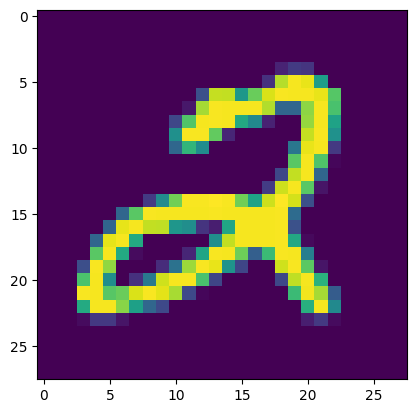

In [8]:
(x, _), = validation_dataset.take(1)

plt.imshow(tf.squeeze(x))
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")


To get the latent representation $y$, we need to cast it to `float32`, add a batch dimension, and pass it through the analysis transform.

In [9]:
x = tf.cast(x, tf.float32) / 255.
x = tf.reshape(x, (-1, 28, 28, 1))
y = make_analysis_transform(10)(x)

print("y:", y)


y: tf.Tensor(
[[-0.00890801 -0.00818517 -0.05875479 -0.04062736  0.02587906  0.06025435
   0.03379093  0.00092353 -0.06572281  0.02619635]], shape=(1, 10), dtype=float32)


The latents will be quantized at test time. To model this in a differentiable way during training, we add uniform noise in the interval $(-.5, .5)$ and call the result $\tilde y$. This is the same terminology as used in the paper [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704).

In [10]:
y_tilde = y + tf.random.uniform(y.shape, -.5, .5)

print("y_tilde:", y_tilde)


y_tilde: tf.Tensor(
[[ 0.13539411 -0.441785   -0.22980475 -0.31791997 -0.4497281   0.40218294
  -0.26774383  0.10009648 -0.06452285  0.26391804]], shape=(1, 10), dtype=float32)


The "prior" is a probability density that we train to model the marginal distribution of the noisy latents. For example, it could be a set of independent [logistic distributions](https://en.wikipedia.org/wiki/Logistic_distribution) with different scales for each latent dimension. `tfc.NoisyLogistic` accounts for the fact that the latents have additive noise. As the scale approaches zero, a logistic distribution approaches a dirac delta (spike), but the added noise causes the "noisy" distribution to approach the uniform distribution instead.

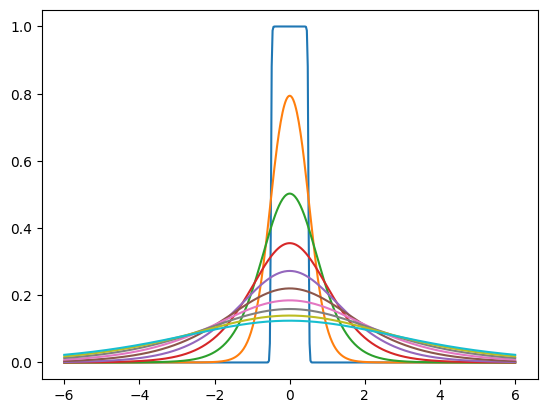

In [11]:
prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.01, 2., 10))

_ = tf.linspace(-6., 6., 501)[:, None]
plt.plot(_, prior.prob(_));


During training, `tfc.ContinuousBatchedEntropyModel` adds uniform noise, and uses the noise and the prior to compute a (differentiable) upper bound on the rate (the average number of bits necessary to encode the latent representation). That bound can be minimized as a loss.

In [12]:
entropy_model = tfc.ContinuousBatchedEntropyModel(
    prior, coding_rank=1, compression=False)
y_tilde, rate = entropy_model(y, training=True)

print("rate:", rate)
print("y_tilde:", y_tilde)


rate: tf.Tensor([18.038872], shape=(1,), dtype=float32)
y_tilde: tf.Tensor(
[[-0.44282457  0.2243769  -0.01583373 -0.02020657 -0.3466693  -0.03906595
  -0.13695122  0.35441723 -0.1069089   0.45609498]], shape=(1, 10), dtype=float32)


Lastly, the noisy latents are passed back through the synthesis transform to produce an image reconstruction $\tilde x$. Distortion is the error between original image and reconstruction. Obviously, with the transforms untrained, the reconstruction is not very useful.

distortion: tf.Tensor(0.17139097, shape=(), dtype=float32)
Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


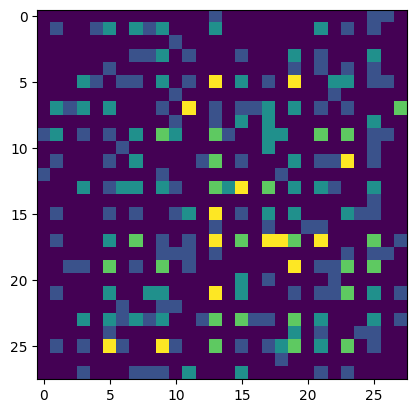

In [13]:
x_tilde = make_synthesis_transform()(y_tilde)

# Mean absolute difference across pixels.
distortion = tf.reduce_mean(abs(x - x_tilde))
print("distortion:", distortion)

x_tilde = tf.saturate_cast(x_tilde[0] * 255, tf.uint8)
plt.imshow(tf.squeeze(x_tilde))
print(f"Data type: {x_tilde.dtype}")
print(f"Shape: {x_tilde.shape}")


For every batch of digits, calling the `MNISTCompressionTrainer` produces the rate and distortion as an average over that batch:


In [14]:
(example_batch, _), = validation_dataset.batch(32).take(1)
trainer = MNISTCompressionTrainer(10)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])


rate:  tf.Tensor(20.296253, shape=(), dtype=float32)
distortion:  tf.Tensor(0.14659302, shape=(), dtype=float32)


2022-12-14 05:07:23.144915: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In the next section, we set up the model to do gradient descent on these two losses.

## Train the model.

We compile the trainer in a way that it optimizes the rate–distortion Lagrangian, that is, a sum of rate and distortion, where one of the terms is weighted by Lagrange parameter $\lambda$.

This loss function affects the different parts of the model differently:
- The analysis transform is trained to produce a latent representation that achieves the desired trade-off between rate and distortion.
- The synthesis transform is trained to minimize distortion, given the latent representation.
- The parameters of the prior are trained to minimize the rate given the latent representation. This is identical to fitting the prior to the marginal distribution of latents in a maximum likelihood sense.

In [15]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_mnist_compression_trainer(lmbda, latent_dims=50):
  trainer = MNISTCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer


Next, train the model. The human annotations are not necessary here, since we just want to compress the images, so we drop them using a `map` and instead add "dummy" targets for rate and distortion.

In [16]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=15,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer

trainer = train_mnist_model(lmbda=2000)


Epoch 1/15


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


  1/469 [..............................] - ETA: 32:31 - loss: 350.3319 - distortion_loss: 0.1237 - rate_loss: 102.9615 - distortion_pass_through_loss: 0.1237 - rate_pass_through_loss: 102.9615

  9/469 [..............................] - ETA: 3s - loss: 366.9090 - distortion_loss: 0.1321 - rate_loss: 102.6643 - distortion_pass_through_loss: 0.1321 - rate_pass_through_loss: 102.6643   

 17/469 [>.............................] - ETA: 2s - loss: 363.3591 - distortion_loss: 0.1303 - rate_loss: 102.7333 - distortion_pass_through_loss: 0.1303 - rate_pass_through_loss: 102.7333

 25/469 [>.............................] - ETA: 2s - loss: 359.1642 - distortion_loss: 0.1282 - rate_loss: 102.6803 - distortion_pass_through_loss: 0.1282 - rate_pass_through_loss: 102.6803

 34/469 [=>............................] - ETA: 2s - loss: 353.9556 - distortion_loss: 0.1256 - rate_loss: 102.6592 - distortion_pass_through_loss: 0.1256 - rate_pass_through_loss: 102.6592

 43/469 [=>............................] - ETA: 2s - loss: 344.5855 - distortion_loss: 0.1208 - rate_loss: 102.9635 - distortion_pass_through_loss: 0.1208 - rate_pass_through_loss: 102.9635

 52/469 [==>...........................] - ETA: 2s - loss: 335.7888 - distortion_loss: 0.1164 - rate_loss: 103.0649 - distortion_pass_through_loss: 0.1164 - rate_pass_through_loss: 103.0649

 60/469 [==>...........................] - ETA: 2s - loss: 328.3539 - distortion_loss: 0.1127 - rate_loss: 103.0329 - distortion_pass_through_loss: 0.1127 - rate_pass_through_loss: 103.0329

 69/469 [===>..........................] - ETA: 2s - loss: 321.1235 - distortion_loss: 0.1090 - rate_loss: 103.0410 - distortion_pass_through_loss: 0.1090 - rate_pass_through_loss: 103.0410

 78/469 [===>..........................] - ETA: 2s - loss: 314.1082 - distortion_loss: 0.1055 - rate_loss: 103.0896 - distortion_pass_through_loss: 0.1055 - rate_pass_through_loss: 103.0896

 86/469 [====>.........................] - ETA: 2s - loss: 308.5108 - distortion_loss: 0.1027 - rate_loss: 103.1403 - distortion_pass_through_loss: 0.1027 - rate_pass_through_loss: 103.1403

 95/469 [=====>........................] - ETA: 2s - loss: 302.4411 - distortion_loss: 0.0996 - rate_loss: 103.2075 - distortion_pass_through_loss: 0.0996 - rate_pass_through_loss: 103.2075

103/469 [=====>........................] - ETA: 2s - loss: 297.6840 - distortion_loss: 0.0972 - rate_loss: 103.2675 - distortion_pass_through_loss: 0.0972 - rate_pass_through_loss: 103.2675

111/469 [======>.......................] - ETA: 2s - loss: 293.1094 - distortion_loss: 0.0949 - rate_loss: 103.2999 - distortion_pass_through_loss: 0.0949 - rate_pass_through_loss: 103.2999

120/469 [======>.......................] - ETA: 2s - loss: 288.4594 - distortion_loss: 0.0926 - rate_loss: 103.3431 - distortion_pass_through_loss: 0.0926 - rate_pass_through_loss: 103.3431

129/469 [=======>......................] - ETA: 2s - loss: 283.9919 - distortion_loss: 0.0903 - rate_loss: 103.3746 - distortion_pass_through_loss: 0.0903 - rate_pass_through_loss: 103.3746

138/469 [=======>......................] - ETA: 2s - loss: 279.9440 - distortion_loss: 0.0883 - rate_loss: 103.3954 - distortion_pass_through_loss: 0.0883 - rate_pass_through_loss: 103.3954

147/469 [========>.....................] - ETA: 2s - loss: 276.3292 - distortion_loss: 0.0865 - rate_loss: 103.3984 - distortion_pass_through_loss: 0.0865 - rate_pass_through_loss: 103.3984

156/469 [========>.....................] - ETA: 1s - loss: 273.0055 - distortion_loss: 0.0848 - rate_loss: 103.4022 - distortion_pass_through_loss: 0.0848 - rate_pass_through_loss: 103.4022

165/469 [=========>....................] - ETA: 1s - loss: 269.9395 - distortion_loss: 0.0833 - rate_loss: 103.3939 - distortion_pass_through_loss: 0.0833 - rate_pass_through_loss: 103.3939

174/469 [==========>...................] - ETA: 1s - loss: 267.0000 - distortion_loss: 0.0818 - rate_loss: 103.3593 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 103.3593

183/469 [==========>...................] - ETA: 1s - loss: 264.2647 - distortion_loss: 0.0805 - rate_loss: 103.3326 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 103.3326

191/469 [===========>..................] - ETA: 1s - loss: 261.9611 - distortion_loss: 0.0793 - rate_loss: 103.3024 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 103.3024

199/469 [===========>..................] - ETA: 1s - loss: 259.7542 - distortion_loss: 0.0782 - rate_loss: 103.2655 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 103.2655

207/469 [============>.................] - ETA: 1s - loss: 257.6577 - distortion_loss: 0.0772 - rate_loss: 103.2169 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 103.2169

216/469 [============>.................] - ETA: 1s - loss: 255.3243 - distortion_loss: 0.0761 - rate_loss: 103.1512 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 103.1512

224/469 [=============>................] - ETA: 1s - loss: 253.4181 - distortion_loss: 0.0752 - rate_loss: 103.0988 - distortion_pass_through_loss: 0.0752 - rate_pass_through_loss: 103.0988

233/469 [=============>................] - ETA: 1s - loss: 251.4453 - distortion_loss: 0.0742 - rate_loss: 103.0293 - distortion_pass_through_loss: 0.0742 - rate_pass_through_loss: 103.0293

241/469 [==============>...............] - ETA: 1s - loss: 249.7167 - distortion_loss: 0.0734 - rate_loss: 102.9520 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 102.9520

249/469 [==============>...............] - ETA: 1s - loss: 248.1366 - distortion_loss: 0.0726 - rate_loss: 102.8819 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 102.8819

257/469 [===============>..............] - ETA: 1s - loss: 246.5493 - distortion_loss: 0.0719 - rate_loss: 102.8021 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 102.8021

265/469 [===============>..............] - ETA: 1s - loss: 245.0183 - distortion_loss: 0.0712 - rate_loss: 102.7171 - distortion_pass_through_loss: 0.0712 - rate_pass_through_loss: 102.7171

273/469 [================>.............] - ETA: 1s - loss: 243.5925 - distortion_loss: 0.0705 - rate_loss: 102.6319 - distortion_pass_through_loss: 0.0705 - rate_pass_through_loss: 102.6319

282/469 [=================>............] - ETA: 1s - loss: 242.0537 - distortion_loss: 0.0698 - rate_loss: 102.5316 - distortion_pass_through_loss: 0.0698 - rate_pass_through_loss: 102.5316

290/469 [=================>............] - ETA: 1s - loss: 240.7323 - distortion_loss: 0.0691 - rate_loss: 102.4435 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 102.4435

298/469 [==================>...........] - ETA: 1s - loss: 239.4003 - distortion_loss: 0.0685 - rate_loss: 102.3471 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 102.3471

306/469 [==================>...........] - ETA: 1s - loss: 238.1811 - distortion_loss: 0.0680 - rate_loss: 102.2518 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 102.2518

314/469 [===================>..........] - ETA: 0s - loss: 236.9910 - distortion_loss: 0.0674 - rate_loss: 102.1506 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 102.1506

323/469 [===================>..........] - ETA: 0s - loss: 235.6970 - distortion_loss: 0.0668 - rate_loss: 102.0374 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 102.0374

332/469 [====================>.........] - ETA: 0s - loss: 234.4572 - distortion_loss: 0.0663 - rate_loss: 101.9152 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 101.9152

341/469 [====================>.........] - ETA: 0s - loss: 233.2495 - distortion_loss: 0.0657 - rate_loss: 101.7950 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 101.7950

349/469 [=====================>........] - ETA: 0s - loss: 232.2088 - distortion_loss: 0.0653 - rate_loss: 101.6860 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 101.6860

357/469 [=====================>........] - ETA: 0s - loss: 231.1932 - distortion_loss: 0.0648 - rate_loss: 101.5812 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 101.5812

366/469 [======================>.......] - ETA: 0s - loss: 230.1026 - distortion_loss: 0.0643 - rate_loss: 101.4501 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 101.4501

375/469 [======================>.......] - ETA: 0s - loss: 229.0310 - distortion_loss: 0.0639 - rate_loss: 101.3201 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 101.3201

384/469 [=======================>......] - ETA: 0s - loss: 227.9979 - distortion_loss: 0.0634 - rate_loss: 101.1828 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 101.1828

393/469 [========================>.....] - ETA: 0s - loss: 226.9875 - distortion_loss: 0.0630 - rate_loss: 101.0444 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 101.0444

402/469 [========================>.....] - ETA: 0s - loss: 225.9777 - distortion_loss: 0.0625 - rate_loss: 100.9032 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 100.9032

411/469 [=========================>....] - ETA: 0s - loss: 225.0211 - distortion_loss: 0.0621 - rate_loss: 100.7671 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 100.7671

420/469 [=========================>....] - ETA: 0s - loss: 224.0925 - distortion_loss: 0.0617 - rate_loss: 100.6249 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 100.6249

429/469 [==========================>...] - ETA: 0s - loss: 223.2077 - distortion_loss: 0.0614 - rate_loss: 100.4884 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 100.4884

438/469 [===========================>..] - ETA: 0s - loss: 222.3379 - distortion_loss: 0.0610 - rate_loss: 100.3412 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 100.3412

446/469 [===========================>..] - ETA: 0s - loss: 221.5890 - distortion_loss: 0.0607 - rate_loss: 100.2107 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 100.2107

454/469 [============================>.] - ETA: 0s - loss: 220.8564 - distortion_loss: 0.0604 - rate_loss: 100.0825 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 100.0825

463/469 [============================>.] - ETA: 0s - loss: 220.0550 - distortion_loss: 0.0601 - rate_loss: 99.9402 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 99.9402  

469/469 [==============================] - 8s 8ms/step - loss: 219.5457 - distortion_loss: 0.0599 - rate_loss: 99.8425 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 99.8376 - val_loss: 177.2793 - val_distortion_loss: 0.0427 - val_rate_loss: 91.7949 - val_distortion_pass_through_loss: 0.0428 - val_rate_pass_through_loss: 91.7969


Epoch 2/15


  1/469 [..............................] - ETA: 4s - loss: 172.1122 - distortion_loss: 0.0405 - rate_loss: 91.1715 - distortion_pass_through_loss: 0.0405 - rate_pass_through_loss: 91.1715

 11/469 [..............................] - ETA: 2s - loss: 178.1765 - distortion_loss: 0.0432 - rate_loss: 91.8161 - distortion_pass_through_loss: 0.0432 - rate_pass_through_loss: 91.8161

 20/469 [>.............................] - ETA: 2s - loss: 178.0095 - distortion_loss: 0.0431 - rate_loss: 91.7892 - distortion_pass_through_loss: 0.0431 - rate_pass_through_loss: 91.7892

 29/469 [>.............................] - ETA: 2s - loss: 177.9149 - distortion_loss: 0.0432 - rate_loss: 91.5869 - distortion_pass_through_loss: 0.0432 - rate_pass_through_loss: 91.5869

 39/469 [=>............................] - ETA: 2s - loss: 177.3438 - distortion_loss: 0.0430 - rate_loss: 91.3941 - distortion_pass_through_loss: 0.0430 - rate_pass_through_loss: 91.3941

 48/469 [==>...........................] - ETA: 2s - loss: 177.1060 - distortion_loss: 0.0430 - rate_loss: 91.1884 - distortion_pass_through_loss: 0.0430 - rate_pass_through_loss: 91.1884

 58/469 [==>...........................] - ETA: 2s - loss: 176.8953 - distortion_loss: 0.0429 - rate_loss: 91.0272 - distortion_pass_through_loss: 0.0429 - rate_pass_through_loss: 91.0272

 67/469 [===>..........................] - ETA: 2s - loss: 176.8255 - distortion_loss: 0.0430 - rate_loss: 90.8401 - distortion_pass_through_loss: 0.0430 - rate_pass_through_loss: 90.8401

 77/469 [===>..........................] - ETA: 2s - loss: 176.3068 - distortion_loss: 0.0428 - rate_loss: 90.6415 - distortion_pass_through_loss: 0.0428 - rate_pass_through_loss: 90.6415

 86/469 [====>.........................] - ETA: 2s - loss: 175.9736 - distortion_loss: 0.0427 - rate_loss: 90.4939 - distortion_pass_through_loss: 0.0427 - rate_pass_through_loss: 90.4939

 95/469 [=====>........................] - ETA: 2s - loss: 175.5568 - distortion_loss: 0.0426 - rate_loss: 90.3161 - distortion_pass_through_loss: 0.0426 - rate_pass_through_loss: 90.3161

104/469 [=====>........................] - ETA: 2s - loss: 175.2734 - distortion_loss: 0.0426 - rate_loss: 90.1482 - distortion_pass_through_loss: 0.0426 - rate_pass_through_loss: 90.1482

113/469 [======>.......................] - ETA: 1s - loss: 174.9829 - distortion_loss: 0.0425 - rate_loss: 89.9886 - distortion_pass_through_loss: 0.0425 - rate_pass_through_loss: 89.9886

122/469 [======>.......................] - ETA: 1s - loss: 174.6555 - distortion_loss: 0.0424 - rate_loss: 89.8186 - distortion_pass_through_loss: 0.0424 - rate_pass_through_loss: 89.8186

132/469 [=======>......................] - ETA: 1s - loss: 174.2176 - distortion_loss: 0.0423 - rate_loss: 89.6154 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 89.6154

142/469 [========>.....................] - ETA: 1s - loss: 173.8578 - distortion_loss: 0.0422 - rate_loss: 89.4265 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 89.4265

152/469 [========>.....................] - ETA: 1s - loss: 173.5925 - distortion_loss: 0.0422 - rate_loss: 89.2393 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 89.2393

162/469 [=========>....................] - ETA: 1s - loss: 173.3962 - distortion_loss: 0.0422 - rate_loss: 89.0695 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 89.0695

172/469 [==========>...................] - ETA: 1s - loss: 173.1744 - distortion_loss: 0.0422 - rate_loss: 88.8707 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 88.8707

182/469 [==========>...................] - ETA: 1s - loss: 172.9555 - distortion_loss: 0.0421 - rate_loss: 88.7011 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 88.7011

192/469 [===========>..................] - ETA: 1s - loss: 172.7871 - distortion_loss: 0.0421 - rate_loss: 88.5312 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 88.5312

201/469 [===========>..................] - ETA: 1s - loss: 172.4873 - distortion_loss: 0.0421 - rate_loss: 88.3691 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 88.3691

211/469 [============>.................] - ETA: 1s - loss: 172.1645 - distortion_loss: 0.0420 - rate_loss: 88.1816 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 88.1816

221/469 [=============>................] - ETA: 1s - loss: 171.8985 - distortion_loss: 0.0419 - rate_loss: 88.0099 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 88.0099

230/469 [=============>................] - ETA: 1s - loss: 171.6597 - distortion_loss: 0.0419 - rate_loss: 87.8489 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 87.8489

240/469 [==============>...............] - ETA: 1s - loss: 171.4311 - distortion_loss: 0.0419 - rate_loss: 87.6773 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 87.6773

250/469 [==============>...............] - ETA: 1s - loss: 171.1787 - distortion_loss: 0.0418 - rate_loss: 87.4968 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 87.4968

260/469 [===============>..............] - ETA: 1s - loss: 170.9210 - distortion_loss: 0.0418 - rate_loss: 87.3242 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 87.3242

270/469 [================>.............] - ETA: 1s - loss: 170.6603 - distortion_loss: 0.0418 - rate_loss: 87.1518 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 87.1518

280/469 [================>.............] - ETA: 1s - loss: 170.4554 - distortion_loss: 0.0417 - rate_loss: 86.9725 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 86.9725

290/469 [=================>............] - ETA: 0s - loss: 170.3035 - distortion_loss: 0.0418 - rate_loss: 86.8003 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 86.8003

300/469 [==================>...........] - ETA: 0s - loss: 170.0529 - distortion_loss: 0.0417 - rate_loss: 86.6246 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 86.6246

310/469 [==================>...........] - ETA: 0s - loss: 169.8359 - distortion_loss: 0.0417 - rate_loss: 86.4608 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 86.4608

320/469 [===================>..........] - ETA: 0s - loss: 169.5979 - distortion_loss: 0.0417 - rate_loss: 86.2978 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 86.2978

330/469 [====================>.........] - ETA: 0s - loss: 169.4114 - distortion_loss: 0.0416 - rate_loss: 86.1286 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 86.1286

340/469 [====================>.........] - ETA: 0s - loss: 169.1984 - distortion_loss: 0.0416 - rate_loss: 85.9531 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 85.9531

350/469 [=====================>........] - ETA: 0s - loss: 168.9806 - distortion_loss: 0.0416 - rate_loss: 85.7889 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 85.7889

360/469 [======================>.......] - ETA: 0s - loss: 168.7578 - distortion_loss: 0.0416 - rate_loss: 85.6230 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 85.6230

370/469 [======================>.......] - ETA: 0s - loss: 168.5463 - distortion_loss: 0.0415 - rate_loss: 85.4599 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 85.4599

380/469 [=======================>......] - ETA: 0s - loss: 168.3114 - distortion_loss: 0.0415 - rate_loss: 85.2919 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 85.2919

390/469 [=======================>......] - ETA: 0s - loss: 168.0869 - distortion_loss: 0.0415 - rate_loss: 85.1308 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 85.1308

400/469 [========================>.....] - ETA: 0s - loss: 167.8712 - distortion_loss: 0.0415 - rate_loss: 84.9666 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 84.9666

409/469 [=========================>....] - ETA: 0s - loss: 167.6671 - distortion_loss: 0.0414 - rate_loss: 84.8154 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 84.8154

419/469 [=========================>....] - ETA: 0s - loss: 167.4649 - distortion_loss: 0.0414 - rate_loss: 84.6572 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 84.6572

429/469 [==========================>...] - ETA: 0s - loss: 167.2650 - distortion_loss: 0.0414 - rate_loss: 84.4992 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 84.4992

439/469 [===========================>..] - ETA: 0s - loss: 167.0513 - distortion_loss: 0.0414 - rate_loss: 84.3388 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 84.3388

449/469 [===========================>..] - ETA: 0s - loss: 166.8739 - distortion_loss: 0.0413 - rate_loss: 84.1805 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 84.1805

459/469 [============================>.] - ETA: 0s - loss: 166.6637 - distortion_loss: 0.0413 - rate_loss: 84.0243 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 84.0243

469/469 [==============================] - 3s 6ms/step - loss: 166.4634 - distortion_loss: 0.0413 - rate_loss: 83.8743 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 83.8699 - val_loss: 156.2419 - val_distortion_loss: 0.0405 - val_rate_loss: 75.3063 - val_distortion_pass_through_loss: 0.0405 - val_rate_pass_through_loss: 75.3100


Epoch 3/15


  1/469 [..............................] - ETA: 4s - loss: 151.1259 - distortion_loss: 0.0379 - rate_loss: 75.3979 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 75.3979

 10/469 [..............................] - ETA: 2s - loss: 157.6986 - distortion_loss: 0.0406 - rate_loss: 76.4627 - distortion_pass_through_loss: 0.0406 - rate_pass_through_loss: 76.4627

 19/469 [>.............................] - ETA: 2s - loss: 157.0469 - distortion_loss: 0.0403 - rate_loss: 76.3518 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 76.3518

 28/469 [>.............................] - ETA: 2s - loss: 157.2556 - distortion_loss: 0.0405 - rate_loss: 76.2775 - distortion_pass_through_loss: 0.0405 - rate_pass_through_loss: 76.2775

 38/469 [=>............................] - ETA: 2s - loss: 156.8162 - distortion_loss: 0.0404 - rate_loss: 76.0575 - distortion_pass_through_loss: 0.0404 - rate_pass_through_loss: 76.0575

 48/469 [==>...........................] - ETA: 2s - loss: 156.6651 - distortion_loss: 0.0404 - rate_loss: 75.8946 - distortion_pass_through_loss: 0.0404 - rate_pass_through_loss: 75.8946

 58/469 [==>...........................] - ETA: 2s - loss: 156.5871 - distortion_loss: 0.0404 - rate_loss: 75.8632 - distortion_pass_through_loss: 0.0404 - rate_pass_through_loss: 75.8632

 68/469 [===>..........................] - ETA: 2s - loss: 156.5878 - distortion_loss: 0.0404 - rate_loss: 75.6880 - distortion_pass_through_loss: 0.0404 - rate_pass_through_loss: 75.6880

 78/469 [===>..........................] - ETA: 2s - loss: 156.4364 - distortion_loss: 0.0405 - rate_loss: 75.5341 - distortion_pass_through_loss: 0.0405 - rate_pass_through_loss: 75.5341

 87/469 [====>.........................] - ETA: 2s - loss: 156.4396 - distortion_loss: 0.0405 - rate_loss: 75.3832 - distortion_pass_through_loss: 0.0405 - rate_pass_through_loss: 75.3832

 97/469 [=====>........................] - ETA: 2s - loss: 156.2028 - distortion_loss: 0.0405 - rate_loss: 75.2014 - distortion_pass_through_loss: 0.0405 - rate_pass_through_loss: 75.2014

107/469 [=====>........................] - ETA: 2s - loss: 156.0429 - distortion_loss: 0.0405 - rate_loss: 75.0831 - distortion_pass_through_loss: 0.0405 - rate_pass_through_loss: 75.0831

116/469 [======>.......................] - ETA: 1s - loss: 155.9876 - distortion_loss: 0.0405 - rate_loss: 74.9685 - distortion_pass_through_loss: 0.0405 - rate_pass_through_loss: 74.9685

125/469 [======>.......................] - ETA: 1s - loss: 155.6744 - distortion_loss: 0.0404 - rate_loss: 74.8599 - distortion_pass_through_loss: 0.0404 - rate_pass_through_loss: 74.8599

134/469 [=======>......................] - ETA: 1s - loss: 155.3674 - distortion_loss: 0.0403 - rate_loss: 74.7411 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 74.7411

143/469 [========>.....................] - ETA: 1s - loss: 155.1628 - distortion_loss: 0.0403 - rate_loss: 74.6322 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 74.6322

152/469 [========>.....................] - ETA: 1s - loss: 155.0318 - distortion_loss: 0.0402 - rate_loss: 74.5366 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 74.5366

161/469 [=========>....................] - ETA: 1s - loss: 154.9789 - distortion_loss: 0.0403 - rate_loss: 74.4404 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 74.4404

170/469 [=========>....................] - ETA: 1s - loss: 154.8878 - distortion_loss: 0.0403 - rate_loss: 74.3271 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 74.3271

179/469 [==========>...................] - ETA: 1s - loss: 154.7427 - distortion_loss: 0.0403 - rate_loss: 74.2426 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 74.2426

189/469 [===========>..................] - ETA: 1s - loss: 154.5948 - distortion_loss: 0.0402 - rate_loss: 74.1321 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 74.1321

199/469 [===========>..................] - ETA: 1s - loss: 154.4623 - distortion_loss: 0.0402 - rate_loss: 74.0245 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 74.0245

209/469 [============>.................] - ETA: 1s - loss: 154.2501 - distortion_loss: 0.0402 - rate_loss: 73.9155 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 73.9155

219/469 [=============>................] - ETA: 1s - loss: 154.0522 - distortion_loss: 0.0401 - rate_loss: 73.7886 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 73.7886

229/469 [=============>................] - ETA: 1s - loss: 153.9426 - distortion_loss: 0.0401 - rate_loss: 73.6638 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 73.6638

238/469 [==============>...............] - ETA: 1s - loss: 153.8468 - distortion_loss: 0.0401 - rate_loss: 73.5615 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 73.5615

247/469 [==============>...............] - ETA: 1s - loss: 153.7536 - distortion_loss: 0.0401 - rate_loss: 73.4556 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 73.4556

256/469 [===============>..............] - ETA: 1s - loss: 153.6454 - distortion_loss: 0.0401 - rate_loss: 73.3501 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 73.3501

265/469 [===============>..............] - ETA: 1s - loss: 153.5185 - distortion_loss: 0.0401 - rate_loss: 73.2515 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 73.2515

274/469 [================>.............] - ETA: 1s - loss: 153.4189 - distortion_loss: 0.0401 - rate_loss: 73.1497 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 73.1497

284/469 [=================>............] - ETA: 1s - loss: 153.3188 - distortion_loss: 0.0401 - rate_loss: 73.0567 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 73.0567

294/469 [=================>............] - ETA: 0s - loss: 153.1581 - distortion_loss: 0.0401 - rate_loss: 72.9488 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 72.9488

304/469 [==================>...........] - ETA: 0s - loss: 153.0246 - distortion_loss: 0.0401 - rate_loss: 72.8233 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 72.8233

314/469 [===================>..........] - ETA: 0s - loss: 152.9502 - distortion_loss: 0.0401 - rate_loss: 72.7146 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 72.7146

324/469 [===================>..........] - ETA: 0s - loss: 152.8278 - distortion_loss: 0.0401 - rate_loss: 72.6051 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 72.6051

334/469 [====================>.........] - ETA: 0s - loss: 152.7119 - distortion_loss: 0.0401 - rate_loss: 72.5035 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 72.5035

344/469 [=====================>........] - ETA: 0s - loss: 152.5623 - distortion_loss: 0.0401 - rate_loss: 72.3976 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 72.3976

354/469 [=====================>........] - ETA: 0s - loss: 152.4631 - distortion_loss: 0.0401 - rate_loss: 72.3032 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 72.3032

364/469 [======================>.......] - ETA: 0s - loss: 152.3690 - distortion_loss: 0.0401 - rate_loss: 72.1942 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 72.1942

373/469 [======================>.......] - ETA: 0s - loss: 152.2734 - distortion_loss: 0.0401 - rate_loss: 72.0996 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 72.0996

383/469 [=======================>......] - ETA: 0s - loss: 152.1483 - distortion_loss: 0.0401 - rate_loss: 71.9948 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 71.9948

393/469 [========================>.....] - ETA: 0s - loss: 152.0427 - distortion_loss: 0.0401 - rate_loss: 71.8873 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 71.8873

403/469 [========================>.....] - ETA: 0s - loss: 151.9044 - distortion_loss: 0.0401 - rate_loss: 71.7697 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 71.7697

413/469 [=========================>....] - ETA: 0s - loss: 151.8337 - distortion_loss: 0.0401 - rate_loss: 71.6699 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 71.6699

423/469 [==========================>...] - ETA: 0s - loss: 151.7259 - distortion_loss: 0.0401 - rate_loss: 71.5593 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 71.5593

433/469 [==========================>...] - ETA: 0s - loss: 151.6440 - distortion_loss: 0.0401 - rate_loss: 71.4673 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 71.4673

443/469 [===========================>..] - ETA: 0s - loss: 151.5454 - distortion_loss: 0.0401 - rate_loss: 71.3674 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 71.3674

452/469 [===========================>..] - ETA: 0s - loss: 151.4504 - distortion_loss: 0.0401 - rate_loss: 71.2806 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 71.2806

462/469 [============================>.] - ETA: 0s - loss: 151.3491 - distortion_loss: 0.0401 - rate_loss: 71.1933 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 71.1933

469/469 [==============================] - 3s 6ms/step - loss: 151.2672 - distortion_loss: 0.0401 - rate_loss: 71.1253 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 71.1222 - val_loss: 144.8604 - val_distortion_loss: 0.0410 - val_rate_loss: 62.8906 - val_distortion_pass_through_loss: 0.0410 - val_rate_pass_through_loss: 62.8745


Epoch 4/15


  1/469 [..............................] - ETA: 4s - loss: 139.6276 - distortion_loss: 0.0376 - rate_loss: 64.4465 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 64.4465

 10/469 [..............................] - ETA: 2s - loss: 146.7896 - distortion_loss: 0.0402 - rate_loss: 66.3184 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 66.3184

 19/469 [>.............................] - ETA: 2s - loss: 146.4047 - distortion_loss: 0.0401 - rate_loss: 66.2199 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 66.2199

 28/469 [>.............................] - ETA: 2s - loss: 146.9126 - distortion_loss: 0.0403 - rate_loss: 66.3049 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 66.3049

 37/469 [=>............................] - ETA: 2s - loss: 146.4054 - distortion_loss: 0.0401 - rate_loss: 66.1526 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 66.1526

 46/469 [=>............................] - ETA: 2s - loss: 146.1072 - distortion_loss: 0.0400 - rate_loss: 66.0497 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 66.0497

 56/469 [==>...........................] - ETA: 2s - loss: 145.9769 - distortion_loss: 0.0400 - rate_loss: 66.0488 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 66.0488

 65/469 [===>..........................] - ETA: 2s - loss: 145.8574 - distortion_loss: 0.0399 - rate_loss: 66.0115 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.0115

 75/469 [===>..........................] - ETA: 2s - loss: 145.6374 - distortion_loss: 0.0398 - rate_loss: 65.9811 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.9811

 85/469 [====>.........................] - ETA: 2s - loss: 145.4357 - distortion_loss: 0.0398 - rate_loss: 65.8867 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.8867

 94/469 [=====>........................] - ETA: 2s - loss: 145.2222 - distortion_loss: 0.0397 - rate_loss: 65.8341 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.8341

103/469 [=====>........................] - ETA: 2s - loss: 145.1063 - distortion_loss: 0.0397 - rate_loss: 65.7253 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.7253

112/469 [======>.......................] - ETA: 2s - loss: 144.9841 - distortion_loss: 0.0397 - rate_loss: 65.6429 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.6429

121/469 [======>.......................] - ETA: 1s - loss: 144.9170 - distortion_loss: 0.0397 - rate_loss: 65.5981 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.5981

130/469 [=======>......................] - ETA: 1s - loss: 144.7442 - distortion_loss: 0.0396 - rate_loss: 65.4835 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.4835

139/469 [=======>......................] - ETA: 1s - loss: 144.6392 - distortion_loss: 0.0396 - rate_loss: 65.4048 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.4048

148/469 [========>.....................] - ETA: 1s - loss: 144.6138 - distortion_loss: 0.0396 - rate_loss: 65.3466 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.3466

157/469 [=========>....................] - ETA: 1s - loss: 144.6087 - distortion_loss: 0.0397 - rate_loss: 65.2885 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.2885

167/469 [=========>....................] - ETA: 1s - loss: 144.5748 - distortion_loss: 0.0397 - rate_loss: 65.2222 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.2222

177/469 [==========>...................] - ETA: 1s - loss: 144.5244 - distortion_loss: 0.0397 - rate_loss: 65.1522 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.1522

187/469 [==========>...................] - ETA: 1s - loss: 144.4801 - distortion_loss: 0.0397 - rate_loss: 65.0750 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.0750

197/469 [===========>..................] - ETA: 1s - loss: 144.4710 - distortion_loss: 0.0397 - rate_loss: 65.0258 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.0258

206/469 [============>.................] - ETA: 1s - loss: 144.3773 - distortion_loss: 0.0397 - rate_loss: 64.9522 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.9522

216/469 [============>.................] - ETA: 1s - loss: 144.2506 - distortion_loss: 0.0397 - rate_loss: 64.8830 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.8830

225/469 [=============>................] - ETA: 1s - loss: 144.1714 - distortion_loss: 0.0397 - rate_loss: 64.8128 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.8128

234/469 [=============>................] - ETA: 1s - loss: 144.1348 - distortion_loss: 0.0397 - rate_loss: 64.7560 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.7560

244/469 [==============>...............] - ETA: 1s - loss: 144.0430 - distortion_loss: 0.0397 - rate_loss: 64.6980 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.6980

254/469 [===============>..............] - ETA: 1s - loss: 144.0401 - distortion_loss: 0.0397 - rate_loss: 64.6201 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.6201

264/469 [===============>..............] - ETA: 1s - loss: 143.9460 - distortion_loss: 0.0397 - rate_loss: 64.5551 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.5551

273/469 [================>.............] - ETA: 1s - loss: 143.8717 - distortion_loss: 0.0397 - rate_loss: 64.4960 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.4960

282/469 [=================>............] - ETA: 1s - loss: 143.8345 - distortion_loss: 0.0397 - rate_loss: 64.4526 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.4526

291/469 [=================>............] - ETA: 0s - loss: 143.7742 - distortion_loss: 0.0397 - rate_loss: 64.3942 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.3942

301/469 [==================>...........] - ETA: 0s - loss: 143.6928 - distortion_loss: 0.0397 - rate_loss: 64.3090 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.3090

310/469 [==================>...........] - ETA: 0s - loss: 143.6484 - distortion_loss: 0.0397 - rate_loss: 64.2463 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.2463

319/469 [===================>..........] - ETA: 0s - loss: 143.5878 - distortion_loss: 0.0397 - rate_loss: 64.1964 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.1964

328/469 [===================>..........] - ETA: 0s - loss: 143.5369 - distortion_loss: 0.0397 - rate_loss: 64.1279 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.1279

338/469 [====================>.........] - ETA: 0s - loss: 143.4572 - distortion_loss: 0.0397 - rate_loss: 64.0654 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.0654

347/469 [=====================>........] - ETA: 0s - loss: 143.3998 - distortion_loss: 0.0397 - rate_loss: 64.0075 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.0075

356/469 [=====================>........] - ETA: 0s - loss: 143.3449 - distortion_loss: 0.0397 - rate_loss: 63.9564 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.9564

366/469 [======================>.......] - ETA: 0s - loss: 143.2924 - distortion_loss: 0.0397 - rate_loss: 63.8944 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.8944

375/469 [======================>.......] - ETA: 0s - loss: 143.2257 - distortion_loss: 0.0397 - rate_loss: 63.8456 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.8456

384/469 [=======================>......] - ETA: 0s - loss: 143.1721 - distortion_loss: 0.0397 - rate_loss: 63.7793 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.7793

393/469 [========================>.....] - ETA: 0s - loss: 143.1230 - distortion_loss: 0.0397 - rate_loss: 63.7260 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.7260

402/469 [========================>.....] - ETA: 0s - loss: 143.0317 - distortion_loss: 0.0397 - rate_loss: 63.6526 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.6526

411/469 [=========================>....] - ETA: 0s - loss: 142.9699 - distortion_loss: 0.0397 - rate_loss: 63.6073 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.6073

421/469 [=========================>....] - ETA: 0s - loss: 142.8966 - distortion_loss: 0.0397 - rate_loss: 63.5458 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.5458

431/469 [==========================>...] - ETA: 0s - loss: 142.8326 - distortion_loss: 0.0397 - rate_loss: 63.4795 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.4795

441/469 [===========================>..] - ETA: 0s - loss: 142.7831 - distortion_loss: 0.0397 - rate_loss: 63.4253 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.4253

451/469 [===========================>..] - ETA: 0s - loss: 142.7299 - distortion_loss: 0.0397 - rate_loss: 63.3566 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.3566

461/469 [============================>.] - ETA: 0s - loss: 142.6784 - distortion_loss: 0.0397 - rate_loss: 63.3056 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.3056

469/469 [==============================] - 3s 6ms/step - loss: 142.6328 - distortion_loss: 0.0397 - rate_loss: 63.2584 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.2562 - val_loss: 137.2168 - val_distortion_loss: 0.0412 - val_rate_loss: 54.9034 - val_distortion_pass_through_loss: 0.0412 - val_rate_pass_through_loss: 54.9045


Epoch 5/15


  1/469 [..............................] - ETA: 4s - loss: 135.0961 - distortion_loss: 0.0382 - rate_loss: 58.7587 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 58.7587

 10/469 [..............................] - ETA: 2s - loss: 140.4777 - distortion_loss: 0.0398 - rate_loss: 60.8082 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 60.8082

 20/469 [>.............................] - ETA: 2s - loss: 139.2966 - distortion_loss: 0.0395 - rate_loss: 60.3863 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.3863

 30/469 [>.............................] - ETA: 2s - loss: 139.4305 - distortion_loss: 0.0395 - rate_loss: 60.5029 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.5029

 40/469 [=>............................] - ETA: 2s - loss: 139.3319 - distortion_loss: 0.0395 - rate_loss: 60.3117 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.3117

 49/469 [==>...........................] - ETA: 2s - loss: 139.3978 - distortion_loss: 0.0395 - rate_loss: 60.3441 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.3441

 59/469 [==>...........................] - ETA: 2s - loss: 139.2239 - distortion_loss: 0.0395 - rate_loss: 60.3003 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.3003

 69/469 [===>..........................] - ETA: 2s - loss: 139.2974 - distortion_loss: 0.0395 - rate_loss: 60.2674 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.2674

 78/469 [===>..........................] - ETA: 2s - loss: 138.9942 - distortion_loss: 0.0394 - rate_loss: 60.2223 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 60.2223

 87/469 [====>.........................] - ETA: 2s - loss: 138.9358 - distortion_loss: 0.0394 - rate_loss: 60.1791 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 60.1791

 97/469 [=====>........................] - ETA: 2s - loss: 138.7836 - distortion_loss: 0.0393 - rate_loss: 60.0851 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 60.0851

107/469 [=====>........................] - ETA: 1s - loss: 138.7586 - distortion_loss: 0.0394 - rate_loss: 60.0060 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 60.0060

117/469 [======>.......................] - ETA: 1s - loss: 138.7825 - distortion_loss: 0.0394 - rate_loss: 59.9891 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.9891

127/469 [=======>......................] - ETA: 1s - loss: 138.6026 - distortion_loss: 0.0394 - rate_loss: 59.8968 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.8968

136/469 [=======>......................] - ETA: 1s - loss: 138.4950 - distortion_loss: 0.0393 - rate_loss: 59.8551 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.8551

146/469 [========>.....................] - ETA: 1s - loss: 138.4675 - distortion_loss: 0.0393 - rate_loss: 59.8189 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.8189

156/469 [========>.....................] - ETA: 1s - loss: 138.4471 - distortion_loss: 0.0393 - rate_loss: 59.8106 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.8106

165/469 [=========>....................] - ETA: 1s - loss: 138.4958 - distortion_loss: 0.0394 - rate_loss: 59.7585 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.7585

174/469 [==========>...................] - ETA: 1s - loss: 138.4275 - distortion_loss: 0.0394 - rate_loss: 59.7221 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.7221

184/469 [==========>...................] - ETA: 1s - loss: 138.4355 - distortion_loss: 0.0394 - rate_loss: 59.6957 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.6957

193/469 [===========>..................] - ETA: 1s - loss: 138.4303 - distortion_loss: 0.0394 - rate_loss: 59.6592 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.6592

203/469 [===========>..................] - ETA: 1s - loss: 138.3283 - distortion_loss: 0.0394 - rate_loss: 59.6086 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.6086

213/469 [============>.................] - ETA: 1s - loss: 138.2532 - distortion_loss: 0.0394 - rate_loss: 59.5467 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.5467

223/469 [=============>................] - ETA: 1s - loss: 138.1892 - distortion_loss: 0.0393 - rate_loss: 59.5222 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.5222

233/469 [=============>................] - ETA: 1s - loss: 138.1327 - distortion_loss: 0.0393 - rate_loss: 59.4664 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.4664

243/469 [==============>...............] - ETA: 1s - loss: 138.0589 - distortion_loss: 0.0393 - rate_loss: 59.4255 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.4255

252/469 [===============>..............] - ETA: 1s - loss: 138.0574 - distortion_loss: 0.0393 - rate_loss: 59.3981 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.3981

261/469 [===============>..............] - ETA: 1s - loss: 138.0037 - distortion_loss: 0.0393 - rate_loss: 59.3728 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.3728

270/469 [================>.............] - ETA: 1s - loss: 137.9542 - distortion_loss: 0.0393 - rate_loss: 59.3383 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.3383

279/469 [================>.............] - ETA: 1s - loss: 137.9587 - distortion_loss: 0.0393 - rate_loss: 59.3159 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.3159

289/469 [=================>............] - ETA: 0s - loss: 137.9733 - distortion_loss: 0.0394 - rate_loss: 59.2713 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.2713

299/469 [==================>...........] - ETA: 0s - loss: 137.8903 - distortion_loss: 0.0393 - rate_loss: 59.2226 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.2226

309/469 [==================>...........] - ETA: 0s - loss: 137.8604 - distortion_loss: 0.0393 - rate_loss: 59.1794 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.1794

319/469 [===================>..........] - ETA: 0s - loss: 137.8160 - distortion_loss: 0.0393 - rate_loss: 59.1552 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.1552

329/469 [====================>.........] - ETA: 0s - loss: 137.7874 - distortion_loss: 0.0393 - rate_loss: 59.1102 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.1102

338/469 [====================>.........] - ETA: 0s - loss: 137.7285 - distortion_loss: 0.0393 - rate_loss: 59.0791 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0791

348/469 [=====================>........] - ETA: 0s - loss: 137.6725 - distortion_loss: 0.0393 - rate_loss: 59.0376 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0376

358/469 [=====================>........] - ETA: 0s - loss: 137.6111 - distortion_loss: 0.0393 - rate_loss: 59.0031 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0031

368/469 [======================>.......] - ETA: 0s - loss: 137.5951 - distortion_loss: 0.0393 - rate_loss: 58.9693 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9693

378/469 [=======================>......] - ETA: 0s - loss: 137.5517 - distortion_loss: 0.0393 - rate_loss: 58.9093 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9093

388/469 [=======================>......] - ETA: 0s - loss: 137.5300 - distortion_loss: 0.0393 - rate_loss: 58.8777 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.8777

397/469 [========================>.....] - ETA: 0s - loss: 137.4792 - distortion_loss: 0.0393 - rate_loss: 58.8370 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.8370

406/469 [========================>.....] - ETA: 0s - loss: 137.4119 - distortion_loss: 0.0393 - rate_loss: 58.8002 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.8002

416/469 [=========================>....] - ETA: 0s - loss: 137.3728 - distortion_loss: 0.0393 - rate_loss: 58.7587 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.7587

425/469 [==========================>...] - ETA: 0s - loss: 137.3179 - distortion_loss: 0.0393 - rate_loss: 58.7292 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.7292

434/469 [==========================>...] - ETA: 0s - loss: 137.2849 - distortion_loss: 0.0393 - rate_loss: 58.6948 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.6948

443/469 [===========================>..] - ETA: 0s - loss: 137.2406 - distortion_loss: 0.0393 - rate_loss: 58.6667 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.6667

452/469 [===========================>..] - ETA: 0s - loss: 137.1962 - distortion_loss: 0.0393 - rate_loss: 58.6323 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.6323

462/469 [============================>.] - ETA: 0s - loss: 137.1692 - distortion_loss: 0.0393 - rate_loss: 58.5998 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.5998

469/469 [==============================] - 3s 6ms/step - loss: 137.1218 - distortion_loss: 0.0393 - rate_loss: 58.5717 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.5693 - val_loss: 130.6716 - val_distortion_loss: 0.0412 - val_rate_loss: 48.3282 - val_distortion_pass_through_loss: 0.0412 - val_rate_pass_through_loss: 48.3207


Epoch 6/15


  1/469 [..............................] - ETA: 4s - loss: 129.0444 - distortion_loss: 0.0369 - rate_loss: 55.2701 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 55.2701

 10/469 [..............................] - ETA: 2s - loss: 135.8473 - distortion_loss: 0.0394 - rate_loss: 56.9760 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 56.9760

 19/469 [>.............................] - ETA: 2s - loss: 135.3069 - distortion_loss: 0.0393 - rate_loss: 56.8055 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 56.8055

 28/469 [>.............................] - ETA: 2s - loss: 135.7814 - distortion_loss: 0.0395 - rate_loss: 56.8814 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 56.8814

 37/469 [=>............................] - ETA: 2s - loss: 135.3470 - distortion_loss: 0.0393 - rate_loss: 56.8239 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 56.8239

 47/469 [==>...........................] - ETA: 2s - loss: 135.0900 - distortion_loss: 0.0392 - rate_loss: 56.7426 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.7426

 57/469 [==>...........................] - ETA: 2s - loss: 134.9065 - distortion_loss: 0.0391 - rate_loss: 56.7695 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.7695

 67/469 [===>..........................] - ETA: 2s - loss: 135.0247 - distortion_loss: 0.0391 - rate_loss: 56.7945 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.7945

 76/469 [===>..........................] - ETA: 2s - loss: 134.8511 - distortion_loss: 0.0391 - rate_loss: 56.7475 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.7475

 86/469 [====>.........................] - ETA: 2s - loss: 134.8209 - distortion_loss: 0.0391 - rate_loss: 56.6766 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.6766

 96/469 [=====>........................] - ETA: 2s - loss: 134.7494 - distortion_loss: 0.0391 - rate_loss: 56.5705 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.5705

105/469 [=====>........................] - ETA: 2s - loss: 134.6890 - distortion_loss: 0.0391 - rate_loss: 56.5380 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.5380

115/469 [======>.......................] - ETA: 1s - loss: 134.6761 - distortion_loss: 0.0391 - rate_loss: 56.5154 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.5154

125/469 [======>.......................] - ETA: 1s - loss: 134.5234 - distortion_loss: 0.0391 - rate_loss: 56.4196 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.4196

135/469 [=======>......................] - ETA: 1s - loss: 134.3863 - distortion_loss: 0.0390 - rate_loss: 56.3561 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.3561

144/469 [========>.....................] - ETA: 1s - loss: 134.3499 - distortion_loss: 0.0390 - rate_loss: 56.3364 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.3364

154/469 [========>.....................] - ETA: 1s - loss: 134.3477 - distortion_loss: 0.0390 - rate_loss: 56.2850 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.2850

163/469 [=========>....................] - ETA: 1s - loss: 134.3276 - distortion_loss: 0.0390 - rate_loss: 56.2862 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.2862

172/469 [==========>...................] - ETA: 1s - loss: 134.3250 - distortion_loss: 0.0390 - rate_loss: 56.2664 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.2664

182/469 [==========>...................] - ETA: 1s - loss: 134.3553 - distortion_loss: 0.0391 - rate_loss: 56.2231 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.2231

192/469 [===========>..................] - ETA: 1s - loss: 134.3974 - distortion_loss: 0.0391 - rate_loss: 56.2287 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.2287

202/469 [===========>..................] - ETA: 1s - loss: 134.3081 - distortion_loss: 0.0391 - rate_loss: 56.1942 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1942

212/469 [============>.................] - ETA: 1s - loss: 134.2062 - distortion_loss: 0.0390 - rate_loss: 56.1682 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.1682

222/469 [=============>................] - ETA: 1s - loss: 134.1368 - distortion_loss: 0.0390 - rate_loss: 56.1335 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.1335

231/469 [=============>................] - ETA: 1s - loss: 134.1288 - distortion_loss: 0.0390 - rate_loss: 56.1182 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.1182

240/469 [==============>...............] - ETA: 1s - loss: 134.1116 - distortion_loss: 0.0390 - rate_loss: 56.0960 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.0960

249/469 [==============>...............] - ETA: 1s - loss: 134.1366 - distortion_loss: 0.0390 - rate_loss: 56.0665 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.0665

259/469 [===============>..............] - ETA: 1s - loss: 134.1182 - distortion_loss: 0.0390 - rate_loss: 56.0380 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.0380

269/469 [================>.............] - ETA: 1s - loss: 134.1078 - distortion_loss: 0.0391 - rate_loss: 55.9859 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 55.9859

279/469 [================>.............] - ETA: 1s - loss: 134.0835 - distortion_loss: 0.0391 - rate_loss: 55.9724 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 55.9724

289/469 [=================>............] - ETA: 0s - loss: 134.0904 - distortion_loss: 0.0391 - rate_loss: 55.9539 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 55.9539

298/469 [==================>...........] - ETA: 0s - loss: 133.9919 - distortion_loss: 0.0390 - rate_loss: 55.9217 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.9217

307/469 [==================>...........] - ETA: 0s - loss: 133.9579 - distortion_loss: 0.0390 - rate_loss: 55.8909 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8909

316/469 [===================>..........] - ETA: 0s - loss: 133.9566 - distortion_loss: 0.0390 - rate_loss: 55.8947 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8947

325/469 [===================>..........] - ETA: 0s - loss: 133.9282 - distortion_loss: 0.0390 - rate_loss: 55.8632 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8632

334/469 [====================>.........] - ETA: 0s - loss: 133.9099 - distortion_loss: 0.0390 - rate_loss: 55.8507 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8507

343/469 [====================>.........] - ETA: 0s - loss: 133.8562 - distortion_loss: 0.0390 - rate_loss: 55.8249 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8249

353/469 [=====================>........] - ETA: 0s - loss: 133.8289 - distortion_loss: 0.0390 - rate_loss: 55.8134 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8134

362/469 [======================>.......] - ETA: 0s - loss: 133.8077 - distortion_loss: 0.0390 - rate_loss: 55.7888 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7888

372/469 [======================>.......] - ETA: 0s - loss: 133.7926 - distortion_loss: 0.0390 - rate_loss: 55.7696 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7696

381/469 [=======================>......] - ETA: 0s - loss: 133.7715 - distortion_loss: 0.0390 - rate_loss: 55.7481 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7481

390/469 [=======================>......] - ETA: 0s - loss: 133.7284 - distortion_loss: 0.0390 - rate_loss: 55.7324 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7324

400/469 [========================>.....] - ETA: 0s - loss: 133.6949 - distortion_loss: 0.0390 - rate_loss: 55.7030 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7030

409/469 [=========================>....] - ETA: 0s - loss: 133.6378 - distortion_loss: 0.0390 - rate_loss: 55.6732 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6732

418/469 [=========================>....] - ETA: 0s - loss: 133.6284 - distortion_loss: 0.0390 - rate_loss: 55.6518 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6518

428/469 [==========================>...] - ETA: 0s - loss: 133.5939 - distortion_loss: 0.0390 - rate_loss: 55.6332 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6332

438/469 [===========================>..] - ETA: 0s - loss: 133.5701 - distortion_loss: 0.0390 - rate_loss: 55.6069 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6069

448/469 [===========================>..] - ETA: 0s - loss: 133.5394 - distortion_loss: 0.0390 - rate_loss: 55.5822 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5822

458/469 [============================>.] - ETA: 0s - loss: 133.4941 - distortion_loss: 0.0390 - rate_loss: 55.5581 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5581

468/469 [============================>.] - ETA: 0s - loss: 133.4592 - distortion_loss: 0.0390 - rate_loss: 55.5365 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5365

469/469 [==============================] - 3s 6ms/step - loss: 133.4432 - distortion_loss: 0.0390 - rate_loss: 55.5319 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5304 - val_loss: 126.7321 - val_distortion_loss: 0.0406 - val_rate_loss: 45.5226 - val_distortion_pass_through_loss: 0.0406 - val_rate_pass_through_loss: 45.5217


Epoch 7/15


  1/469 [..............................] - ETA: 4s - loss: 124.9062 - distortion_loss: 0.0361 - rate_loss: 52.7712 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 52.7712

 10/469 [..............................] - ETA: 2s - loss: 132.5115 - distortion_loss: 0.0389 - rate_loss: 54.7571 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 54.7571

 20/469 [>.............................] - ETA: 2s - loss: 131.6377 - distortion_loss: 0.0385 - rate_loss: 54.5569 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 54.5569

 30/469 [>.............................] - ETA: 2s - loss: 132.0149 - distortion_loss: 0.0387 - rate_loss: 54.6530 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.6530

 40/469 [=>............................] - ETA: 2s - loss: 131.8960 - distortion_loss: 0.0387 - rate_loss: 54.4305 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.4305

 50/469 [==>...........................] - ETA: 2s - loss: 131.9457 - distortion_loss: 0.0388 - rate_loss: 54.3796 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 54.3796

 60/469 [==>...........................] - ETA: 2s - loss: 131.7907 - distortion_loss: 0.0387 - rate_loss: 54.3347 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.3347

 70/469 [===>..........................] - ETA: 2s - loss: 131.8770 - distortion_loss: 0.0387 - rate_loss: 54.3774 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.3774

 80/469 [====>.........................] - ETA: 2s - loss: 131.6852 - distortion_loss: 0.0387 - rate_loss: 54.3373 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.3373

 90/469 [====>.........................] - ETA: 2s - loss: 131.5608 - distortion_loss: 0.0386 - rate_loss: 54.2859 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 54.2859

100/469 [=====>........................] - ETA: 1s - loss: 131.4880 - distortion_loss: 0.0386 - rate_loss: 54.2255 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 54.2255

110/469 [======>.......................] - ETA: 1s - loss: 131.4300 - distortion_loss: 0.0386 - rate_loss: 54.1698 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 54.1698

120/469 [======>.......................] - ETA: 1s - loss: 131.3971 - distortion_loss: 0.0386 - rate_loss: 54.1314 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 54.1314

130/469 [=======>......................] - ETA: 1s - loss: 131.2770 - distortion_loss: 0.0386 - rate_loss: 54.0449 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 54.0449

140/469 [=======>......................] - ETA: 1s - loss: 131.2234 - distortion_loss: 0.0386 - rate_loss: 53.9936 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.9936

150/469 [========>.....................] - ETA: 1s - loss: 131.2206 - distortion_loss: 0.0386 - rate_loss: 53.9572 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.9572

160/469 [=========>....................] - ETA: 1s - loss: 131.3172 - distortion_loss: 0.0387 - rate_loss: 53.9655 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9655

170/469 [=========>....................] - ETA: 1s - loss: 131.3436 - distortion_loss: 0.0387 - rate_loss: 53.9386 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9386

179/469 [==========>...................] - ETA: 1s - loss: 131.3417 - distortion_loss: 0.0387 - rate_loss: 53.9427 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9427

189/469 [===========>..................] - ETA: 1s - loss: 131.2936 - distortion_loss: 0.0387 - rate_loss: 53.9376 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9376

199/469 [===========>..................] - ETA: 1s - loss: 131.2512 - distortion_loss: 0.0387 - rate_loss: 53.9244 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9244

209/469 [============>.................] - ETA: 1s - loss: 131.1415 - distortion_loss: 0.0386 - rate_loss: 53.8919 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8919

218/469 [============>.................] - ETA: 1s - loss: 131.0484 - distortion_loss: 0.0386 - rate_loss: 53.8533 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8533

228/469 [=============>................] - ETA: 1s - loss: 131.0203 - distortion_loss: 0.0386 - rate_loss: 53.8474 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8474

238/469 [==============>...............] - ETA: 1s - loss: 131.0085 - distortion_loss: 0.0386 - rate_loss: 53.8245 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8245

247/469 [==============>...............] - ETA: 1s - loss: 130.9771 - distortion_loss: 0.0386 - rate_loss: 53.8060 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8060

256/469 [===============>..............] - ETA: 1s - loss: 130.9379 - distortion_loss: 0.0386 - rate_loss: 53.7916 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7916

265/469 [===============>..............] - ETA: 1s - loss: 130.9052 - distortion_loss: 0.0386 - rate_loss: 53.7831 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7831

275/469 [================>.............] - ETA: 1s - loss: 130.8927 - distortion_loss: 0.0386 - rate_loss: 53.7658 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7658

285/469 [=================>............] - ETA: 0s - loss: 130.9211 - distortion_loss: 0.0386 - rate_loss: 53.7621 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7621

294/469 [=================>............] - ETA: 0s - loss: 130.8784 - distortion_loss: 0.0386 - rate_loss: 53.7289 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7289

303/469 [==================>...........] - ETA: 0s - loss: 130.8651 - distortion_loss: 0.0386 - rate_loss: 53.7057 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7057

313/469 [===================>..........] - ETA: 0s - loss: 130.8568 - distortion_loss: 0.0386 - rate_loss: 53.6954 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6954

322/469 [===================>..........] - ETA: 0s - loss: 130.8269 - distortion_loss: 0.0386 - rate_loss: 53.6758 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6758

331/469 [====================>.........] - ETA: 0s - loss: 130.8082 - distortion_loss: 0.0386 - rate_loss: 53.6528 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6528

340/469 [====================>.........] - ETA: 0s - loss: 130.7924 - distortion_loss: 0.0386 - rate_loss: 53.6517 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6517

349/469 [=====================>........] - ETA: 0s - loss: 130.7617 - distortion_loss: 0.0386 - rate_loss: 53.6286 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6286

358/469 [=====================>........] - ETA: 0s - loss: 130.7323 - distortion_loss: 0.0386 - rate_loss: 53.6131 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6131

368/469 [======================>.......] - ETA: 0s - loss: 130.7576 - distortion_loss: 0.0386 - rate_loss: 53.5994 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5994

377/469 [=======================>......] - ETA: 0s - loss: 130.7204 - distortion_loss: 0.0386 - rate_loss: 53.5789 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5789

386/469 [=======================>......] - ETA: 0s - loss: 130.6773 - distortion_loss: 0.0386 - rate_loss: 53.5582 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5582

395/469 [========================>.....] - ETA: 0s - loss: 130.6554 - distortion_loss: 0.0386 - rate_loss: 53.5391 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5391

405/469 [========================>.....] - ETA: 0s - loss: 130.5953 - distortion_loss: 0.0385 - rate_loss: 53.5167 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.5167

414/469 [=========================>....] - ETA: 0s - loss: 130.5845 - distortion_loss: 0.0385 - rate_loss: 53.4989 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4989

424/469 [==========================>...] - ETA: 0s - loss: 130.5342 - distortion_loss: 0.0385 - rate_loss: 53.4715 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4715

433/469 [==========================>...] - ETA: 0s - loss: 130.5381 - distortion_loss: 0.0385 - rate_loss: 53.4599 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4599

443/469 [===========================>..] - ETA: 0s - loss: 130.5190 - distortion_loss: 0.0385 - rate_loss: 53.4442 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4442

453/469 [===========================>..] - ETA: 0s - loss: 130.5131 - distortion_loss: 0.0385 - rate_loss: 53.4210 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4210

463/469 [============================>.] - ETA: 0s - loss: 130.4868 - distortion_loss: 0.0385 - rate_loss: 53.4139 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4139

469/469 [==============================] - 3s 6ms/step - loss: 130.4698 - distortion_loss: 0.0385 - rate_loss: 53.4018 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4007 - val_loss: 123.9249 - val_distortion_loss: 0.0404 - val_rate_loss: 43.0712 - val_distortion_pass_through_loss: 0.0404 - val_rate_pass_through_loss: 43.0791


Epoch 8/15


  1/469 [..............................] - ETA: 5s - loss: 123.3459 - distortion_loss: 0.0359 - rate_loss: 51.5256 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 51.5256

 10/469 [..............................] - ETA: 2s - loss: 130.3350 - distortion_loss: 0.0387 - rate_loss: 52.8717 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 52.8717

 19/469 [>.............................] - ETA: 2s - loss: 129.5357 - distortion_loss: 0.0385 - rate_loss: 52.6042 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 52.6042

 29/469 [>.............................] - ETA: 2s - loss: 129.8828 - distortion_loss: 0.0386 - rate_loss: 52.6196 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 52.6196

 39/469 [=>............................] - ETA: 2s - loss: 129.6913 - distortion_loss: 0.0386 - rate_loss: 52.4931 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 52.4931

 49/469 [==>...........................] - ETA: 2s - loss: 129.6742 - distortion_loss: 0.0386 - rate_loss: 52.4776 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 52.4776

 59/469 [==>...........................] - ETA: 2s - loss: 129.6948 - distortion_loss: 0.0386 - rate_loss: 52.4297 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 52.4297

 69/469 [===>..........................] - ETA: 2s - loss: 129.8497 - distortion_loss: 0.0387 - rate_loss: 52.4424 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 52.4424

 79/469 [====>.........................] - ETA: 2s - loss: 129.6373 - distortion_loss: 0.0386 - rate_loss: 52.4296 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 52.4296

 89/469 [====>.........................] - ETA: 2s - loss: 129.5885 - distortion_loss: 0.0386 - rate_loss: 52.3754 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 52.3754

 98/469 [=====>........................] - ETA: 2s - loss: 129.4010 - distortion_loss: 0.0385 - rate_loss: 52.3348 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 52.3348

108/469 [=====>........................] - ETA: 1s - loss: 129.2794 - distortion_loss: 0.0385 - rate_loss: 52.3232 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 52.3232

118/469 [======>.......................] - ETA: 1s - loss: 129.3274 - distortion_loss: 0.0385 - rate_loss: 52.3182 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 52.3182

128/469 [=======>......................] - ETA: 1s - loss: 129.1181 - distortion_loss: 0.0384 - rate_loss: 52.2819 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.2819

138/469 [=======>......................] - ETA: 1s - loss: 128.9877 - distortion_loss: 0.0384 - rate_loss: 52.2255 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.2255

148/469 [========>.....................] - ETA: 1s - loss: 128.9804 - distortion_loss: 0.0384 - rate_loss: 52.2214 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.2214

158/469 [=========>....................] - ETA: 1s - loss: 128.9901 - distortion_loss: 0.0384 - rate_loss: 52.2398 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.2398

168/469 [=========>....................] - ETA: 1s - loss: 128.9863 - distortion_loss: 0.0384 - rate_loss: 52.2066 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.2066

178/469 [==========>...................] - ETA: 1s - loss: 129.0038 - distortion_loss: 0.0384 - rate_loss: 52.2073 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.2073

188/469 [===========>..................] - ETA: 1s - loss: 129.0174 - distortion_loss: 0.0384 - rate_loss: 52.1895 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.1895

198/469 [===========>..................] - ETA: 1s - loss: 128.9677 - distortion_loss: 0.0384 - rate_loss: 52.1943 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.1943

208/469 [============>.................] - ETA: 1s - loss: 128.8708 - distortion_loss: 0.0383 - rate_loss: 52.1801 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.1801

218/469 [============>.................] - ETA: 1s - loss: 128.7924 - distortion_loss: 0.0383 - rate_loss: 52.1458 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.1458

228/469 [=============>................] - ETA: 1s - loss: 128.7991 - distortion_loss: 0.0383 - rate_loss: 52.1311 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.1311

238/469 [==============>...............] - ETA: 1s - loss: 128.8117 - distortion_loss: 0.0384 - rate_loss: 52.1117 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.1117

247/469 [==============>...............] - ETA: 1s - loss: 128.8135 - distortion_loss: 0.0384 - rate_loss: 52.0929 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.0929

256/469 [===============>..............] - ETA: 1s - loss: 128.7846 - distortion_loss: 0.0384 - rate_loss: 52.0792 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.0792

265/469 [===============>..............] - ETA: 1s - loss: 128.7470 - distortion_loss: 0.0383 - rate_loss: 52.0491 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.0491

274/469 [================>.............] - ETA: 1s - loss: 128.7346 - distortion_loss: 0.0383 - rate_loss: 52.0439 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.0439

284/469 [=================>............] - ETA: 1s - loss: 128.7227 - distortion_loss: 0.0383 - rate_loss: 52.0299 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.0299

293/469 [=================>............] - ETA: 0s - loss: 128.6400 - distortion_loss: 0.0383 - rate_loss: 52.0141 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.0141

302/469 [==================>...........] - ETA: 0s - loss: 128.5807 - distortion_loss: 0.0383 - rate_loss: 51.9805 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.9805

311/469 [==================>...........] - ETA: 0s - loss: 128.5568 - distortion_loss: 0.0383 - rate_loss: 51.9613 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.9613

320/469 [===================>..........] - ETA: 0s - loss: 128.5395 - distortion_loss: 0.0383 - rate_loss: 51.9491 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.9491

329/469 [====================>.........] - ETA: 0s - loss: 128.5571 - distortion_loss: 0.0383 - rate_loss: 51.9382 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.9382

338/469 [====================>.........] - ETA: 0s - loss: 128.5206 - distortion_loss: 0.0383 - rate_loss: 51.9206 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.9206

347/469 [=====================>........] - ETA: 0s - loss: 128.4843 - distortion_loss: 0.0383 - rate_loss: 51.8981 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8981

357/469 [=====================>........] - ETA: 0s - loss: 128.4750 - distortion_loss: 0.0383 - rate_loss: 51.8954 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8954

366/469 [======================>.......] - ETA: 0s - loss: 128.4759 - distortion_loss: 0.0383 - rate_loss: 51.8980 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8980

375/469 [======================>.......] - ETA: 0s - loss: 128.4699 - distortion_loss: 0.0383 - rate_loss: 51.8797 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8797

384/469 [=======================>......] - ETA: 0s - loss: 128.4426 - distortion_loss: 0.0383 - rate_loss: 51.8615 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8615

394/469 [========================>.....] - ETA: 0s - loss: 128.4114 - distortion_loss: 0.0383 - rate_loss: 51.8404 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8404

403/469 [========================>.....] - ETA: 0s - loss: 128.3356 - distortion_loss: 0.0383 - rate_loss: 51.8203 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8203

413/469 [=========================>....] - ETA: 0s - loss: 128.3188 - distortion_loss: 0.0383 - rate_loss: 51.8144 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8144

423/469 [==========================>...] - ETA: 0s - loss: 128.2534 - distortion_loss: 0.0382 - rate_loss: 51.8009 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8009

433/469 [==========================>...] - ETA: 0s - loss: 128.2413 - distortion_loss: 0.0382 - rate_loss: 51.7880 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7880

443/469 [===========================>..] - ETA: 0s - loss: 128.2242 - distortion_loss: 0.0382 - rate_loss: 51.7715 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7715

452/469 [===========================>..] - ETA: 0s - loss: 128.2149 - distortion_loss: 0.0382 - rate_loss: 51.7608 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7608

462/469 [============================>.] - ETA: 0s - loss: 128.1962 - distortion_loss: 0.0382 - rate_loss: 51.7517 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7517

469/469 [==============================] - 3s 6ms/step - loss: 128.1550 - distortion_loss: 0.0382 - rate_loss: 51.7378 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7369 - val_loss: 120.4935 - val_distortion_loss: 0.0390 - val_rate_loss: 42.4866 - val_distortion_pass_through_loss: 0.0390 - val_rate_pass_through_loss: 42.5031


Epoch 9/15


  1/469 [..............................] - ETA: 4s - loss: 121.1169 - distortion_loss: 0.0353 - rate_loss: 50.5114 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 50.5114

 11/469 [..............................] - ETA: 2s - loss: 127.0883 - distortion_loss: 0.0381 - rate_loss: 50.9782 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 50.9782

 21/469 [>.............................] - ETA: 2s - loss: 127.1330 - distortion_loss: 0.0380 - rate_loss: 51.1016 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.1016

 31/469 [>.............................] - ETA: 2s - loss: 127.0087 - distortion_loss: 0.0379 - rate_loss: 51.1331 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.1331

 41/469 [=>............................] - ETA: 2s - loss: 126.8737 - distortion_loss: 0.0379 - rate_loss: 51.0917 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.0917

 51/469 [==>...........................] - ETA: 2s - loss: 126.8913 - distortion_loss: 0.0380 - rate_loss: 50.9852 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 50.9852

 61/469 [==>...........................] - ETA: 2s - loss: 126.8251 - distortion_loss: 0.0379 - rate_loss: 50.9965 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.9965

 70/469 [===>..........................] - ETA: 2s - loss: 126.8661 - distortion_loss: 0.0379 - rate_loss: 50.9803 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.9803

 79/469 [====>.........................] - ETA: 2s - loss: 126.6291 - distortion_loss: 0.0378 - rate_loss: 50.9671 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.9671

 88/469 [====>.........................] - ETA: 2s - loss: 126.5351 - distortion_loss: 0.0378 - rate_loss: 50.9270 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.9270

 97/469 [=====>........................] - ETA: 2s - loss: 126.4085 - distortion_loss: 0.0378 - rate_loss: 50.8900 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.8900

106/469 [=====>........................] - ETA: 1s - loss: 126.3554 - distortion_loss: 0.0378 - rate_loss: 50.8531 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.8531

116/469 [======>.......................] - ETA: 1s - loss: 126.3631 - distortion_loss: 0.0377 - rate_loss: 50.8707 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.8707

126/469 [=======>......................] - ETA: 1s - loss: 126.1442 - distortion_loss: 0.0377 - rate_loss: 50.7862 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.7862

135/469 [=======>......................] - ETA: 1s - loss: 126.0692 - distortion_loss: 0.0377 - rate_loss: 50.7643 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.7643

145/469 [========>.....................] - ETA: 1s - loss: 126.0615 - distortion_loss: 0.0377 - rate_loss: 50.7420 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.7420

154/469 [========>.....................] - ETA: 1s - loss: 126.1064 - distortion_loss: 0.0377 - rate_loss: 50.7404 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.7404

163/469 [=========>....................] - ETA: 1s - loss: 126.1402 - distortion_loss: 0.0377 - rate_loss: 50.7020 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.7020

173/469 [==========>...................] - ETA: 1s - loss: 126.2324 - distortion_loss: 0.0378 - rate_loss: 50.7024 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.7024

182/469 [==========>...................] - ETA: 1s - loss: 126.2419 - distortion_loss: 0.0378 - rate_loss: 50.6713 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6713

192/469 [===========>..................] - ETA: 1s - loss: 126.3078 - distortion_loss: 0.0378 - rate_loss: 50.6819 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6819

201/469 [===========>..................] - ETA: 1s - loss: 126.2647 - distortion_loss: 0.0378 - rate_loss: 50.6559 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6559

211/469 [============>.................] - ETA: 1s - loss: 126.1747 - distortion_loss: 0.0378 - rate_loss: 50.6159 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6159

221/469 [=============>................] - ETA: 1s - loss: 126.1310 - distortion_loss: 0.0378 - rate_loss: 50.6092 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6092

231/469 [=============>................] - ETA: 1s - loss: 126.1152 - distortion_loss: 0.0378 - rate_loss: 50.5910 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5910

240/469 [==============>...............] - ETA: 1s - loss: 126.1090 - distortion_loss: 0.0378 - rate_loss: 50.5818 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5818

250/469 [==============>...............] - ETA: 1s - loss: 126.1380 - distortion_loss: 0.0378 - rate_loss: 50.5833 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5833

259/469 [===============>..............] - ETA: 1s - loss: 126.1412 - distortion_loss: 0.0378 - rate_loss: 50.5571 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5571

269/469 [================>.............] - ETA: 1s - loss: 126.1139 - distortion_loss: 0.0378 - rate_loss: 50.5369 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5369

279/469 [================>.............] - ETA: 1s - loss: 126.1212 - distortion_loss: 0.0378 - rate_loss: 50.5263 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5263

288/469 [=================>............] - ETA: 0s - loss: 126.1134 - distortion_loss: 0.0378 - rate_loss: 50.5029 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5029

297/469 [=================>............] - ETA: 0s - loss: 126.0355 - distortion_loss: 0.0378 - rate_loss: 50.4829 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4829

307/469 [==================>...........] - ETA: 0s - loss: 126.0488 - distortion_loss: 0.0378 - rate_loss: 50.4608 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4608

316/469 [===================>..........] - ETA: 0s - loss: 126.0592 - distortion_loss: 0.0378 - rate_loss: 50.4550 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4550

326/469 [===================>..........] - ETA: 0s - loss: 126.0381 - distortion_loss: 0.0378 - rate_loss: 50.4338 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4338

336/469 [====================>.........] - ETA: 0s - loss: 126.0244 - distortion_loss: 0.0378 - rate_loss: 50.4394 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4394

345/469 [=====================>........] - ETA: 0s - loss: 125.9948 - distortion_loss: 0.0378 - rate_loss: 50.4258 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4258

355/469 [=====================>........] - ETA: 0s - loss: 125.9679 - distortion_loss: 0.0378 - rate_loss: 50.4254 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4254

365/469 [======================>.......] - ETA: 0s - loss: 125.9691 - distortion_loss: 0.0378 - rate_loss: 50.4277 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4277

375/469 [======================>.......] - ETA: 0s - loss: 125.9685 - distortion_loss: 0.0378 - rate_loss: 50.3987 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3987

385/469 [=======================>......] - ETA: 0s - loss: 125.9406 - distortion_loss: 0.0378 - rate_loss: 50.3826 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3826

395/469 [========================>.....] - ETA: 0s - loss: 125.9337 - distortion_loss: 0.0378 - rate_loss: 50.3760 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3760

405/469 [========================>.....] - ETA: 0s - loss: 125.8648 - distortion_loss: 0.0378 - rate_loss: 50.3526 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3526

415/469 [=========================>....] - ETA: 0s - loss: 125.8547 - distortion_loss: 0.0378 - rate_loss: 50.3439 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3439

425/469 [==========================>...] - ETA: 0s - loss: 125.8301 - distortion_loss: 0.0378 - rate_loss: 50.3266 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3266

435/469 [==========================>...] - ETA: 0s - loss: 125.8315 - distortion_loss: 0.0378 - rate_loss: 50.3080 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3080

445/469 [===========================>..] - ETA: 0s - loss: 125.8121 - distortion_loss: 0.0378 - rate_loss: 50.3048 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3048

455/469 [============================>.] - ETA: 0s - loss: 125.7989 - distortion_loss: 0.0378 - rate_loss: 50.2957 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.2957

465/469 [============================>.] - ETA: 0s - loss: 125.7903 - distortion_loss: 0.0378 - rate_loss: 50.2870 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.2870

469/469 [==============================] - 3s 6ms/step - loss: 125.7605 - distortion_loss: 0.0377 - rate_loss: 50.2762 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2754 - val_loss: 118.9161 - val_distortion_loss: 0.0385 - val_rate_loss: 41.9026 - val_distortion_pass_through_loss: 0.0385 - val_rate_pass_through_loss: 41.9289


Epoch 10/15


  1/469 [..............................] - ETA: 4s - loss: 118.9233 - distortion_loss: 0.0352 - rate_loss: 48.5646 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 48.5646

 11/469 [..............................] - ETA: 2s - loss: 124.4153 - distortion_loss: 0.0374 - rate_loss: 49.7058 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.7058

 21/469 [>.............................] - ETA: 2s - loss: 124.3752 - distortion_loss: 0.0373 - rate_loss: 49.7255 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.7255

 31/469 [>.............................] - ETA: 2s - loss: 124.5738 - distortion_loss: 0.0374 - rate_loss: 49.6748 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.6748

 41/469 [=>............................] - ETA: 2s - loss: 124.5415 - distortion_loss: 0.0375 - rate_loss: 49.5828 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.5828

 51/469 [==>...........................] - ETA: 2s - loss: 124.4834 - distortion_loss: 0.0374 - rate_loss: 49.6169 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.6169

 61/469 [==>...........................] - ETA: 2s - loss: 124.3893 - distortion_loss: 0.0374 - rate_loss: 49.6396 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.6396

 71/469 [===>..........................] - ETA: 2s - loss: 124.5184 - distortion_loss: 0.0374 - rate_loss: 49.6513 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.6513

 81/469 [====>.........................] - ETA: 2s - loss: 124.4000 - distortion_loss: 0.0374 - rate_loss: 49.6185 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.6185

 91/469 [====>.........................] - ETA: 2s - loss: 124.3095 - distortion_loss: 0.0374 - rate_loss: 49.5587 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.5587

101/469 [=====>........................] - ETA: 1s - loss: 124.3127 - distortion_loss: 0.0374 - rate_loss: 49.5380 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.5380

111/469 [======>.......................] - ETA: 1s - loss: 124.2164 - distortion_loss: 0.0374 - rate_loss: 49.5042 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.5042

121/469 [======>.......................] - ETA: 1s - loss: 124.1341 - distortion_loss: 0.0373 - rate_loss: 49.4694 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.4694

131/469 [=======>......................] - ETA: 1s - loss: 123.9972 - distortion_loss: 0.0373 - rate_loss: 49.4360 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.4360

141/469 [========>.....................] - ETA: 1s - loss: 123.9710 - distortion_loss: 0.0373 - rate_loss: 49.3999 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.3999

151/469 [========>.....................] - ETA: 1s - loss: 123.9749 - distortion_loss: 0.0373 - rate_loss: 49.4146 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.4146

161/469 [=========>....................] - ETA: 1s - loss: 124.0228 - distortion_loss: 0.0373 - rate_loss: 49.4167 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.4167

171/469 [=========>....................] - ETA: 1s - loss: 124.0425 - distortion_loss: 0.0373 - rate_loss: 49.3915 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.3915

181/469 [==========>...................] - ETA: 1s - loss: 124.1069 - distortion_loss: 0.0374 - rate_loss: 49.3844 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.3844

191/469 [===========>..................] - ETA: 1s - loss: 124.1043 - distortion_loss: 0.0374 - rate_loss: 49.3718 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.3718

201/469 [===========>..................] - ETA: 1s - loss: 124.0875 - distortion_loss: 0.0374 - rate_loss: 49.3436 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.3436

211/469 [============>.................] - ETA: 1s - loss: 123.9975 - distortion_loss: 0.0373 - rate_loss: 49.3233 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.3233

221/469 [=============>................] - ETA: 1s - loss: 123.9550 - distortion_loss: 0.0373 - rate_loss: 49.3164 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.3164

231/469 [=============>................] - ETA: 1s - loss: 123.9445 - distortion_loss: 0.0373 - rate_loss: 49.3009 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.3009

240/469 [==============>...............] - ETA: 1s - loss: 123.9117 - distortion_loss: 0.0373 - rate_loss: 49.2916 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.2916

250/469 [==============>...............] - ETA: 1s - loss: 123.9245 - distortion_loss: 0.0373 - rate_loss: 49.2838 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.2838

259/469 [===============>..............] - ETA: 1s - loss: 123.8846 - distortion_loss: 0.0373 - rate_loss: 49.2767 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.2767

269/469 [================>.............] - ETA: 1s - loss: 123.8434 - distortion_loss: 0.0373 - rate_loss: 49.2583 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.2583

279/469 [================>.............] - ETA: 1s - loss: 123.8300 - distortion_loss: 0.0373 - rate_loss: 49.2563 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.2563

289/469 [=================>............] - ETA: 0s - loss: 123.8406 - distortion_loss: 0.0373 - rate_loss: 49.2564 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.2564

299/469 [==================>...........] - ETA: 0s - loss: 123.7813 - distortion_loss: 0.0373 - rate_loss: 49.2253 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.2253

308/469 [==================>...........] - ETA: 0s - loss: 123.7688 - distortion_loss: 0.0373 - rate_loss: 49.2125 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.2125

317/469 [===================>..........] - ETA: 0s - loss: 123.7777 - distortion_loss: 0.0373 - rate_loss: 49.1938 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.1938

327/469 [===================>..........] - ETA: 0s - loss: 123.7355 - distortion_loss: 0.0373 - rate_loss: 49.1876 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.1876

337/469 [====================>.........] - ETA: 0s - loss: 123.7172 - distortion_loss: 0.0373 - rate_loss: 49.1805 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.1805

347/469 [=====================>........] - ETA: 0s - loss: 123.6793 - distortion_loss: 0.0373 - rate_loss: 49.1671 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.1671

357/469 [=====================>........] - ETA: 0s - loss: 123.6859 - distortion_loss: 0.0373 - rate_loss: 49.1655 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.1655

367/469 [======================>.......] - ETA: 0s - loss: 123.6973 - distortion_loss: 0.0373 - rate_loss: 49.1602 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.1602

376/469 [=======================>......] - ETA: 0s - loss: 123.6645 - distortion_loss: 0.0373 - rate_loss: 49.1467 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.1467

385/469 [=======================>......] - ETA: 0s - loss: 123.6309 - distortion_loss: 0.0373 - rate_loss: 49.1291 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.1291

395/469 [========================>.....] - ETA: 0s - loss: 123.6046 - distortion_loss: 0.0372 - rate_loss: 49.1185 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.1185

404/469 [========================>.....] - ETA: 0s - loss: 123.5751 - distortion_loss: 0.0372 - rate_loss: 49.1062 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.1062

414/469 [=========================>....] - ETA: 0s - loss: 123.5748 - distortion_loss: 0.0372 - rate_loss: 49.0844 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.0844

424/469 [==========================>...] - ETA: 0s - loss: 123.5135 - distortion_loss: 0.0372 - rate_loss: 49.0731 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.0731

433/469 [==========================>...] - ETA: 0s - loss: 123.5294 - distortion_loss: 0.0372 - rate_loss: 49.0577 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.0577

443/469 [===========================>..] - ETA: 0s - loss: 123.5186 - distortion_loss: 0.0372 - rate_loss: 49.0469 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.0469

453/469 [===========================>..] - ETA: 0s - loss: 123.5145 - distortion_loss: 0.0372 - rate_loss: 49.0370 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.0370

463/469 [============================>.] - ETA: 0s - loss: 123.4980 - distortion_loss: 0.0372 - rate_loss: 49.0308 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.0308

469/469 [==============================] - 3s 6ms/step - loss: 123.4881 - distortion_loss: 0.0372 - rate_loss: 49.0229 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.0216 - val_loss: 117.4777 - val_distortion_loss: 0.0378 - val_rate_loss: 41.7813 - val_distortion_pass_through_loss: 0.0378 - val_rate_pass_through_loss: 41.8044


Epoch 11/15


  1/469 [..............................] - ETA: 5s - loss: 116.9564 - distortion_loss: 0.0346 - rate_loss: 47.7810 - distortion_pass_through_loss: 0.0346 - rate_pass_through_loss: 47.7810

 10/469 [..............................] - ETA: 2s - loss: 122.8819 - distortion_loss: 0.0371 - rate_loss: 48.6895 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6895

 19/469 [>.............................] - ETA: 2s - loss: 122.3599 - distortion_loss: 0.0369 - rate_loss: 48.5058 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.5058

 28/469 [>.............................] - ETA: 2s - loss: 122.8396 - distortion_loss: 0.0371 - rate_loss: 48.5968 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5968

 38/469 [=>............................] - ETA: 2s - loss: 122.6999 - distortion_loss: 0.0371 - rate_loss: 48.4282 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.4282

 48/469 [==>...........................] - ETA: 2s - loss: 122.7579 - distortion_loss: 0.0372 - rate_loss: 48.3537 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.3537

 57/469 [==>...........................] - ETA: 2s - loss: 122.7519 - distortion_loss: 0.0372 - rate_loss: 48.4404 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.4404

 67/469 [===>..........................] - ETA: 2s - loss: 123.0451 - distortion_loss: 0.0373 - rate_loss: 48.4449 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.4449

 76/469 [===>..........................] - ETA: 2s - loss: 122.8413 - distortion_loss: 0.0372 - rate_loss: 48.3751 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.3751

 85/469 [====>.........................] - ETA: 2s - loss: 122.7281 - distortion_loss: 0.0372 - rate_loss: 48.3556 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.3556

 95/469 [=====>........................] - ETA: 2s - loss: 122.5245 - distortion_loss: 0.0371 - rate_loss: 48.3251 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.3251

105/469 [=====>........................] - ETA: 2s - loss: 122.4624 - distortion_loss: 0.0371 - rate_loss: 48.2890 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.2890

114/469 [======>.......................] - ETA: 1s - loss: 122.4526 - distortion_loss: 0.0371 - rate_loss: 48.3199 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.3199

123/469 [======>.......................] - ETA: 1s - loss: 122.3387 - distortion_loss: 0.0370 - rate_loss: 48.2840 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2840

132/469 [=======>......................] - ETA: 1s - loss: 122.1949 - distortion_loss: 0.0370 - rate_loss: 48.2295 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2295

141/469 [========>.....................] - ETA: 1s - loss: 122.1466 - distortion_loss: 0.0370 - rate_loss: 48.2234 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2234

150/469 [========>.....................] - ETA: 1s - loss: 122.0993 - distortion_loss: 0.0369 - rate_loss: 48.2057 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.2057

159/469 [=========>....................] - ETA: 1s - loss: 122.1445 - distortion_loss: 0.0370 - rate_loss: 48.2094 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2094

168/469 [=========>....................] - ETA: 1s - loss: 122.1098 - distortion_loss: 0.0370 - rate_loss: 48.1999 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.1999

177/469 [==========>...................] - ETA: 1s - loss: 122.1041 - distortion_loss: 0.0369 - rate_loss: 48.2081 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.2081

186/469 [==========>...................] - ETA: 1s - loss: 122.0869 - distortion_loss: 0.0369 - rate_loss: 48.1958 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.1958

195/469 [===========>..................] - ETA: 1s - loss: 122.1830 - distortion_loss: 0.0370 - rate_loss: 48.1902 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.1902

204/469 [============>.................] - ETA: 1s - loss: 122.1441 - distortion_loss: 0.0370 - rate_loss: 48.1714 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.1714

213/469 [============>.................] - ETA: 1s - loss: 122.0775 - distortion_loss: 0.0370 - rate_loss: 48.1551 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.1551

223/469 [=============>................] - ETA: 1s - loss: 122.0248 - distortion_loss: 0.0369 - rate_loss: 48.1567 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.1567

232/469 [=============>................] - ETA: 1s - loss: 121.9955 - distortion_loss: 0.0369 - rate_loss: 48.1631 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.1631

242/469 [==============>...............] - ETA: 1s - loss: 121.9880 - distortion_loss: 0.0369 - rate_loss: 48.1442 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.1442

252/469 [===============>..............] - ETA: 1s - loss: 122.0281 - distortion_loss: 0.0369 - rate_loss: 48.1303 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.1303

262/469 [===============>..............] - ETA: 1s - loss: 121.9835 - distortion_loss: 0.0369 - rate_loss: 48.1182 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.1182

271/469 [================>.............] - ETA: 1s - loss: 121.9552 - distortion_loss: 0.0369 - rate_loss: 48.1138 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.1138

280/469 [================>.............] - ETA: 1s - loss: 121.9502 - distortion_loss: 0.0369 - rate_loss: 48.1118 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.1118

290/469 [=================>............] - ETA: 1s - loss: 121.9663 - distortion_loss: 0.0369 - rate_loss: 48.1112 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.1112

299/469 [==================>...........] - ETA: 0s - loss: 121.9034 - distortion_loss: 0.0369 - rate_loss: 48.0945 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.0945

308/469 [==================>...........] - ETA: 0s - loss: 121.9053 - distortion_loss: 0.0369 - rate_loss: 48.0787 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.0787

317/469 [===================>..........] - ETA: 0s - loss: 121.9189 - distortion_loss: 0.0369 - rate_loss: 48.0699 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.0699

327/469 [===================>..........] - ETA: 0s - loss: 121.8752 - distortion_loss: 0.0369 - rate_loss: 48.0550 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.0550

336/469 [====================>.........] - ETA: 0s - loss: 121.8593 - distortion_loss: 0.0369 - rate_loss: 48.0513 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.0513

346/469 [=====================>........] - ETA: 0s - loss: 121.7965 - distortion_loss: 0.0369 - rate_loss: 48.0309 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.0309

356/469 [=====================>........] - ETA: 0s - loss: 121.7880 - distortion_loss: 0.0369 - rate_loss: 48.0286 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.0286

366/469 [======================>.......] - ETA: 0s - loss: 121.8112 - distortion_loss: 0.0369 - rate_loss: 48.0263 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.0263

375/469 [======================>.......] - ETA: 0s - loss: 121.8187 - distortion_loss: 0.0369 - rate_loss: 48.0121 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.0121

385/469 [=======================>......] - ETA: 0s - loss: 121.7950 - distortion_loss: 0.0369 - rate_loss: 47.9965 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.9965

395/469 [========================>.....] - ETA: 0s - loss: 121.7916 - distortion_loss: 0.0369 - rate_loss: 47.9854 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.9854

405/469 [========================>.....] - ETA: 0s - loss: 121.7508 - distortion_loss: 0.0369 - rate_loss: 47.9675 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.9675

414/469 [=========================>....] - ETA: 0s - loss: 121.7558 - distortion_loss: 0.0369 - rate_loss: 47.9556 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.9556

423/469 [==========================>...] - ETA: 0s - loss: 121.7101 - distortion_loss: 0.0369 - rate_loss: 47.9473 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.9473

433/469 [==========================>...] - ETA: 0s - loss: 121.7075 - distortion_loss: 0.0369 - rate_loss: 47.9405 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.9405

442/469 [===========================>..] - ETA: 0s - loss: 121.6832 - distortion_loss: 0.0369 - rate_loss: 47.9288 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.9288

452/469 [===========================>..] - ETA: 0s - loss: 121.6650 - distortion_loss: 0.0369 - rate_loss: 47.9206 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.9206

462/469 [============================>.] - ETA: 0s - loss: 121.6494 - distortion_loss: 0.0369 - rate_loss: 47.9087 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.9087

469/469 [==============================] - 3s 6ms/step - loss: 121.6402 - distortion_loss: 0.0369 - rate_loss: 47.9044 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.9033 - val_loss: 116.6091 - val_distortion_loss: 0.0380 - val_rate_loss: 40.5631 - val_distortion_pass_through_loss: 0.0380 - val_rate_pass_through_loss: 40.5793


Epoch 12/15


  1/469 [..............................] - ETA: 4s - loss: 115.1136 - distortion_loss: 0.0349 - rate_loss: 45.2227 - distortion_pass_through_loss: 0.0349 - rate_pass_through_loss: 45.2227

 10/469 [..............................] - ETA: 2s - loss: 121.4387 - distortion_loss: 0.0371 - rate_loss: 47.2467 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 47.2467

 19/469 [>.............................] - ETA: 2s - loss: 120.7428 - distortion_loss: 0.0368 - rate_loss: 47.1334 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.1334

 29/469 [>.............................] - ETA: 2s - loss: 121.2138 - distortion_loss: 0.0370 - rate_loss: 47.3034 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.3034

 39/469 [=>............................] - ETA: 2s - loss: 120.8268 - distortion_loss: 0.0368 - rate_loss: 47.2023 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.2023

 49/469 [==>...........................] - ETA: 2s - loss: 120.7910 - distortion_loss: 0.0367 - rate_loss: 47.2924 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2924

 59/469 [==>...........................] - ETA: 2s - loss: 120.6436 - distortion_loss: 0.0366 - rate_loss: 47.3447 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.3447

 68/469 [===>..........................] - ETA: 2s - loss: 120.7374 - distortion_loss: 0.0367 - rate_loss: 47.3417 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3417

 78/469 [===>..........................] - ETA: 2s - loss: 120.6000 - distortion_loss: 0.0366 - rate_loss: 47.3260 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.3260

 88/469 [====>.........................] - ETA: 2s - loss: 120.4762 - distortion_loss: 0.0366 - rate_loss: 47.3295 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.3295

 98/469 [=====>........................] - ETA: 2s - loss: 120.3208 - distortion_loss: 0.0365 - rate_loss: 47.2962 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.2962

108/469 [=====>........................] - ETA: 1s - loss: 120.2911 - distortion_loss: 0.0365 - rate_loss: 47.2969 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.2969

118/469 [======>.......................] - ETA: 1s - loss: 120.2821 - distortion_loss: 0.0365 - rate_loss: 47.2728 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.2728

128/469 [=======>......................] - ETA: 1s - loss: 120.1299 - distortion_loss: 0.0364 - rate_loss: 47.2477 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 47.2477

138/469 [=======>......................] - ETA: 1s - loss: 120.0283 - distortion_loss: 0.0364 - rate_loss: 47.2068 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 47.2068

148/469 [========>.....................] - ETA: 1s - loss: 120.0806 - distortion_loss: 0.0364 - rate_loss: 47.2052 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 47.2052

158/469 [=========>....................] - ETA: 1s - loss: 120.1242 - distortion_loss: 0.0365 - rate_loss: 47.2227 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.2227

168/469 [=========>....................] - ETA: 1s - loss: 120.1718 - distortion_loss: 0.0365 - rate_loss: 47.1899 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1899

178/469 [==========>...................] - ETA: 1s - loss: 120.1816 - distortion_loss: 0.0365 - rate_loss: 47.1774 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1774

188/469 [===========>..................] - ETA: 1s - loss: 120.2168 - distortion_loss: 0.0365 - rate_loss: 47.1890 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1890

198/469 [===========>..................] - ETA: 1s - loss: 120.2388 - distortion_loss: 0.0365 - rate_loss: 47.1954 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1954

208/469 [============>.................] - ETA: 1s - loss: 120.1547 - distortion_loss: 0.0365 - rate_loss: 47.1720 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1720

218/469 [============>.................] - ETA: 1s - loss: 120.1261 - distortion_loss: 0.0365 - rate_loss: 47.1470 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1470

228/469 [=============>................] - ETA: 1s - loss: 120.1520 - distortion_loss: 0.0365 - rate_loss: 47.1416 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1416

238/469 [==============>...............] - ETA: 1s - loss: 120.1478 - distortion_loss: 0.0365 - rate_loss: 47.1392 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1392

248/469 [==============>...............] - ETA: 1s - loss: 120.1657 - distortion_loss: 0.0365 - rate_loss: 47.1357 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1357

258/469 [===============>..............] - ETA: 1s - loss: 120.1316 - distortion_loss: 0.0365 - rate_loss: 47.1366 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1366

268/469 [================>.............] - ETA: 1s - loss: 120.0858 - distortion_loss: 0.0365 - rate_loss: 47.1155 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1155

277/469 [================>.............] - ETA: 1s - loss: 120.0964 - distortion_loss: 0.0365 - rate_loss: 47.1181 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1181

287/469 [=================>............] - ETA: 0s - loss: 120.1019 - distortion_loss: 0.0365 - rate_loss: 47.1190 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1190

297/469 [=================>............] - ETA: 0s - loss: 120.0232 - distortion_loss: 0.0365 - rate_loss: 47.1189 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1189

307/469 [==================>...........] - ETA: 0s - loss: 119.9923 - distortion_loss: 0.0364 - rate_loss: 47.1108 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 47.1108

317/469 [===================>..........] - ETA: 0s - loss: 120.0125 - distortion_loss: 0.0365 - rate_loss: 47.1013 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1013

327/469 [===================>..........] - ETA: 0s - loss: 120.0041 - distortion_loss: 0.0365 - rate_loss: 47.0924 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.0924

337/469 [====================>.........] - ETA: 0s - loss: 120.0004 - distortion_loss: 0.0365 - rate_loss: 47.0903 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.0903

347/469 [=====================>........] - ETA: 0s - loss: 119.9585 - distortion_loss: 0.0364 - rate_loss: 47.0710 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 47.0710

357/469 [=====================>........] - ETA: 0s - loss: 119.9487 - distortion_loss: 0.0364 - rate_loss: 47.0703 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 47.0703

367/469 [======================>.......] - ETA: 0s - loss: 119.9519 - distortion_loss: 0.0364 - rate_loss: 47.0667 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 47.0667

376/469 [=======================>......] - ETA: 0s - loss: 119.9415 - distortion_loss: 0.0364 - rate_loss: 47.0533 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 47.0533

386/469 [=======================>......] - ETA: 0s - loss: 119.9484 - distortion_loss: 0.0365 - rate_loss: 47.0438 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.0438

395/469 [========================>.....] - ETA: 0s - loss: 119.9371 - distortion_loss: 0.0365 - rate_loss: 47.0371 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.0371

404/469 [========================>.....] - ETA: 0s - loss: 119.8835 - distortion_loss: 0.0364 - rate_loss: 47.0255 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 47.0255

413/469 [=========================>....] - ETA: 0s - loss: 119.8666 - distortion_loss: 0.0364 - rate_loss: 47.0196 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 47.0196

423/469 [==========================>...] - ETA: 0s - loss: 119.8519 - distortion_loss: 0.0364 - rate_loss: 47.0107 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 47.0107

432/469 [==========================>...] - ETA: 0s - loss: 119.8639 - distortion_loss: 0.0364 - rate_loss: 47.0041 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 47.0041

442/469 [===========================>..] - ETA: 0s - loss: 119.8603 - distortion_loss: 0.0364 - rate_loss: 46.9964 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.9964

452/469 [===========================>..] - ETA: 0s - loss: 119.8459 - distortion_loss: 0.0364 - rate_loss: 46.9929 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.9929

462/469 [============================>.] - ETA: 0s - loss: 119.8367 - distortion_loss: 0.0364 - rate_loss: 46.9879 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.9879

469/469 [==============================] - 3s 6ms/step - loss: 119.8074 - distortion_loss: 0.0364 - rate_loss: 46.9769 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.9761 - val_loss: 114.9361 - val_distortion_loss: 0.0364 - val_rate_loss: 42.0620 - val_distortion_pass_through_loss: 0.0364 - val_rate_pass_through_loss: 42.0750


Epoch 13/15


  1/469 [..............................] - ETA: 4s - loss: 113.7430 - distortion_loss: 0.0336 - rate_loss: 46.4879 - distortion_pass_through_loss: 0.0336 - rate_pass_through_loss: 46.4879

 10/469 [..............................] - ETA: 2s - loss: 118.9927 - distortion_loss: 0.0360 - rate_loss: 46.9875 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.9875

 20/469 [>.............................] - ETA: 2s - loss: 119.0842 - distortion_loss: 0.0362 - rate_loss: 46.6424 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.6424

 29/469 [>.............................] - ETA: 2s - loss: 119.4706 - distortion_loss: 0.0364 - rate_loss: 46.7480 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.7480

 39/469 [=>............................] - ETA: 2s - loss: 119.2939 - distortion_loss: 0.0363 - rate_loss: 46.5973 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.5973

 49/469 [==>...........................] - ETA: 2s - loss: 119.2664 - distortion_loss: 0.0363 - rate_loss: 46.6078 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.6078

 59/469 [==>...........................] - ETA: 2s - loss: 119.1389 - distortion_loss: 0.0363 - rate_loss: 46.5951 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.5951

 69/469 [===>..........................] - ETA: 2s - loss: 119.2540 - distortion_loss: 0.0363 - rate_loss: 46.6054 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.6054

 78/469 [===>..........................] - ETA: 2s - loss: 119.1576 - distortion_loss: 0.0363 - rate_loss: 46.5354 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.5354

 87/469 [====>.........................] - ETA: 2s - loss: 119.2259 - distortion_loss: 0.0364 - rate_loss: 46.5098 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.5098

 96/469 [=====>........................] - ETA: 2s - loss: 119.0786 - distortion_loss: 0.0363 - rate_loss: 46.4999 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.4999

105/469 [=====>........................] - ETA: 2s - loss: 119.0165 - distortion_loss: 0.0363 - rate_loss: 46.4673 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.4673

114/469 [======>.......................] - ETA: 1s - loss: 118.9203 - distortion_loss: 0.0362 - rate_loss: 46.4677 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.4677

123/469 [======>.......................] - ETA: 1s - loss: 118.7738 - distortion_loss: 0.0362 - rate_loss: 46.4379 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.4379

132/469 [=======>......................] - ETA: 1s - loss: 118.7139 - distortion_loss: 0.0362 - rate_loss: 46.4074 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.4074

141/469 [========>.....................] - ETA: 1s - loss: 118.6857 - distortion_loss: 0.0362 - rate_loss: 46.3843 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.3843

150/469 [========>.....................] - ETA: 1s - loss: 118.6712 - distortion_loss: 0.0361 - rate_loss: 46.3830 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.3830

159/469 [=========>....................] - ETA: 1s - loss: 118.7338 - distortion_loss: 0.0362 - rate_loss: 46.3769 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.3769

169/469 [=========>....................] - ETA: 1s - loss: 118.7303 - distortion_loss: 0.0362 - rate_loss: 46.3673 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.3673

179/469 [==========>...................] - ETA: 1s - loss: 118.7215 - distortion_loss: 0.0362 - rate_loss: 46.3745 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.3745

189/469 [===========>..................] - ETA: 1s - loss: 118.6897 - distortion_loss: 0.0362 - rate_loss: 46.3818 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.3818

199/469 [===========>..................] - ETA: 1s - loss: 118.6977 - distortion_loss: 0.0362 - rate_loss: 46.3670 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.3670

208/469 [============>.................] - ETA: 1s - loss: 118.6615 - distortion_loss: 0.0362 - rate_loss: 46.3472 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.3472

218/469 [============>.................] - ETA: 1s - loss: 118.6078 - distortion_loss: 0.0361 - rate_loss: 46.3411 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.3411

228/469 [=============>................] - ETA: 1s - loss: 118.5819 - distortion_loss: 0.0361 - rate_loss: 46.3382 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.3382

238/469 [==============>...............] - ETA: 1s - loss: 118.5741 - distortion_loss: 0.0361 - rate_loss: 46.3354 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.3354

248/469 [==============>...............] - ETA: 1s - loss: 118.6145 - distortion_loss: 0.0361 - rate_loss: 46.3281 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.3281

258/469 [===============>..............] - ETA: 1s - loss: 118.6019 - distortion_loss: 0.0361 - rate_loss: 46.3263 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.3263

268/469 [================>.............] - ETA: 1s - loss: 118.5471 - distortion_loss: 0.0361 - rate_loss: 46.3146 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.3146

278/469 [================>.............] - ETA: 1s - loss: 118.5562 - distortion_loss: 0.0361 - rate_loss: 46.3094 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.3094

288/469 [=================>............] - ETA: 1s - loss: 118.5628 - distortion_loss: 0.0361 - rate_loss: 46.3009 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.3009

298/469 [==================>...........] - ETA: 0s - loss: 118.5029 - distortion_loss: 0.0361 - rate_loss: 46.2903 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.2903

308/469 [==================>...........] - ETA: 0s - loss: 118.4855 - distortion_loss: 0.0361 - rate_loss: 46.2840 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.2840

318/469 [===================>..........] - ETA: 0s - loss: 118.4889 - distortion_loss: 0.0361 - rate_loss: 46.2877 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.2877

327/469 [===================>..........] - ETA: 0s - loss: 118.4582 - distortion_loss: 0.0361 - rate_loss: 46.2831 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.2831

336/469 [====================>.........] - ETA: 0s - loss: 118.4383 - distortion_loss: 0.0361 - rate_loss: 46.2838 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.2838

346/469 [=====================>........] - ETA: 0s - loss: 118.3853 - distortion_loss: 0.0361 - rate_loss: 46.2722 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.2722

356/469 [=====================>........] - ETA: 0s - loss: 118.3920 - distortion_loss: 0.0361 - rate_loss: 46.2760 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.2760

366/469 [======================>.......] - ETA: 0s - loss: 118.4164 - distortion_loss: 0.0361 - rate_loss: 46.2764 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.2764

376/469 [=======================>......] - ETA: 0s - loss: 118.4158 - distortion_loss: 0.0361 - rate_loss: 46.2718 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.2718

386/469 [=======================>......] - ETA: 0s - loss: 118.4058 - distortion_loss: 0.0361 - rate_loss: 46.2580 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.2580

396/469 [========================>.....] - ETA: 0s - loss: 118.4062 - distortion_loss: 0.0361 - rate_loss: 46.2623 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.2623

406/469 [========================>.....] - ETA: 0s - loss: 118.3497 - distortion_loss: 0.0361 - rate_loss: 46.2491 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.2491

416/469 [=========================>....] - ETA: 0s - loss: 118.3271 - distortion_loss: 0.0360 - rate_loss: 46.2492 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.2492

426/469 [==========================>...] - ETA: 0s - loss: 118.3025 - distortion_loss: 0.0360 - rate_loss: 46.2371 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.2371

436/469 [==========================>...] - ETA: 0s - loss: 118.2995 - distortion_loss: 0.0360 - rate_loss: 46.2375 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.2375

446/469 [===========================>..] - ETA: 0s - loss: 118.2924 - distortion_loss: 0.0360 - rate_loss: 46.2387 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.2387

456/469 [============================>.] - ETA: 0s - loss: 118.3004 - distortion_loss: 0.0360 - rate_loss: 46.2328 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.2328

466/469 [============================>.] - ETA: 0s - loss: 118.3025 - distortion_loss: 0.0360 - rate_loss: 46.2383 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.2383

469/469 [==============================] - 3s 6ms/step - loss: 118.2825 - distortion_loss: 0.0360 - rate_loss: 46.2350 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.2341 - val_loss: 113.9855 - val_distortion_loss: 0.0362 - val_rate_loss: 41.5608 - val_distortion_pass_through_loss: 0.0362 - val_rate_pass_through_loss: 41.5766


Epoch 14/15


  1/469 [..............................] - ETA: 4s - loss: 112.8131 - distortion_loss: 0.0341 - rate_loss: 44.6564 - distortion_pass_through_loss: 0.0341 - rate_pass_through_loss: 44.6564

 11/469 [..............................] - ETA: 2s - loss: 117.4545 - distortion_loss: 0.0357 - rate_loss: 46.0133 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 46.0133

 21/469 [>.............................] - ETA: 2s - loss: 117.7200 - distortion_loss: 0.0359 - rate_loss: 45.9370 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.9370

 31/469 [>.............................] - ETA: 2s - loss: 117.9218 - distortion_loss: 0.0360 - rate_loss: 46.0074 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.0074

 41/469 [=>............................] - ETA: 2s - loss: 117.7476 - distortion_loss: 0.0359 - rate_loss: 45.9069 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.9069

 51/469 [==>...........................] - ETA: 2s - loss: 117.7853 - distortion_loss: 0.0359 - rate_loss: 45.9574 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.9574

 61/469 [==>...........................] - ETA: 2s - loss: 117.8368 - distortion_loss: 0.0359 - rate_loss: 45.9882 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.9882

 71/469 [===>..........................] - ETA: 2s - loss: 117.9193 - distortion_loss: 0.0360 - rate_loss: 45.9717 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.9717

 81/469 [====>.........................] - ETA: 2s - loss: 117.7259 - distortion_loss: 0.0359 - rate_loss: 45.9374 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.9374

 91/469 [====>.........................] - ETA: 2s - loss: 117.5405 - distortion_loss: 0.0358 - rate_loss: 45.9241 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.9241

101/469 [=====>........................] - ETA: 1s - loss: 117.4875 - distortion_loss: 0.0358 - rate_loss: 45.9124 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.9124

111/469 [======>.......................] - ETA: 1s - loss: 117.3922 - distortion_loss: 0.0358 - rate_loss: 45.8884 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8884

121/469 [======>.......................] - ETA: 1s - loss: 117.3881 - distortion_loss: 0.0358 - rate_loss: 45.8833 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8833

131/469 [=======>......................] - ETA: 1s - loss: 117.2703 - distortion_loss: 0.0357 - rate_loss: 45.8490 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.8490

140/469 [=======>......................] - ETA: 1s - loss: 117.2196 - distortion_loss: 0.0357 - rate_loss: 45.8073 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.8073

150/469 [========>.....................] - ETA: 1s - loss: 117.2401 - distortion_loss: 0.0357 - rate_loss: 45.8028 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.8028

160/469 [=========>....................] - ETA: 1s - loss: 117.3596 - distortion_loss: 0.0358 - rate_loss: 45.8182 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8182

170/469 [=========>....................] - ETA: 1s - loss: 117.3973 - distortion_loss: 0.0358 - rate_loss: 45.8088 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8088

180/469 [==========>...................] - ETA: 1s - loss: 117.3897 - distortion_loss: 0.0358 - rate_loss: 45.7969 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.7969

190/469 [===========>..................] - ETA: 1s - loss: 117.4061 - distortion_loss: 0.0358 - rate_loss: 45.8027 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8027

200/469 [===========>..................] - ETA: 1s - loss: 117.3836 - distortion_loss: 0.0358 - rate_loss: 45.7994 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.7994

210/469 [============>.................] - ETA: 1s - loss: 117.2867 - distortion_loss: 0.0357 - rate_loss: 45.7926 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.7926

220/469 [=============>................] - ETA: 1s - loss: 117.2598 - distortion_loss: 0.0357 - rate_loss: 45.7766 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.7766

230/469 [=============>................] - ETA: 1s - loss: 117.2654 - distortion_loss: 0.0358 - rate_loss: 45.7580 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.7580

240/469 [==============>...............] - ETA: 1s - loss: 117.2599 - distortion_loss: 0.0357 - rate_loss: 45.7628 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.7628

250/469 [==============>...............] - ETA: 1s - loss: 117.2889 - distortion_loss: 0.0358 - rate_loss: 45.7547 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.7547

260/469 [===============>..............] - ETA: 1s - loss: 117.2762 - distortion_loss: 0.0358 - rate_loss: 45.7399 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.7399

270/469 [================>.............] - ETA: 1s - loss: 117.2534 - distortion_loss: 0.0358 - rate_loss: 45.7338 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.7338

280/469 [================>.............] - ETA: 1s - loss: 117.2472 - distortion_loss: 0.0358 - rate_loss: 45.7260 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.7260

290/469 [=================>............] - ETA: 0s - loss: 117.2519 - distortion_loss: 0.0358 - rate_loss: 45.7370 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.7370

300/469 [==================>...........] - ETA: 0s - loss: 117.1915 - distortion_loss: 0.0357 - rate_loss: 45.7170 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.7170

310/469 [==================>...........] - ETA: 0s - loss: 117.2021 - distortion_loss: 0.0357 - rate_loss: 45.7119 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.7119

320/469 [===================>..........] - ETA: 0s - loss: 117.1946 - distortion_loss: 0.0357 - rate_loss: 45.7177 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.7177

330/469 [====================>.........] - ETA: 0s - loss: 117.2256 - distortion_loss: 0.0358 - rate_loss: 45.7169 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.7169

340/469 [====================>.........] - ETA: 0s - loss: 117.2255 - distortion_loss: 0.0358 - rate_loss: 45.7033 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.7033

350/469 [=====================>........] - ETA: 0s - loss: 117.2449 - distortion_loss: 0.0358 - rate_loss: 45.7013 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.7013

360/469 [======================>.......] - ETA: 0s - loss: 117.2346 - distortion_loss: 0.0358 - rate_loss: 45.6896 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.6896

370/469 [======================>.......] - ETA: 0s - loss: 117.2482 - distortion_loss: 0.0358 - rate_loss: 45.6896 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.6896

380/469 [=======================>......] - ETA: 0s - loss: 117.2294 - distortion_loss: 0.0358 - rate_loss: 45.6806 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.6806

390/469 [=======================>......] - ETA: 0s - loss: 117.2149 - distortion_loss: 0.0358 - rate_loss: 45.6769 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.6769

400/469 [========================>.....] - ETA: 0s - loss: 117.1923 - distortion_loss: 0.0358 - rate_loss: 45.6703 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.6703

410/469 [=========================>....] - ETA: 0s - loss: 117.1655 - distortion_loss: 0.0358 - rate_loss: 45.6637 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.6637

420/469 [=========================>....] - ETA: 0s - loss: 117.1638 - distortion_loss: 0.0358 - rate_loss: 45.6557 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.6557

430/469 [==========================>...] - ETA: 0s - loss: 117.1529 - distortion_loss: 0.0357 - rate_loss: 45.6580 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.6580

440/469 [===========================>..] - ETA: 0s - loss: 117.1523 - distortion_loss: 0.0357 - rate_loss: 45.6602 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.6602

450/469 [===========================>..] - ETA: 0s - loss: 117.1633 - distortion_loss: 0.0358 - rate_loss: 45.6579 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.6579

460/469 [============================>.] - ETA: 0s - loss: 117.1836 - distortion_loss: 0.0358 - rate_loss: 45.6581 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.6581

469/469 [==============================] - 3s 6ms/step - loss: 117.1723 - distortion_loss: 0.0358 - rate_loss: 45.6516 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.6508 - val_loss: 113.7494 - val_distortion_loss: 0.0361 - val_rate_loss: 41.4746 - val_distortion_pass_through_loss: 0.0361 - val_rate_pass_through_loss: 41.4930


Epoch 15/15


  1/469 [..............................] - ETA: 4s - loss: 111.9090 - distortion_loss: 0.0338 - rate_loss: 44.3740 - distortion_pass_through_loss: 0.0338 - rate_pass_through_loss: 44.3740

 10/469 [..............................] - ETA: 2s - loss: 118.0278 - distortion_loss: 0.0363 - rate_loss: 45.4982 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.4982

 20/469 [>.............................] - ETA: 2s - loss: 117.4202 - distortion_loss: 0.0360 - rate_loss: 45.5150 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.5150

 30/469 [>.............................] - ETA: 2s - loss: 117.2967 - distortion_loss: 0.0359 - rate_loss: 45.4641 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4641

 40/469 [=>............................] - ETA: 2s - loss: 116.9856 - distortion_loss: 0.0358 - rate_loss: 45.4490 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.4490

 50/469 [==>...........................] - ETA: 2s - loss: 116.9218 - distortion_loss: 0.0357 - rate_loss: 45.5129 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.5129

 60/469 [==>...........................] - ETA: 2s - loss: 116.9427 - distortion_loss: 0.0357 - rate_loss: 45.4780 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.4780

 70/469 [===>..........................] - ETA: 2s - loss: 117.0274 - distortion_loss: 0.0358 - rate_loss: 45.4981 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.4981

 80/469 [====>.........................] - ETA: 2s - loss: 116.7914 - distortion_loss: 0.0357 - rate_loss: 45.4717 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.4717

 90/469 [====>.........................] - ETA: 2s - loss: 116.6469 - distortion_loss: 0.0356 - rate_loss: 45.4560 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.4560

100/469 [=====>........................] - ETA: 1s - loss: 116.5888 - distortion_loss: 0.0356 - rate_loss: 45.4310 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.4310

110/469 [======>.......................] - ETA: 1s - loss: 116.4974 - distortion_loss: 0.0355 - rate_loss: 45.3999 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3999

120/469 [======>.......................] - ETA: 1s - loss: 116.5149 - distortion_loss: 0.0356 - rate_loss: 45.4110 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.4110

130/469 [=======>......................] - ETA: 1s - loss: 116.4562 - distortion_loss: 0.0355 - rate_loss: 45.3755 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3755

140/469 [=======>......................] - ETA: 1s - loss: 116.4559 - distortion_loss: 0.0356 - rate_loss: 45.3346 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3346

150/469 [========>.....................] - ETA: 1s - loss: 116.4609 - distortion_loss: 0.0356 - rate_loss: 45.3491 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3491

160/469 [=========>....................] - ETA: 1s - loss: 116.5236 - distortion_loss: 0.0356 - rate_loss: 45.3536 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3536

170/469 [=========>....................] - ETA: 1s - loss: 116.5519 - distortion_loss: 0.0356 - rate_loss: 45.3545 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3545

180/469 [==========>...................] - ETA: 1s - loss: 116.5446 - distortion_loss: 0.0356 - rate_loss: 45.3539 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3539

190/469 [===========>..................] - ETA: 1s - loss: 116.6166 - distortion_loss: 0.0356 - rate_loss: 45.3650 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3650

199/469 [===========>..................] - ETA: 1s - loss: 116.6412 - distortion_loss: 0.0356 - rate_loss: 45.3569 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3569

208/469 [============>.................] - ETA: 1s - loss: 116.5777 - distortion_loss: 0.0356 - rate_loss: 45.3411 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3411

218/469 [============>.................] - ETA: 1s - loss: 116.5459 - distortion_loss: 0.0356 - rate_loss: 45.3362 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3362

228/469 [=============>................] - ETA: 1s - loss: 116.5478 - distortion_loss: 0.0356 - rate_loss: 45.3312 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3312

238/469 [==============>...............] - ETA: 1s - loss: 116.5234 - distortion_loss: 0.0356 - rate_loss: 45.3293 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3293

248/469 [==============>...............] - ETA: 1s - loss: 116.5311 - distortion_loss: 0.0356 - rate_loss: 45.3324 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3324

258/469 [===============>..............] - ETA: 1s - loss: 116.5118 - distortion_loss: 0.0356 - rate_loss: 45.3364 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3364

268/469 [================>.............] - ETA: 1s - loss: 116.4368 - distortion_loss: 0.0356 - rate_loss: 45.3182 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3182

278/469 [================>.............] - ETA: 1s - loss: 116.4165 - distortion_loss: 0.0355 - rate_loss: 45.3172 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3172

288/469 [=================>............] - ETA: 0s - loss: 116.4015 - distortion_loss: 0.0355 - rate_loss: 45.3270 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3270

298/469 [==================>...........] - ETA: 0s - loss: 116.3335 - distortion_loss: 0.0355 - rate_loss: 45.3162 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3162

308/469 [==================>...........] - ETA: 0s - loss: 116.3289 - distortion_loss: 0.0355 - rate_loss: 45.3130 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3130

318/469 [===================>..........] - ETA: 0s - loss: 116.3536 - distortion_loss: 0.0355 - rate_loss: 45.3124 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3124

328/469 [===================>..........] - ETA: 0s - loss: 116.3560 - distortion_loss: 0.0355 - rate_loss: 45.3032 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3032

338/469 [====================>.........] - ETA: 0s - loss: 116.3488 - distortion_loss: 0.0355 - rate_loss: 45.3060 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3060

348/469 [=====================>........] - ETA: 0s - loss: 116.3314 - distortion_loss: 0.0355 - rate_loss: 45.2993 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2993

357/469 [=====================>........] - ETA: 0s - loss: 116.3333 - distortion_loss: 0.0355 - rate_loss: 45.3052 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3052

367/469 [======================>.......] - ETA: 0s - loss: 116.3302 - distortion_loss: 0.0355 - rate_loss: 45.3073 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3073

377/469 [=======================>......] - ETA: 0s - loss: 116.3031 - distortion_loss: 0.0355 - rate_loss: 45.3037 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3037

387/469 [=======================>......] - ETA: 0s - loss: 116.2847 - distortion_loss: 0.0355 - rate_loss: 45.2954 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2954

396/469 [========================>.....] - ETA: 0s - loss: 116.2729 - distortion_loss: 0.0355 - rate_loss: 45.2944 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2944

406/469 [========================>.....] - ETA: 0s - loss: 116.2465 - distortion_loss: 0.0355 - rate_loss: 45.2829 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2829

415/469 [=========================>....] - ETA: 0s - loss: 116.2448 - distortion_loss: 0.0355 - rate_loss: 45.2867 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2867

425/469 [==========================>...] - ETA: 0s - loss: 116.2131 - distortion_loss: 0.0355 - rate_loss: 45.2857 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2857

435/469 [==========================>...] - ETA: 0s - loss: 116.2106 - distortion_loss: 0.0355 - rate_loss: 45.2780 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2780

445/469 [===========================>..] - ETA: 0s - loss: 116.2052 - distortion_loss: 0.0355 - rate_loss: 45.2815 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2815

455/469 [============================>.] - ETA: 0s - loss: 116.2010 - distortion_loss: 0.0355 - rate_loss: 45.2776 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2776

465/469 [============================>.] - ETA: 0s - loss: 116.2065 - distortion_loss: 0.0355 - rate_loss: 45.2851 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2851

469/469 [==============================] - 3s 6ms/step - loss: 116.1890 - distortion_loss: 0.0355 - rate_loss: 45.2792 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2786 - val_loss: 112.6725 - val_distortion_loss: 0.0355 - val_rate_loss: 41.6184 - val_distortion_pass_through_loss: 0.0355 - val_rate_pass_through_loss: 41.6310


## Compress some MNIST images.

For compression and decompression at test time, we split the trained model in two parts:

- The encoder side consists of the analysis transform and the entropy model.
- The decoder side consists of the synthesis transform and the same entropy model.

At test time, the latents will not have additive noise, but they will be quantized and then losslessly compressed, so we give them new names. We call them and the image reconstruction $\hat x$ and $\hat y$, respectively (following [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)).

In [17]:
class MNISTCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits


In [18]:
class MNISTDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)


When instantiated with `compression=True`, the entropy model converts the learned prior into tables for a range coding algorithm. When calling `compress()`, this algorithm is invoked to convert the latent space vector into bit sequences. The length of each binary string approximates the information content of the latent (the negative log likelihood of the latent under the prior).

The entropy model for compression and decompression must be the same instance, because the range coding tables need to be exactly identical on both sides. Otherwise, decoding errors can occur.

In [19]:
def make_mnist_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = MNISTCompressor(trainer.analysis_transform, entropy_model)
  decompressor = MNISTDecompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_mnist_codec(trainer)


Grab 16 images from the validation dataset. You can select a different subset by changing the argument to `skip`.

In [20]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)


Compress them to strings, and keep track of each of their information content in bits.

In [21]:
strings, entropies = compressor(originals)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")


String representation of first digit in hexadecimal: 0xf1bf8db9b68a
Number of bits actually needed to represent it: 44.55


Decompress the images back from the strings.

In [22]:
reconstructions = decompressor(strings)


Display each of the 16 original digits together with its compressed binary representation, and the reconstructed digit.

In [23]:
#@title

def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((28, 14), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        .5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


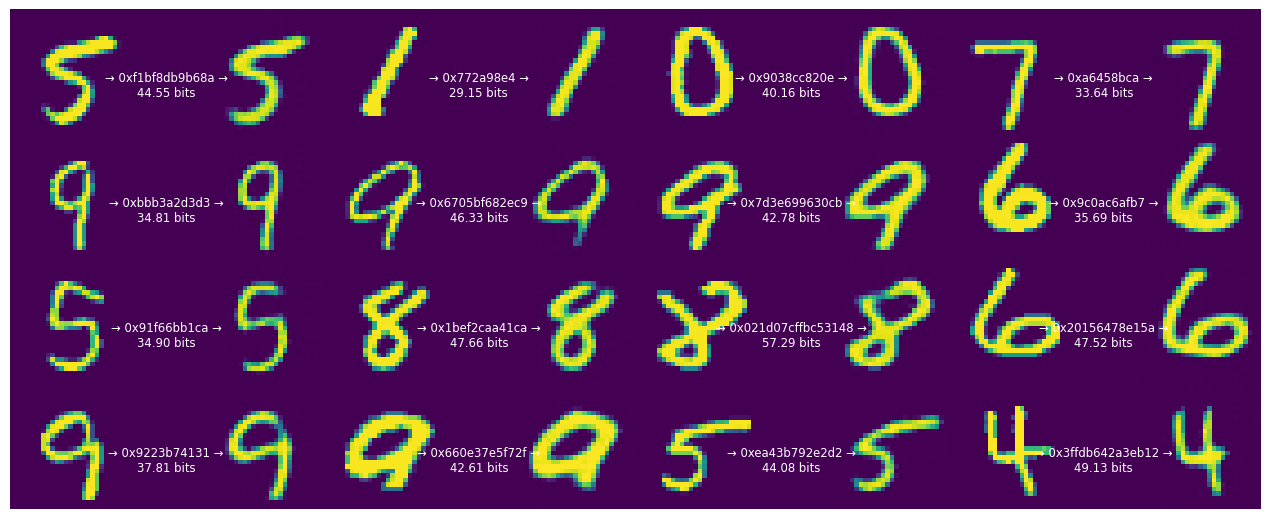

In [24]:
display_digits(originals, strings, entropies, reconstructions)


Note that the length of the encoded string differs from the information content of each digit.

This is because the range coding process works with discrete probabilities, and has a small amount of overhead. So, especially for short strings, the correspondence is only approximate. However, range coding is **asymptotically optimal**: in the limit, the expected bit count will approach the cross entropy (the expected information content), for which the rate term in the training model is an upper bound.

## The rate–distortion trade-off

Above, the model was trained for a specific trade-off (given by `lmbda=2000`) between the average number of bits used to represent each digit and the incurred error in the reconstruction.

What happens when we repeat the experiment with different values?

Let's start by reducing $\lambda$ to 500.

Epoch 1/15


  1/469 [..............................] - ETA: 23:35 - loss: 164.9753 - distortion_loss: 0.1241 - rate_loss: 102.9198 - distortion_pass_through_loss: 0.1241 - rate_pass_through_loss: 102.9198

 10/469 [..............................] - ETA: 2s - loss: 168.6673 - distortion_loss: 0.1321 - rate_loss: 102.6114 - distortion_pass_through_loss: 0.1321 - rate_pass_through_loss: 102.6114   

 20/469 [>.............................] - ETA: 2s - loss: 167.4041 - distortion_loss: 0.1302 - rate_loss: 102.3162 - distortion_pass_through_loss: 0.1302 - rate_pass_through_loss: 102.3162

 30/469 [>.............................] - ETA: 2s - loss: 166.2258 - distortion_loss: 0.1284 - rate_loss: 102.0393 - distortion_pass_through_loss: 0.1284 - rate_pass_through_loss: 102.0393

 40/469 [=>............................] - ETA: 2s - loss: 164.7385 - distortion_loss: 0.1260 - rate_loss: 101.7608 - distortion_pass_through_loss: 0.1260 - rate_pass_through_loss: 101.7608

 50/469 [==>...........................] - ETA: 2s - loss: 163.2472 - distortion_loss: 0.1233 - rate_loss: 101.5962 - distortion_pass_through_loss: 0.1233 - rate_pass_through_loss: 101.5962

 60/469 [==>...........................] - ETA: 2s - loss: 161.3219 - distortion_loss: 0.1197 - rate_loss: 101.4681 - distortion_pass_through_loss: 0.1197 - rate_pass_through_loss: 101.4681

 70/469 [===>..........................] - ETA: 2s - loss: 159.3922 - distortion_loss: 0.1162 - rate_loss: 101.3001 - distortion_pass_through_loss: 0.1162 - rate_pass_through_loss: 101.3001

 80/469 [====>.........................] - ETA: 2s - loss: 157.4172 - distortion_loss: 0.1125 - rate_loss: 101.1513 - distortion_pass_through_loss: 0.1125 - rate_pass_through_loss: 101.1513

 90/469 [====>.........................] - ETA: 2s - loss: 155.6206 - distortion_loss: 0.1092 - rate_loss: 100.9992 - distortion_pass_through_loss: 0.1092 - rate_pass_through_loss: 100.9992

100/469 [=====>........................] - ETA: 1s - loss: 153.9486 - distortion_loss: 0.1062 - rate_loss: 100.8490 - distortion_pass_through_loss: 0.1062 - rate_pass_through_loss: 100.8490

110/469 [======>.......................] - ETA: 1s - loss: 152.3896 - distortion_loss: 0.1034 - rate_loss: 100.6821 - distortion_pass_through_loss: 0.1034 - rate_pass_through_loss: 100.6821

120/469 [======>.......................] - ETA: 1s - loss: 150.9841 - distortion_loss: 0.1010 - rate_loss: 100.5084 - distortion_pass_through_loss: 0.1010 - rate_pass_through_loss: 100.5084

130/469 [=======>......................] - ETA: 1s - loss: 149.6166 - distortion_loss: 0.0986 - rate_loss: 100.3309 - distortion_pass_through_loss: 0.0986 - rate_pass_through_loss: 100.3309

140/469 [=======>......................] - ETA: 1s - loss: 148.3672 - distortion_loss: 0.0964 - rate_loss: 100.1468 - distortion_pass_through_loss: 0.0964 - rate_pass_through_loss: 100.1468

149/469 [========>.....................] - ETA: 1s - loss: 147.3402 - distortion_loss: 0.0947 - rate_loss: 99.9763 - distortion_pass_through_loss: 0.0947 - rate_pass_through_loss: 99.9763  

159/469 [=========>....................] - ETA: 1s - loss: 146.2935 - distortion_loss: 0.0930 - rate_loss: 99.7908 - distortion_pass_through_loss: 0.0930 - rate_pass_through_loss: 99.7908

169/469 [=========>....................] - ETA: 1s - loss: 145.2740 - distortion_loss: 0.0914 - rate_loss: 99.5888 - distortion_pass_through_loss: 0.0914 - rate_pass_through_loss: 99.5888

179/469 [==========>...................] - ETA: 1s - loss: 144.3229 - distortion_loss: 0.0899 - rate_loss: 99.3906 - distortion_pass_through_loss: 0.0899 - rate_pass_through_loss: 99.3906

189/469 [===========>..................] - ETA: 1s - loss: 143.4050 - distortion_loss: 0.0884 - rate_loss: 99.1885 - distortion_pass_through_loss: 0.0884 - rate_pass_through_loss: 99.1885

199/469 [===========>..................] - ETA: 1s - loss: 142.5311 - distortion_loss: 0.0871 - rate_loss: 98.9786 - distortion_pass_through_loss: 0.0871 - rate_pass_through_loss: 98.9786

209/469 [============>.................] - ETA: 1s - loss: 141.6823 - distortion_loss: 0.0858 - rate_loss: 98.7665 - distortion_pass_through_loss: 0.0858 - rate_pass_through_loss: 98.7665

219/469 [=============>................] - ETA: 1s - loss: 140.8789 - distortion_loss: 0.0847 - rate_loss: 98.5482 - distortion_pass_through_loss: 0.0847 - rate_pass_through_loss: 98.5482

229/469 [=============>................] - ETA: 1s - loss: 140.1207 - distortion_loss: 0.0836 - rate_loss: 98.3270 - distortion_pass_through_loss: 0.0836 - rate_pass_through_loss: 98.3270

239/469 [==============>...............] - ETA: 1s - loss: 139.3961 - distortion_loss: 0.0826 - rate_loss: 98.1044 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 98.1044

249/469 [==============>...............] - ETA: 1s - loss: 138.7032 - distortion_loss: 0.0817 - rate_loss: 97.8779 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 97.8779

259/469 [===============>..............] - ETA: 1s - loss: 138.0151 - distortion_loss: 0.0807 - rate_loss: 97.6522 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 97.6522

269/469 [================>.............] - ETA: 1s - loss: 137.3561 - distortion_loss: 0.0799 - rate_loss: 97.4261 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 97.4261

279/469 [================>.............] - ETA: 1s - loss: 136.7238 - distortion_loss: 0.0791 - rate_loss: 97.1929 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 97.1929

289/469 [=================>............] - ETA: 0s - loss: 136.1207 - distortion_loss: 0.0783 - rate_loss: 96.9620 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 96.9620

299/469 [==================>...........] - ETA: 0s - loss: 135.5021 - distortion_loss: 0.0775 - rate_loss: 96.7286 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 96.7286

309/469 [==================>...........] - ETA: 0s - loss: 134.9246 - distortion_loss: 0.0769 - rate_loss: 96.4905 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 96.4905

319/469 [===================>..........] - ETA: 0s - loss: 134.3586 - distortion_loss: 0.0762 - rate_loss: 96.2541 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 96.2541

329/469 [====================>.........] - ETA: 0s - loss: 133.8134 - distortion_loss: 0.0756 - rate_loss: 96.0166 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 96.0166

339/469 [====================>.........] - ETA: 0s - loss: 133.2696 - distortion_loss: 0.0750 - rate_loss: 95.7793 - distortion_pass_through_loss: 0.0750 - rate_pass_through_loss: 95.7793

349/469 [=====================>........] - ETA: 0s - loss: 132.7417 - distortion_loss: 0.0744 - rate_loss: 95.5383 - distortion_pass_through_loss: 0.0744 - rate_pass_through_loss: 95.5383

359/469 [=====================>........] - ETA: 0s - loss: 132.2291 - distortion_loss: 0.0739 - rate_loss: 95.2941 - distortion_pass_through_loss: 0.0739 - rate_pass_through_loss: 95.2941

369/469 [======================>.......] - ETA: 0s - loss: 131.7341 - distortion_loss: 0.0734 - rate_loss: 95.0529 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 95.0529

379/469 [=======================>......] - ETA: 0s - loss: 131.2372 - distortion_loss: 0.0729 - rate_loss: 94.8107 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 94.8107

389/469 [=======================>......] - ETA: 0s - loss: 130.7546 - distortion_loss: 0.0724 - rate_loss: 94.5673 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 94.5673

399/469 [========================>.....] - ETA: 0s - loss: 130.2716 - distortion_loss: 0.0719 - rate_loss: 94.3214 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 94.3214

409/469 [=========================>....] - ETA: 0s - loss: 129.8000 - distortion_loss: 0.0714 - rate_loss: 94.0751 - distortion_pass_through_loss: 0.0714 - rate_pass_through_loss: 94.0751

419/469 [=========================>....] - ETA: 0s - loss: 129.3474 - distortion_loss: 0.0710 - rate_loss: 93.8304 - distortion_pass_through_loss: 0.0710 - rate_pass_through_loss: 93.8304

429/469 [==========================>...] - ETA: 0s - loss: 128.9011 - distortion_loss: 0.0706 - rate_loss: 93.5841 - distortion_pass_through_loss: 0.0706 - rate_pass_through_loss: 93.5841

439/469 [===========================>..] - ETA: 0s - loss: 128.4589 - distortion_loss: 0.0702 - rate_loss: 93.3367 - distortion_pass_through_loss: 0.0702 - rate_pass_through_loss: 93.3367

449/469 [===========================>..] - ETA: 0s - loss: 128.0315 - distortion_loss: 0.0699 - rate_loss: 93.0893 - distortion_pass_through_loss: 0.0699 - rate_pass_through_loss: 93.0893

459/469 [============================>.] - ETA: 0s - loss: 127.6049 - distortion_loss: 0.0695 - rate_loss: 92.8451 - distortion_pass_through_loss: 0.0695 - rate_pass_through_loss: 92.8451

469/469 [==============================] - ETA: 0s - loss: 127.2007 - distortion_loss: 0.0692 - rate_loss: 92.6042 - distortion_pass_through_loss: 0.0692 - rate_pass_through_loss: 92.5979

469/469 [==============================] - 6s 6ms/step - loss: 127.2007 - distortion_loss: 0.0692 - rate_loss: 92.6042 - distortion_pass_through_loss: 0.0692 - rate_pass_through_loss: 92.5979 - val_loss: 107.4194 - val_distortion_loss: 0.0551 - val_rate_loss: 79.8726 - val_distortion_pass_through_loss: 0.0551 - val_rate_pass_through_loss: 79.8679


Epoch 2/15


  1/469 [..............................] - ETA: 4s - loss: 105.7503 - distortion_loss: 0.0499 - rate_loss: 80.7845 - distortion_pass_through_loss: 0.0499 - rate_pass_through_loss: 80.7845

 11/469 [..............................] - ETA: 2s - loss: 107.4799 - distortion_loss: 0.0537 - rate_loss: 80.6446 - distortion_pass_through_loss: 0.0537 - rate_pass_through_loss: 80.6446

 21/469 [>.............................] - ETA: 2s - loss: 107.3234 - distortion_loss: 0.0538 - rate_loss: 80.4418 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 80.4418

 31/469 [>.............................] - ETA: 2s - loss: 107.0710 - distortion_loss: 0.0537 - rate_loss: 80.2197 - distortion_pass_through_loss: 0.0537 - rate_pass_through_loss: 80.2197

 41/469 [=>............................] - ETA: 2s - loss: 106.7454 - distortion_loss: 0.0535 - rate_loss: 79.9732 - distortion_pass_through_loss: 0.0535 - rate_pass_through_loss: 79.9732

 51/469 [==>...........................] - ETA: 2s - loss: 106.5274 - distortion_loss: 0.0536 - rate_loss: 79.7257 - distortion_pass_through_loss: 0.0536 - rate_pass_through_loss: 79.7257

 60/469 [==>...........................] - ETA: 2s - loss: 106.2534 - distortion_loss: 0.0535 - rate_loss: 79.5087 - distortion_pass_through_loss: 0.0535 - rate_pass_through_loss: 79.5087

 69/469 [===>..........................] - ETA: 2s - loss: 106.0685 - distortion_loss: 0.0535 - rate_loss: 79.3169 - distortion_pass_through_loss: 0.0535 - rate_pass_through_loss: 79.3169

 78/469 [===>..........................] - ETA: 2s - loss: 105.7581 - distortion_loss: 0.0534 - rate_loss: 79.0787 - distortion_pass_through_loss: 0.0534 - rate_pass_through_loss: 79.0787

 87/469 [====>.........................] - ETA: 2s - loss: 105.5106 - distortion_loss: 0.0532 - rate_loss: 78.8864 - distortion_pass_through_loss: 0.0532 - rate_pass_through_loss: 78.8864

 96/469 [=====>........................] - ETA: 2s - loss: 105.2414 - distortion_loss: 0.0532 - rate_loss: 78.6356 - distortion_pass_through_loss: 0.0532 - rate_pass_through_loss: 78.6356

106/469 [=====>........................] - ETA: 1s - loss: 104.9612 - distortion_loss: 0.0531 - rate_loss: 78.3995 - distortion_pass_through_loss: 0.0531 - rate_pass_through_loss: 78.3995

115/469 [======>.......................] - ETA: 1s - loss: 104.7542 - distortion_loss: 0.0531 - rate_loss: 78.1861 - distortion_pass_through_loss: 0.0531 - rate_pass_through_loss: 78.1861

125/469 [======>.......................] - ETA: 1s - loss: 104.4542 - distortion_loss: 0.0530 - rate_loss: 77.9373 - distortion_pass_through_loss: 0.0530 - rate_pass_through_loss: 77.9373

135/469 [=======>......................] - ETA: 1s - loss: 104.1775 - distortion_loss: 0.0530 - rate_loss: 77.6860 - distortion_pass_through_loss: 0.0530 - rate_pass_through_loss: 77.6860

145/469 [========>.....................] - ETA: 1s - loss: 103.9167 - distortion_loss: 0.0529 - rate_loss: 77.4519 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 77.4519

155/469 [========>.....................] - ETA: 1s - loss: 103.6812 - distortion_loss: 0.0529 - rate_loss: 77.2217 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 77.2217

165/469 [=========>....................] - ETA: 1s - loss: 103.4523 - distortion_loss: 0.0529 - rate_loss: 76.9898 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 76.9898

175/469 [==========>...................] - ETA: 1s - loss: 103.2095 - distortion_loss: 0.0529 - rate_loss: 76.7471 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 76.7471

184/469 [==========>...................] - ETA: 1s - loss: 102.9998 - distortion_loss: 0.0529 - rate_loss: 76.5474 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 76.5474

194/469 [===========>..................] - ETA: 1s - loss: 102.7718 - distortion_loss: 0.0529 - rate_loss: 76.3167 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 76.3167

203/469 [===========>..................] - ETA: 1s - loss: 102.5452 - distortion_loss: 0.0529 - rate_loss: 76.1071 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 76.1071

213/469 [============>.................] - ETA: 1s - loss: 102.2884 - distortion_loss: 0.0528 - rate_loss: 75.8750 - distortion_pass_through_loss: 0.0528 - rate_pass_through_loss: 75.8750

222/469 [=============>................] - ETA: 1s - loss: 102.0789 - distortion_loss: 0.0528 - rate_loss: 75.6700 - distortion_pass_through_loss: 0.0528 - rate_pass_through_loss: 75.6700

232/469 [=============>................] - ETA: 1s - loss: 101.8536 - distortion_loss: 0.0528 - rate_loss: 75.4424 - distortion_pass_through_loss: 0.0528 - rate_pass_through_loss: 75.4424

241/469 [==============>...............] - ETA: 1s - loss: 101.6462 - distortion_loss: 0.0528 - rate_loss: 75.2306 - distortion_pass_through_loss: 0.0528 - rate_pass_through_loss: 75.2306

251/469 [===============>..............] - ETA: 1s - loss: 101.4330 - distortion_loss: 0.0529 - rate_loss: 75.0034 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 75.0034

261/469 [===============>..............] - ETA: 1s - loss: 101.2137 - distortion_loss: 0.0529 - rate_loss: 74.7849 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 74.7849

271/469 [================>.............] - ETA: 1s - loss: 100.9860 - distortion_loss: 0.0529 - rate_loss: 74.5550 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 74.5550

281/469 [================>.............] - ETA: 1s - loss: 100.7735 - distortion_loss: 0.0529 - rate_loss: 74.3335 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 74.3335

291/469 [=================>............] - ETA: 0s - loss: 100.5619 - distortion_loss: 0.0529 - rate_loss: 74.1151 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 74.1151

301/469 [==================>...........] - ETA: 0s - loss: 100.3288 - distortion_loss: 0.0529 - rate_loss: 73.8893 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 73.8893

311/469 [==================>...........] - ETA: 0s - loss: 100.1036 - distortion_loss: 0.0529 - rate_loss: 73.6687 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 73.6687

321/469 [===================>..........] - ETA: 0s - loss: 99.8863 - distortion_loss: 0.0529 - rate_loss: 73.4486 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 73.4486 

331/469 [====================>.........] - ETA: 0s - loss: 99.6692 - distortion_loss: 0.0529 - rate_loss: 73.2227 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 73.2227

341/469 [====================>.........] - ETA: 0s - loss: 99.4593 - distortion_loss: 0.0529 - rate_loss: 73.0100 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 73.0100

351/469 [=====================>........] - ETA: 0s - loss: 99.2468 - distortion_loss: 0.0529 - rate_loss: 72.7907 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 72.7907

361/469 [======================>.......] - ETA: 0s - loss: 99.0323 - distortion_loss: 0.0529 - rate_loss: 72.5748 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 72.5748

371/469 [======================>.......] - ETA: 0s - loss: 98.8290 - distortion_loss: 0.0529 - rate_loss: 72.3630 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 72.3630

381/469 [=======================>......] - ETA: 0s - loss: 98.6215 - distortion_loss: 0.0529 - rate_loss: 72.1479 - distortion_pass_through_loss: 0.0529 - rate_pass_through_loss: 72.1479

391/469 [========================>.....] - ETA: 0s - loss: 98.4140 - distortion_loss: 0.0530 - rate_loss: 71.9341 - distortion_pass_through_loss: 0.0530 - rate_pass_through_loss: 71.9341

401/469 [========================>.....] - ETA: 0s - loss: 98.2061 - distortion_loss: 0.0530 - rate_loss: 71.7196 - distortion_pass_through_loss: 0.0530 - rate_pass_through_loss: 71.7196

411/469 [=========================>....] - ETA: 0s - loss: 97.9950 - distortion_loss: 0.0530 - rate_loss: 71.5032 - distortion_pass_through_loss: 0.0530 - rate_pass_through_loss: 71.5032

421/469 [=========================>....] - ETA: 0s - loss: 97.7857 - distortion_loss: 0.0530 - rate_loss: 71.2927 - distortion_pass_through_loss: 0.0530 - rate_pass_through_loss: 71.2927

431/469 [==========================>...] - ETA: 0s - loss: 97.5828 - distortion_loss: 0.0530 - rate_loss: 71.0839 - distortion_pass_through_loss: 0.0530 - rate_pass_through_loss: 71.0839

441/469 [===========================>..] - ETA: 0s - loss: 97.3820 - distortion_loss: 0.0530 - rate_loss: 70.8740 - distortion_pass_through_loss: 0.0530 - rate_pass_through_loss: 70.8740

451/469 [===========================>..] - ETA: 0s - loss: 97.1759 - distortion_loss: 0.0530 - rate_loss: 70.6657 - distortion_pass_through_loss: 0.0530 - rate_pass_through_loss: 70.6657

461/469 [============================>.] - ETA: 0s - loss: 96.9798 - distortion_loss: 0.0530 - rate_loss: 70.4586 - distortion_pass_through_loss: 0.0530 - rate_pass_through_loss: 70.4586

469/469 [==============================] - 3s 6ms/step - loss: 96.8240 - distortion_loss: 0.0531 - rate_loss: 70.2980 - distortion_pass_through_loss: 0.0531 - rate_pass_through_loss: 70.2927 - val_loss: 85.7780 - val_distortion_loss: 0.0592 - val_rate_loss: 56.1755 - val_distortion_pass_through_loss: 0.0592 - val_rate_pass_through_loss: 56.1824


Epoch 3/15


  1/469 [..............................] - ETA: 4s - loss: 86.3611 - distortion_loss: 0.0513 - rate_loss: 60.7110 - distortion_pass_through_loss: 0.0513 - rate_pass_through_loss: 60.7110

 10/469 [..............................] - ETA: 2s - loss: 87.6957 - distortion_loss: 0.0542 - rate_loss: 60.5876 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 60.5876

 19/469 [>.............................] - ETA: 2s - loss: 87.3226 - distortion_loss: 0.0540 - rate_loss: 60.3363 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 60.3363

 29/469 [>.............................] - ETA: 2s - loss: 87.3154 - distortion_loss: 0.0544 - rate_loss: 60.0993 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 60.0993

 39/469 [=>............................] - ETA: 2s - loss: 87.0714 - distortion_loss: 0.0543 - rate_loss: 59.9316 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 59.9316

 49/469 [==>...........................] - ETA: 2s - loss: 86.9603 - distortion_loss: 0.0544 - rate_loss: 59.7507 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 59.7507

 59/469 [==>...........................] - ETA: 2s - loss: 86.8291 - distortion_loss: 0.0544 - rate_loss: 59.6070 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 59.6070

 69/469 [===>..........................] - ETA: 2s - loss: 86.7289 - distortion_loss: 0.0546 - rate_loss: 59.4379 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 59.4379

 78/469 [===>..........................] - ETA: 2s - loss: 86.5254 - distortion_loss: 0.0545 - rate_loss: 59.2913 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 59.2913

 87/469 [====>.........................] - ETA: 2s - loss: 86.3657 - distortion_loss: 0.0545 - rate_loss: 59.1295 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 59.1295

 97/469 [=====>........................] - ETA: 2s - loss: 86.1374 - distortion_loss: 0.0544 - rate_loss: 58.9472 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 58.9472

107/469 [=====>........................] - ETA: 1s - loss: 85.9751 - distortion_loss: 0.0544 - rate_loss: 58.7677 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 58.7677

117/469 [======>.......................] - ETA: 1s - loss: 85.8123 - distortion_loss: 0.0544 - rate_loss: 58.6058 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 58.6058

127/469 [=======>......................] - ETA: 1s - loss: 85.6126 - distortion_loss: 0.0544 - rate_loss: 58.4259 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 58.4259

137/469 [=======>......................] - ETA: 1s - loss: 85.4076 - distortion_loss: 0.0543 - rate_loss: 58.2424 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 58.2424

147/469 [========>.....................] - ETA: 1s - loss: 85.2608 - distortion_loss: 0.0544 - rate_loss: 58.0795 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 58.0795

157/469 [=========>....................] - ETA: 1s - loss: 85.1361 - distortion_loss: 0.0544 - rate_loss: 57.9210 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 57.9210

167/469 [=========>....................] - ETA: 1s - loss: 84.9839 - distortion_loss: 0.0545 - rate_loss: 57.7436 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 57.7436

177/469 [==========>...................] - ETA: 1s - loss: 84.8357 - distortion_loss: 0.0545 - rate_loss: 57.5779 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 57.5779

187/469 [==========>...................] - ETA: 1s - loss: 84.6842 - distortion_loss: 0.0545 - rate_loss: 57.4148 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 57.4148

197/469 [===========>..................] - ETA: 1s - loss: 84.5471 - distortion_loss: 0.0546 - rate_loss: 57.2576 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 57.2576

207/469 [============>.................] - ETA: 1s - loss: 84.3844 - distortion_loss: 0.0546 - rate_loss: 57.0903 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 57.0903

217/469 [============>.................] - ETA: 1s - loss: 84.2028 - distortion_loss: 0.0546 - rate_loss: 56.9245 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 56.9245

227/469 [=============>................] - ETA: 1s - loss: 84.0586 - distortion_loss: 0.0546 - rate_loss: 56.7709 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 56.7709

237/469 [==============>...............] - ETA: 1s - loss: 83.9240 - distortion_loss: 0.0546 - rate_loss: 56.6101 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 56.6101

247/469 [==============>...............] - ETA: 1s - loss: 83.7828 - distortion_loss: 0.0547 - rate_loss: 56.4444 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 56.4444

257/469 [===============>..............] - ETA: 1s - loss: 83.6448 - distortion_loss: 0.0547 - rate_loss: 56.2926 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 56.2926

267/469 [================>.............] - ETA: 1s - loss: 83.5072 - distortion_loss: 0.0547 - rate_loss: 56.1358 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 56.1358

277/469 [================>.............] - ETA: 1s - loss: 83.3703 - distortion_loss: 0.0548 - rate_loss: 55.9757 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 55.9757

287/469 [=================>............] - ETA: 0s - loss: 83.2345 - distortion_loss: 0.0548 - rate_loss: 55.8302 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 55.8302

297/469 [=================>............] - ETA: 0s - loss: 83.0826 - distortion_loss: 0.0548 - rate_loss: 55.6739 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 55.6739

307/469 [==================>...........] - ETA: 0s - loss: 82.9476 - distortion_loss: 0.0548 - rate_loss: 55.5255 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 55.5255

317/469 [===================>..........] - ETA: 0s - loss: 82.8211 - distortion_loss: 0.0549 - rate_loss: 55.3709 - distortion_pass_through_loss: 0.0549 - rate_pass_through_loss: 55.3709

327/469 [===================>..........] - ETA: 0s - loss: 82.6834 - distortion_loss: 0.0549 - rate_loss: 55.2180 - distortion_pass_through_loss: 0.0549 - rate_pass_through_loss: 55.2180

337/469 [====================>.........] - ETA: 0s - loss: 82.5519 - distortion_loss: 0.0550 - rate_loss: 55.0715 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 55.0715

347/469 [=====================>........] - ETA: 0s - loss: 82.4143 - distortion_loss: 0.0550 - rate_loss: 54.9240 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 54.9240

357/469 [=====================>........] - ETA: 0s - loss: 82.2848 - distortion_loss: 0.0550 - rate_loss: 54.7769 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 54.7769

367/469 [======================>.......] - ETA: 0s - loss: 82.1613 - distortion_loss: 0.0551 - rate_loss: 54.6256 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 54.6256

377/469 [=======================>......] - ETA: 0s - loss: 82.0329 - distortion_loss: 0.0551 - rate_loss: 54.4801 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 54.4801

387/469 [=======================>......] - ETA: 0s - loss: 81.9016 - distortion_loss: 0.0551 - rate_loss: 54.3323 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 54.3323

397/469 [========================>.....] - ETA: 0s - loss: 81.7721 - distortion_loss: 0.0552 - rate_loss: 54.1898 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 54.1898

407/469 [=========================>....] - ETA: 0s - loss: 81.6308 - distortion_loss: 0.0552 - rate_loss: 54.0427 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 54.0427

417/469 [=========================>....] - ETA: 0s - loss: 81.5150 - distortion_loss: 0.0552 - rate_loss: 53.9019 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 53.9019

426/469 [==========================>...] - ETA: 0s - loss: 81.4041 - distortion_loss: 0.0553 - rate_loss: 53.7751 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 53.7751

436/469 [==========================>...] - ETA: 0s - loss: 81.2770 - distortion_loss: 0.0553 - rate_loss: 53.6314 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 53.6314

446/469 [===========================>..] - ETA: 0s - loss: 81.1602 - distortion_loss: 0.0553 - rate_loss: 53.4942 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 53.4942

456/469 [============================>.] - ETA: 0s - loss: 81.0377 - distortion_loss: 0.0554 - rate_loss: 53.3505 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 53.3505

466/469 [============================>.] - ETA: 0s - loss: 80.9269 - distortion_loss: 0.0554 - rate_loss: 53.2149 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 53.2149

469/469 [==============================] - 3s 6ms/step - loss: 80.8893 - distortion_loss: 0.0554 - rate_loss: 53.1807 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 53.1775 - val_loss: 71.8758 - val_distortion_loss: 0.0688 - val_rate_loss: 37.4832 - val_distortion_pass_through_loss: 0.0688 - val_rate_pass_through_loss: 37.4903


Epoch 4/15


  1/469 [..............................] - ETA: 4s - loss: 72.9183 - distortion_loss: 0.0528 - rate_loss: 46.5380 - distortion_pass_through_loss: 0.0528 - rate_pass_through_loss: 46.5380

 10/469 [..............................] - ETA: 2s - loss: 75.4317 - distortion_loss: 0.0575 - rate_loss: 46.6742 - distortion_pass_through_loss: 0.0575 - rate_pass_through_loss: 46.6742

 20/469 [>.............................] - ETA: 2s - loss: 75.1383 - distortion_loss: 0.0573 - rate_loss: 46.4668 - distortion_pass_through_loss: 0.0573 - rate_pass_through_loss: 46.4668

 29/469 [>.............................] - ETA: 2s - loss: 75.1896 - distortion_loss: 0.0576 - rate_loss: 46.3991 - distortion_pass_through_loss: 0.0576 - rate_pass_through_loss: 46.3991

 39/469 [=>............................] - ETA: 2s - loss: 74.9815 - distortion_loss: 0.0575 - rate_loss: 46.2341 - distortion_pass_through_loss: 0.0575 - rate_pass_through_loss: 46.2341

 49/469 [==>...........................] - ETA: 2s - loss: 74.8720 - distortion_loss: 0.0575 - rate_loss: 46.1095 - distortion_pass_through_loss: 0.0575 - rate_pass_through_loss: 46.1095

 59/469 [==>...........................] - ETA: 2s - loss: 74.7534 - distortion_loss: 0.0575 - rate_loss: 46.0101 - distortion_pass_through_loss: 0.0575 - rate_pass_through_loss: 46.0101

 69/469 [===>..........................] - ETA: 2s - loss: 74.7237 - distortion_loss: 0.0576 - rate_loss: 45.9192 - distortion_pass_through_loss: 0.0576 - rate_pass_through_loss: 45.9192

 79/469 [====>.........................] - ETA: 2s - loss: 74.5708 - distortion_loss: 0.0575 - rate_loss: 45.8110 - distortion_pass_through_loss: 0.0575 - rate_pass_through_loss: 45.8110

 89/469 [====>.........................] - ETA: 2s - loss: 74.4495 - distortion_loss: 0.0575 - rate_loss: 45.6986 - distortion_pass_through_loss: 0.0575 - rate_pass_through_loss: 45.6986

 99/469 [=====>........................] - ETA: 2s - loss: 74.3091 - distortion_loss: 0.0575 - rate_loss: 45.5814 - distortion_pass_through_loss: 0.0575 - rate_pass_through_loss: 45.5814

109/469 [=====>........................] - ETA: 1s - loss: 74.1694 - distortion_loss: 0.0574 - rate_loss: 45.4576 - distortion_pass_through_loss: 0.0574 - rate_pass_through_loss: 45.4576

119/469 [======>.......................] - ETA: 1s - loss: 74.1086 - distortion_loss: 0.0575 - rate_loss: 45.3568 - distortion_pass_through_loss: 0.0575 - rate_pass_through_loss: 45.3568

129/469 [=======>......................] - ETA: 1s - loss: 73.9764 - distortion_loss: 0.0575 - rate_loss: 45.2378 - distortion_pass_through_loss: 0.0575 - rate_pass_through_loss: 45.2378

139/469 [=======>......................] - ETA: 1s - loss: 73.8514 - distortion_loss: 0.0575 - rate_loss: 45.1181 - distortion_pass_through_loss: 0.0575 - rate_pass_through_loss: 45.1181

149/469 [========>.....................] - ETA: 1s - loss: 73.7472 - distortion_loss: 0.0575 - rate_loss: 45.0015 - distortion_pass_through_loss: 0.0575 - rate_pass_through_loss: 45.0015

159/469 [=========>....................] - ETA: 1s - loss: 73.6787 - distortion_loss: 0.0575 - rate_loss: 44.9158 - distortion_pass_through_loss: 0.0575 - rate_pass_through_loss: 44.9158

168/469 [=========>....................] - ETA: 1s - loss: 73.5950 - distortion_loss: 0.0576 - rate_loss: 44.8094 - distortion_pass_through_loss: 0.0576 - rate_pass_through_loss: 44.8094

177/469 [==========>...................] - ETA: 1s - loss: 73.5288 - distortion_loss: 0.0576 - rate_loss: 44.7212 - distortion_pass_through_loss: 0.0576 - rate_pass_through_loss: 44.7212

187/469 [==========>...................] - ETA: 1s - loss: 73.4644 - distortion_loss: 0.0577 - rate_loss: 44.6279 - distortion_pass_through_loss: 0.0577 - rate_pass_through_loss: 44.6279

197/469 [===========>..................] - ETA: 1s - loss: 73.3799 - distortion_loss: 0.0577 - rate_loss: 44.5202 - distortion_pass_through_loss: 0.0577 - rate_pass_through_loss: 44.5202

207/469 [============>.................] - ETA: 1s - loss: 73.2921 - distortion_loss: 0.0578 - rate_loss: 44.4129 - distortion_pass_through_loss: 0.0578 - rate_pass_through_loss: 44.4129

217/469 [============>.................] - ETA: 1s - loss: 73.1830 - distortion_loss: 0.0577 - rate_loss: 44.3120 - distortion_pass_through_loss: 0.0577 - rate_pass_through_loss: 44.3120

227/469 [=============>................] - ETA: 1s - loss: 73.0907 - distortion_loss: 0.0578 - rate_loss: 44.2134 - distortion_pass_through_loss: 0.0578 - rate_pass_through_loss: 44.2134

236/469 [==============>...............] - ETA: 1s - loss: 73.0266 - distortion_loss: 0.0578 - rate_loss: 44.1207 - distortion_pass_through_loss: 0.0578 - rate_pass_through_loss: 44.1207

246/469 [==============>...............] - ETA: 1s - loss: 72.9511 - distortion_loss: 0.0579 - rate_loss: 44.0242 - distortion_pass_through_loss: 0.0579 - rate_pass_through_loss: 44.0242

256/469 [===============>..............] - ETA: 1s - loss: 72.8722 - distortion_loss: 0.0579 - rate_loss: 43.9266 - distortion_pass_through_loss: 0.0579 - rate_pass_through_loss: 43.9266

266/469 [================>.............] - ETA: 1s - loss: 72.7885 - distortion_loss: 0.0579 - rate_loss: 43.8260 - distortion_pass_through_loss: 0.0579 - rate_pass_through_loss: 43.8260

276/469 [================>.............] - ETA: 1s - loss: 72.7024 - distortion_loss: 0.0580 - rate_loss: 43.7242 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 43.7242

286/469 [=================>............] - ETA: 0s - loss: 72.6303 - distortion_loss: 0.0580 - rate_loss: 43.6271 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 43.6271

296/469 [=================>............] - ETA: 0s - loss: 72.5292 - distortion_loss: 0.0580 - rate_loss: 43.5320 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 43.5320

306/469 [==================>...........] - ETA: 0s - loss: 72.4455 - distortion_loss: 0.0580 - rate_loss: 43.4295 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 43.4295

316/469 [===================>..........] - ETA: 0s - loss: 72.3735 - distortion_loss: 0.0581 - rate_loss: 43.3320 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 43.3320

326/469 [===================>..........] - ETA: 0s - loss: 72.3014 - distortion_loss: 0.0581 - rate_loss: 43.2393 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 43.2393

336/469 [====================>.........] - ETA: 0s - loss: 72.2258 - distortion_loss: 0.0582 - rate_loss: 43.1481 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 43.1481

346/469 [=====================>........] - ETA: 0s - loss: 72.1363 - distortion_loss: 0.0582 - rate_loss: 43.0516 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 43.0516

356/469 [=====================>........] - ETA: 0s - loss: 72.0600 - distortion_loss: 0.0582 - rate_loss: 42.9615 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 42.9615

366/469 [======================>.......] - ETA: 0s - loss: 71.9905 - distortion_loss: 0.0582 - rate_loss: 42.8688 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 42.8688

375/469 [======================>.......] - ETA: 0s - loss: 71.9200 - distortion_loss: 0.0583 - rate_loss: 42.7852 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 42.7852

385/469 [=======================>......] - ETA: 0s - loss: 71.8407 - distortion_loss: 0.0583 - rate_loss: 42.6861 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 42.6861

395/469 [========================>.....] - ETA: 0s - loss: 71.7690 - distortion_loss: 0.0583 - rate_loss: 42.5942 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 42.5942

405/469 [========================>.....] - ETA: 0s - loss: 71.6891 - distortion_loss: 0.0584 - rate_loss: 42.5024 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 42.5024

415/469 [=========================>....] - ETA: 0s - loss: 71.6194 - distortion_loss: 0.0584 - rate_loss: 42.4119 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 42.4119

425/469 [==========================>...] - ETA: 0s - loss: 71.5421 - distortion_loss: 0.0584 - rate_loss: 42.3236 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 42.3236

435/469 [==========================>...] - ETA: 0s - loss: 71.4705 - distortion_loss: 0.0585 - rate_loss: 42.2362 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 42.2362

444/469 [===========================>..] - ETA: 0s - loss: 71.4027 - distortion_loss: 0.0585 - rate_loss: 42.1548 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 42.1548

454/469 [============================>.] - ETA: 0s - loss: 71.3316 - distortion_loss: 0.0585 - rate_loss: 42.0632 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 42.0632

464/469 [============================>.] - ETA: 0s - loss: 71.2734 - distortion_loss: 0.0586 - rate_loss: 41.9840 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 41.9840

469/469 [==============================] - 3s 6ms/step - loss: 71.2341 - distortion_loss: 0.0586 - rate_loss: 41.9420 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 41.9394 - val_loss: 63.1903 - val_distortion_loss: 0.0765 - val_rate_loss: 24.9508 - val_distortion_pass_through_loss: 0.0765 - val_rate_pass_through_loss: 24.9612


Epoch 5/15


  1/469 [..............................] - ETA: 4s - loss: 65.5480 - distortion_loss: 0.0568 - rate_loss: 37.1443 - distortion_pass_through_loss: 0.0568 - rate_pass_through_loss: 37.1443

 10/469 [..............................] - ETA: 2s - loss: 68.0614 - distortion_loss: 0.0606 - rate_loss: 37.7806 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 37.7806

 19/469 [>.............................] - ETA: 2s - loss: 67.8979 - distortion_loss: 0.0604 - rate_loss: 37.7065 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 37.7065

 29/469 [>.............................] - ETA: 2s - loss: 67.9042 - distortion_loss: 0.0605 - rate_loss: 37.6497 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 37.6497

 39/469 [=>............................] - ETA: 2s - loss: 67.7678 - distortion_loss: 0.0604 - rate_loss: 37.5687 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 37.5687

 49/469 [==>...........................] - ETA: 2s - loss: 67.7836 - distortion_loss: 0.0605 - rate_loss: 37.5266 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 37.5266

 59/469 [==>...........................] - ETA: 2s - loss: 67.6980 - distortion_loss: 0.0605 - rate_loss: 37.4582 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 37.4582

 69/469 [===>..........................] - ETA: 2s - loss: 67.7262 - distortion_loss: 0.0607 - rate_loss: 37.3865 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 37.3865

 79/469 [====>.........................] - ETA: 2s - loss: 67.6106 - distortion_loss: 0.0606 - rate_loss: 37.3284 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 37.3284

 89/469 [====>.........................] - ETA: 2s - loss: 67.5280 - distortion_loss: 0.0605 - rate_loss: 37.2648 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 37.2648

 99/469 [=====>........................] - ETA: 2s - loss: 67.4204 - distortion_loss: 0.0605 - rate_loss: 37.1683 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 37.1683

109/469 [=====>........................] - ETA: 1s - loss: 67.3721 - distortion_loss: 0.0605 - rate_loss: 37.1080 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 37.1080

119/469 [======>.......................] - ETA: 1s - loss: 67.3566 - distortion_loss: 0.0606 - rate_loss: 37.0407 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 37.0407

129/469 [=======>......................] - ETA: 1s - loss: 67.2303 - distortion_loss: 0.0605 - rate_loss: 36.9714 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 36.9714

139/469 [=======>......................] - ETA: 1s - loss: 67.1458 - distortion_loss: 0.0605 - rate_loss: 36.8994 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 36.8994

148/469 [========>.....................] - ETA: 1s - loss: 67.0853 - distortion_loss: 0.0605 - rate_loss: 36.8327 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 36.8327

158/469 [=========>....................] - ETA: 1s - loss: 67.0761 - distortion_loss: 0.0606 - rate_loss: 36.7750 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 36.7750

168/469 [=========>....................] - ETA: 1s - loss: 67.0274 - distortion_loss: 0.0607 - rate_loss: 36.6929 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 36.6929

178/469 [==========>...................] - ETA: 1s - loss: 66.9953 - distortion_loss: 0.0607 - rate_loss: 36.6241 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 36.6241

188/469 [===========>..................] - ETA: 1s - loss: 66.9714 - distortion_loss: 0.0608 - rate_loss: 36.5606 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 36.5606

198/469 [===========>..................] - ETA: 1s - loss: 66.9386 - distortion_loss: 0.0609 - rate_loss: 36.5029 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 36.5029

208/469 [============>.................] - ETA: 1s - loss: 66.8634 - distortion_loss: 0.0608 - rate_loss: 36.4397 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 36.4397

218/469 [============>.................] - ETA: 1s - loss: 66.7797 - distortion_loss: 0.0608 - rate_loss: 36.3655 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 36.3655

227/469 [=============>................] - ETA: 1s - loss: 66.7217 - distortion_loss: 0.0608 - rate_loss: 36.3107 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 36.3107

237/469 [==============>...............] - ETA: 1s - loss: 66.6799 - distortion_loss: 0.0608 - rate_loss: 36.2553 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 36.2553

246/469 [==============>...............] - ETA: 1s - loss: 66.6293 - distortion_loss: 0.0609 - rate_loss: 36.1917 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 36.1917

255/469 [===============>..............] - ETA: 1s - loss: 66.5934 - distortion_loss: 0.0609 - rate_loss: 36.1317 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 36.1317

265/469 [===============>..............] - ETA: 1s - loss: 66.5376 - distortion_loss: 0.0609 - rate_loss: 36.0678 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 36.0678

274/469 [================>.............] - ETA: 1s - loss: 66.5039 - distortion_loss: 0.0610 - rate_loss: 36.0177 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 36.0177

283/469 [=================>............] - ETA: 1s - loss: 66.4787 - distortion_loss: 0.0610 - rate_loss: 35.9662 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 35.9662

293/469 [=================>............] - ETA: 0s - loss: 66.4287 - distortion_loss: 0.0610 - rate_loss: 35.9064 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 35.9064

303/469 [==================>...........] - ETA: 0s - loss: 66.3736 - distortion_loss: 0.0611 - rate_loss: 35.8405 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 35.8405

313/469 [===================>..........] - ETA: 0s - loss: 66.3248 - distortion_loss: 0.0611 - rate_loss: 35.7839 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 35.7839

323/469 [===================>..........] - ETA: 0s - loss: 66.2773 - distortion_loss: 0.0611 - rate_loss: 35.7236 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 35.7236

333/469 [====================>.........] - ETA: 0s - loss: 66.2465 - distortion_loss: 0.0611 - rate_loss: 35.6743 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 35.6743

342/469 [====================>.........] - ETA: 0s - loss: 66.2043 - distortion_loss: 0.0612 - rate_loss: 35.6174 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 35.6174

352/469 [=====================>........] - ETA: 0s - loss: 66.1582 - distortion_loss: 0.0612 - rate_loss: 35.5597 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 35.5597

362/469 [======================>.......] - ETA: 0s - loss: 66.1179 - distortion_loss: 0.0612 - rate_loss: 35.5098 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 35.5098

372/469 [======================>.......] - ETA: 0s - loss: 66.0653 - distortion_loss: 0.0612 - rate_loss: 35.4468 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 35.4468

382/469 [=======================>......] - ETA: 0s - loss: 66.0158 - distortion_loss: 0.0613 - rate_loss: 35.3850 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 35.3850

391/469 [========================>.....] - ETA: 0s - loss: 65.9856 - distortion_loss: 0.0613 - rate_loss: 35.3408 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 35.3408

401/469 [========================>.....] - ETA: 0s - loss: 65.9365 - distortion_loss: 0.0613 - rate_loss: 35.2784 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 35.2784

411/469 [=========================>....] - ETA: 0s - loss: 65.8861 - distortion_loss: 0.0613 - rate_loss: 35.2246 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 35.2246

420/469 [=========================>....] - ETA: 0s - loss: 65.8510 - distortion_loss: 0.0614 - rate_loss: 35.1746 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 35.1746

429/469 [==========================>...] - ETA: 0s - loss: 65.8193 - distortion_loss: 0.0614 - rate_loss: 35.1233 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 35.1233

439/469 [===========================>..] - ETA: 0s - loss: 65.7780 - distortion_loss: 0.0614 - rate_loss: 35.0606 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 35.0606

449/469 [===========================>..] - ETA: 0s - loss: 65.7451 - distortion_loss: 0.0615 - rate_loss: 35.0072 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 35.0072

459/469 [============================>.] - ETA: 0s - loss: 65.7017 - distortion_loss: 0.0615 - rate_loss: 34.9551 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 34.9551

469/469 [==============================] - ETA: 0s - loss: 65.6622 - distortion_loss: 0.0615 - rate_loss: 34.9023 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 34.9003

469/469 [==============================] - 3s 6ms/step - loss: 65.6622 - distortion_loss: 0.0615 - rate_loss: 34.9023 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 34.9003 - val_loss: 58.2209 - val_distortion_loss: 0.0822 - val_rate_loss: 17.1360 - val_distortion_pass_through_loss: 0.0822 - val_rate_pass_through_loss: 17.1368


Epoch 6/15


  1/469 [..............................] - ETA: 4s - loss: 60.7722 - distortion_loss: 0.0596 - rate_loss: 30.9664 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 30.9664

 10/469 [..............................] - ETA: 2s - loss: 63.8210 - distortion_loss: 0.0631 - rate_loss: 32.2615 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 32.2615

 20/469 [>.............................] - ETA: 2s - loss: 63.5274 - distortion_loss: 0.0627 - rate_loss: 32.1986 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 32.1986

 29/469 [>.............................] - ETA: 2s - loss: 63.5580 - distortion_loss: 0.0627 - rate_loss: 32.2234 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 32.2234

 38/469 [=>............................] - ETA: 2s - loss: 63.4543 - distortion_loss: 0.0626 - rate_loss: 32.1461 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 32.1461

 48/469 [==>...........................] - ETA: 2s - loss: 63.4562 - distortion_loss: 0.0627 - rate_loss: 32.0848 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 32.0848

 57/469 [==>...........................] - ETA: 2s - loss: 63.4915 - distortion_loss: 0.0628 - rate_loss: 32.0686 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 32.0686

 67/469 [===>..........................] - ETA: 2s - loss: 63.5347 - distortion_loss: 0.0630 - rate_loss: 32.0229 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 32.0229

 76/469 [===>..........................] - ETA: 2s - loss: 63.4760 - distortion_loss: 0.0631 - rate_loss: 31.9449 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 31.9449

 85/469 [====>.........................] - ETA: 2s - loss: 63.4330 - distortion_loss: 0.0630 - rate_loss: 31.9218 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 31.9218

 94/469 [=====>........................] - ETA: 2s - loss: 63.3653 - distortion_loss: 0.0630 - rate_loss: 31.8849 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 31.8849

103/469 [=====>........................] - ETA: 2s - loss: 63.3278 - distortion_loss: 0.0630 - rate_loss: 31.8342 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 31.8342

112/469 [======>.......................] - ETA: 1s - loss: 63.2711 - distortion_loss: 0.0630 - rate_loss: 31.7775 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 31.7775

121/469 [======>.......................] - ETA: 1s - loss: 63.2684 - distortion_loss: 0.0630 - rate_loss: 31.7548 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 31.7548

131/469 [=======>......................] - ETA: 1s - loss: 63.1911 - distortion_loss: 0.0630 - rate_loss: 31.6833 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 31.6833

141/469 [========>.....................] - ETA: 1s - loss: 63.1541 - distortion_loss: 0.0631 - rate_loss: 31.6258 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 31.6258

151/469 [========>.....................] - ETA: 1s - loss: 63.1258 - distortion_loss: 0.0631 - rate_loss: 31.5955 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 31.5955

161/469 [=========>....................] - ETA: 1s - loss: 63.1231 - distortion_loss: 0.0631 - rate_loss: 31.5661 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 31.5661

171/469 [=========>....................] - ETA: 1s - loss: 63.0795 - distortion_loss: 0.0631 - rate_loss: 31.5105 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 31.5105

181/469 [==========>...................] - ETA: 1s - loss: 63.0606 - distortion_loss: 0.0632 - rate_loss: 31.4694 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 31.4694

191/469 [===========>..................] - ETA: 1s - loss: 63.0494 - distortion_loss: 0.0632 - rate_loss: 31.4347 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 31.4347

201/469 [===========>..................] - ETA: 1s - loss: 63.0087 - distortion_loss: 0.0632 - rate_loss: 31.3852 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 31.3852

211/469 [============>.................] - ETA: 1s - loss: 62.9382 - distortion_loss: 0.0632 - rate_loss: 31.3379 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 31.3379

221/469 [=============>................] - ETA: 1s - loss: 62.8976 - distortion_loss: 0.0632 - rate_loss: 31.3141 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 31.3141

231/469 [=============>................] - ETA: 1s - loss: 62.8578 - distortion_loss: 0.0632 - rate_loss: 31.2580 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 31.2580

241/469 [==============>...............] - ETA: 1s - loss: 62.8216 - distortion_loss: 0.0632 - rate_loss: 31.2093 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 31.2093

251/469 [===============>..............] - ETA: 1s - loss: 62.8102 - distortion_loss: 0.0633 - rate_loss: 31.1657 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 31.1657

261/469 [===============>..............] - ETA: 1s - loss: 62.7733 - distortion_loss: 0.0633 - rate_loss: 31.1233 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 31.1233

271/469 [================>.............] - ETA: 1s - loss: 62.7379 - distortion_loss: 0.0633 - rate_loss: 31.0821 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 31.0821

281/469 [================>.............] - ETA: 1s - loss: 62.7096 - distortion_loss: 0.0633 - rate_loss: 31.0365 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 31.0365

291/469 [=================>............] - ETA: 0s - loss: 62.6891 - distortion_loss: 0.0634 - rate_loss: 31.0096 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 31.0096

301/469 [==================>...........] - ETA: 0s - loss: 62.6497 - distortion_loss: 0.0634 - rate_loss: 30.9665 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 30.9665

311/469 [==================>...........] - ETA: 0s - loss: 62.6184 - distortion_loss: 0.0634 - rate_loss: 30.9262 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 30.9262

321/469 [===================>..........] - ETA: 0s - loss: 62.5954 - distortion_loss: 0.0634 - rate_loss: 30.8852 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 30.8852

331/469 [====================>.........] - ETA: 0s - loss: 62.5699 - distortion_loss: 0.0634 - rate_loss: 30.8492 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 30.8492

341/469 [====================>.........] - ETA: 0s - loss: 62.5493 - distortion_loss: 0.0635 - rate_loss: 30.8183 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 30.8183

350/469 [=====================>........] - ETA: 0s - loss: 62.5266 - distortion_loss: 0.0635 - rate_loss: 30.7809 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 30.7809

360/469 [======================>.......] - ETA: 0s - loss: 62.4938 - distortion_loss: 0.0635 - rate_loss: 30.7387 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 30.7387

370/469 [======================>.......] - ETA: 0s - loss: 62.4674 - distortion_loss: 0.0635 - rate_loss: 30.6969 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 30.6969

380/469 [=======================>......] - ETA: 0s - loss: 62.4317 - distortion_loss: 0.0636 - rate_loss: 30.6556 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 30.6556

390/469 [=======================>......] - ETA: 0s - loss: 62.3980 - distortion_loss: 0.0636 - rate_loss: 30.6139 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 30.6139

400/469 [========================>.....] - ETA: 0s - loss: 62.3591 - distortion_loss: 0.0636 - rate_loss: 30.5700 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 30.5700

410/469 [=========================>....] - ETA: 0s - loss: 62.3162 - distortion_loss: 0.0636 - rate_loss: 30.5300 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 30.5300

420/469 [=========================>....] - ETA: 0s - loss: 62.2876 - distortion_loss: 0.0636 - rate_loss: 30.4929 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 30.4929

430/469 [==========================>...] - ETA: 0s - loss: 62.2690 - distortion_loss: 0.0636 - rate_loss: 30.4551 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 30.4551

440/469 [===========================>..] - ETA: 0s - loss: 62.2500 - distortion_loss: 0.0637 - rate_loss: 30.4185 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 30.4185

450/469 [===========================>..] - ETA: 0s - loss: 62.2215 - distortion_loss: 0.0637 - rate_loss: 30.3788 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 30.3788

460/469 [============================>.] - ETA: 0s - loss: 62.1896 - distortion_loss: 0.0637 - rate_loss: 30.3363 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 30.3363

469/469 [==============================] - 3s 6ms/step - loss: 62.1622 - distortion_loss: 0.0637 - rate_loss: 30.3042 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 30.3027 - val_loss: 54.1494 - val_distortion_loss: 0.0807 - val_rate_loss: 13.8049 - val_distortion_pass_through_loss: 0.0807 - val_rate_pass_through_loss: 13.8054


Epoch 7/15


  1/469 [..............................] - ETA: 4s - loss: 58.4968 - distortion_loss: 0.0611 - rate_loss: 27.9693 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 27.9693

 11/469 [..............................] - ETA: 2s - loss: 61.0580 - distortion_loss: 0.0649 - rate_loss: 28.6202 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 28.6202

 21/469 [>.............................] - ETA: 2s - loss: 60.9994 - distortion_loss: 0.0649 - rate_loss: 28.5285 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 28.5285

 31/469 [>.............................] - ETA: 2s - loss: 61.0381 - distortion_loss: 0.0649 - rate_loss: 28.5644 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 28.5644

 40/469 [=>............................] - ETA: 2s - loss: 60.8451 - distortion_loss: 0.0647 - rate_loss: 28.4941 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 28.4941

 49/469 [==>...........................] - ETA: 2s - loss: 60.8247 - distortion_loss: 0.0648 - rate_loss: 28.4307 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 28.4307

 58/469 [==>...........................] - ETA: 2s - loss: 60.8127 - distortion_loss: 0.0648 - rate_loss: 28.3966 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 28.3966

 68/469 [===>..........................] - ETA: 2s - loss: 60.8135 - distortion_loss: 0.0649 - rate_loss: 28.3832 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 28.3832

 78/469 [===>..........................] - ETA: 2s - loss: 60.7328 - distortion_loss: 0.0647 - rate_loss: 28.3640 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 28.3640

 88/469 [====>.........................] - ETA: 2s - loss: 60.6611 - distortion_loss: 0.0647 - rate_loss: 28.3144 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 28.3144

 98/469 [=====>........................] - ETA: 2s - loss: 60.5883 - distortion_loss: 0.0646 - rate_loss: 28.2972 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 28.2972

108/469 [=====>........................] - ETA: 1s - loss: 60.5346 - distortion_loss: 0.0646 - rate_loss: 28.2484 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 28.2484

118/469 [======>.......................] - ETA: 1s - loss: 60.5061 - distortion_loss: 0.0646 - rate_loss: 28.1982 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 28.1982

127/469 [=======>......................] - ETA: 1s - loss: 60.4326 - distortion_loss: 0.0645 - rate_loss: 28.1665 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 28.1665

136/469 [=======>......................] - ETA: 1s - loss: 60.3643 - distortion_loss: 0.0644 - rate_loss: 28.1402 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 28.1402

145/469 [========>.....................] - ETA: 1s - loss: 60.3416 - distortion_loss: 0.0645 - rate_loss: 28.1155 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 28.1155

155/469 [========>.....................] - ETA: 1s - loss: 60.3380 - distortion_loss: 0.0645 - rate_loss: 28.1049 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 28.1049

165/469 [=========>....................] - ETA: 1s - loss: 60.3265 - distortion_loss: 0.0645 - rate_loss: 28.0757 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 28.0757

175/469 [==========>...................] - ETA: 1s - loss: 60.3007 - distortion_loss: 0.0645 - rate_loss: 28.0452 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 28.0452

185/469 [==========>...................] - ETA: 1s - loss: 60.2791 - distortion_loss: 0.0645 - rate_loss: 28.0181 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 28.0181

195/469 [===========>..................] - ETA: 1s - loss: 60.2896 - distortion_loss: 0.0646 - rate_loss: 27.9865 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 27.9865

205/469 [============>.................] - ETA: 1s - loss: 60.2598 - distortion_loss: 0.0646 - rate_loss: 27.9443 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 27.9443

214/469 [============>.................] - ETA: 1s - loss: 60.2234 - distortion_loss: 0.0646 - rate_loss: 27.9026 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 27.9026

223/469 [=============>................] - ETA: 1s - loss: 60.1980 - distortion_loss: 0.0646 - rate_loss: 27.8803 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 27.8803

233/469 [=============>................] - ETA: 1s - loss: 60.1691 - distortion_loss: 0.0646 - rate_loss: 27.8590 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 27.8590

243/469 [==============>...............] - ETA: 1s - loss: 60.1240 - distortion_loss: 0.0646 - rate_loss: 27.8185 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 27.8185

253/469 [===============>..............] - ETA: 1s - loss: 60.1190 - distortion_loss: 0.0647 - rate_loss: 27.7861 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 27.7861

263/469 [===============>..............] - ETA: 1s - loss: 60.0851 - distortion_loss: 0.0647 - rate_loss: 27.7564 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 27.7564

273/469 [================>.............] - ETA: 1s - loss: 60.0537 - distortion_loss: 0.0647 - rate_loss: 27.7155 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 27.7155

283/469 [=================>............] - ETA: 1s - loss: 60.0538 - distortion_loss: 0.0647 - rate_loss: 27.6893 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 27.6893

292/469 [=================>............] - ETA: 0s - loss: 60.0254 - distortion_loss: 0.0647 - rate_loss: 27.6656 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 27.6656

301/469 [==================>...........] - ETA: 0s - loss: 59.9968 - distortion_loss: 0.0647 - rate_loss: 27.6315 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 27.6315

311/469 [==================>...........] - ETA: 0s - loss: 59.9659 - distortion_loss: 0.0647 - rate_loss: 27.6031 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 27.6031

321/469 [===================>..........] - ETA: 0s - loss: 59.9522 - distortion_loss: 0.0648 - rate_loss: 27.5680 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 27.5680

331/469 [====================>.........] - ETA: 0s - loss: 59.9312 - distortion_loss: 0.0648 - rate_loss: 27.5298 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 27.5298

341/469 [====================>.........] - ETA: 0s - loss: 59.9167 - distortion_loss: 0.0648 - rate_loss: 27.5033 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 27.5033

351/469 [=====================>........] - ETA: 0s - loss: 59.8975 - distortion_loss: 0.0648 - rate_loss: 27.4730 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 27.4730

361/469 [======================>.......] - ETA: 0s - loss: 59.8769 - distortion_loss: 0.0649 - rate_loss: 27.4429 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 27.4429

371/469 [======================>.......] - ETA: 0s - loss: 59.8588 - distortion_loss: 0.0649 - rate_loss: 27.4061 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 27.4061

381/469 [=======================>......] - ETA: 0s - loss: 59.8256 - distortion_loss: 0.0649 - rate_loss: 27.3714 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 27.3714

391/469 [========================>.....] - ETA: 0s - loss: 59.8034 - distortion_loss: 0.0649 - rate_loss: 27.3419 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 27.3419

401/469 [========================>.....] - ETA: 0s - loss: 59.7749 - distortion_loss: 0.0649 - rate_loss: 27.3089 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 27.3089

411/469 [=========================>....] - ETA: 0s - loss: 59.7476 - distortion_loss: 0.0649 - rate_loss: 27.2821 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 27.2821

421/469 [=========================>....] - ETA: 0s - loss: 59.7242 - distortion_loss: 0.0649 - rate_loss: 27.2563 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 27.2563

431/469 [==========================>...] - ETA: 0s - loss: 59.7124 - distortion_loss: 0.0650 - rate_loss: 27.2304 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 27.2304

441/469 [===========================>..] - ETA: 0s - loss: 59.6903 - distortion_loss: 0.0650 - rate_loss: 27.1960 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 27.1960

451/469 [===========================>..] - ETA: 0s - loss: 59.6757 - distortion_loss: 0.0650 - rate_loss: 27.1701 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 27.1701

461/469 [============================>.] - ETA: 0s - loss: 59.6597 - distortion_loss: 0.0650 - rate_loss: 27.1415 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 27.1415

469/469 [==============================] - 3s 6ms/step - loss: 59.6367 - distortion_loss: 0.0650 - rate_loss: 27.1167 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 27.1158 - val_loss: 51.0460 - val_distortion_loss: 0.0768 - val_rate_loss: 12.6564 - val_distortion_pass_through_loss: 0.0768 - val_rate_pass_through_loss: 12.6493


Epoch 8/15


  1/469 [..............................] - ETA: 4s - loss: 55.8281 - distortion_loss: 0.0615 - rate_loss: 25.0639 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 25.0639

 10/469 [..............................] - ETA: 2s - loss: 59.0592 - distortion_loss: 0.0666 - rate_loss: 25.7360 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.7360

 20/469 [>.............................] - ETA: 2s - loss: 58.7562 - distortion_loss: 0.0659 - rate_loss: 25.7923 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.7923

 29/469 [>.............................] - ETA: 2s - loss: 58.7772 - distortion_loss: 0.0660 - rate_loss: 25.7817 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.7817

 38/469 [=>............................] - ETA: 2s - loss: 58.6814 - distortion_loss: 0.0659 - rate_loss: 25.7128 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.7128

 48/469 [==>...........................] - ETA: 2s - loss: 58.5968 - distortion_loss: 0.0658 - rate_loss: 25.6899 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.6899

 57/469 [==>...........................] - ETA: 2s - loss: 58.5630 - distortion_loss: 0.0657 - rate_loss: 25.6896 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.6896

 66/469 [===>..........................] - ETA: 2s - loss: 58.6026 - distortion_loss: 0.0658 - rate_loss: 25.6891 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.6891

 75/469 [===>..........................] - ETA: 2s - loss: 58.5143 - distortion_loss: 0.0657 - rate_loss: 25.6544 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.6544

 84/469 [====>.........................] - ETA: 2s - loss: 58.4609 - distortion_loss: 0.0657 - rate_loss: 25.6292 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.6292

 93/469 [====>.........................] - ETA: 2s - loss: 58.3795 - distortion_loss: 0.0656 - rate_loss: 25.5895 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.5895

102/469 [=====>........................] - ETA: 2s - loss: 58.3685 - distortion_loss: 0.0656 - rate_loss: 25.5681 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.5681

111/469 [======>.......................] - ETA: 2s - loss: 58.3103 - distortion_loss: 0.0656 - rate_loss: 25.5224 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.5224

120/469 [======>.......................] - ETA: 1s - loss: 58.3143 - distortion_loss: 0.0656 - rate_loss: 25.5016 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.5016

129/469 [=======>......................] - ETA: 1s - loss: 58.2189 - distortion_loss: 0.0655 - rate_loss: 25.4896 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 25.4896

139/469 [=======>......................] - ETA: 1s - loss: 58.1839 - distortion_loss: 0.0654 - rate_loss: 25.4721 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 25.4721

149/469 [========>.....................] - ETA: 1s - loss: 58.1594 - distortion_loss: 0.0654 - rate_loss: 25.4353 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 25.4353

158/469 [=========>....................] - ETA: 1s - loss: 58.1586 - distortion_loss: 0.0654 - rate_loss: 25.4353 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 25.4353

168/469 [=========>....................] - ETA: 1s - loss: 58.1314 - distortion_loss: 0.0655 - rate_loss: 25.4056 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 25.4056

178/469 [==========>...................] - ETA: 1s - loss: 58.0997 - distortion_loss: 0.0654 - rate_loss: 25.3782 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 25.3782

187/469 [==========>...................] - ETA: 1s - loss: 58.0983 - distortion_loss: 0.0655 - rate_loss: 25.3535 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 25.3535

197/469 [===========>..................] - ETA: 1s - loss: 58.0994 - distortion_loss: 0.0655 - rate_loss: 25.3339 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 25.3339

207/469 [============>.................] - ETA: 1s - loss: 58.0746 - distortion_loss: 0.0655 - rate_loss: 25.3040 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 25.3040

217/469 [============>.................] - ETA: 1s - loss: 58.0185 - distortion_loss: 0.0655 - rate_loss: 25.2713 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 25.2713

226/469 [=============>................] - ETA: 1s - loss: 57.9921 - distortion_loss: 0.0655 - rate_loss: 25.2609 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 25.2609

236/469 [==============>...............] - ETA: 1s - loss: 57.9736 - distortion_loss: 0.0655 - rate_loss: 25.2352 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 25.2352

245/469 [==============>...............] - ETA: 1s - loss: 57.9584 - distortion_loss: 0.0655 - rate_loss: 25.2098 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 25.2098

255/469 [===============>..............] - ETA: 1s - loss: 57.9458 - distortion_loss: 0.0655 - rate_loss: 25.1924 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 25.1924

265/469 [===============>..............] - ETA: 1s - loss: 57.9237 - distortion_loss: 0.0655 - rate_loss: 25.1590 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 25.1590

275/469 [================>.............] - ETA: 1s - loss: 57.9171 - distortion_loss: 0.0656 - rate_loss: 25.1328 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.1328

285/469 [=================>............] - ETA: 1s - loss: 57.9128 - distortion_loss: 0.0656 - rate_loss: 25.1092 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.1092

295/469 [=================>............] - ETA: 0s - loss: 57.8714 - distortion_loss: 0.0656 - rate_loss: 25.0878 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.0878

305/469 [==================>...........] - ETA: 0s - loss: 57.8434 - distortion_loss: 0.0656 - rate_loss: 25.0626 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.0626

314/469 [===================>..........] - ETA: 0s - loss: 57.8397 - distortion_loss: 0.0656 - rate_loss: 25.0416 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.0416

323/469 [===================>..........] - ETA: 0s - loss: 57.8290 - distortion_loss: 0.0656 - rate_loss: 25.0252 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.0252

333/469 [====================>.........] - ETA: 0s - loss: 57.8085 - distortion_loss: 0.0656 - rate_loss: 24.9972 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 24.9972

343/469 [====================>.........] - ETA: 0s - loss: 57.7773 - distortion_loss: 0.0656 - rate_loss: 24.9784 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 24.9784

352/469 [=====================>........] - ETA: 0s - loss: 57.7586 - distortion_loss: 0.0656 - rate_loss: 24.9573 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 24.9573

361/469 [======================>.......] - ETA: 0s - loss: 57.7393 - distortion_loss: 0.0656 - rate_loss: 24.9370 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 24.9370

371/469 [======================>.......] - ETA: 0s - loss: 57.7219 - distortion_loss: 0.0656 - rate_loss: 24.9136 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 24.9136

381/469 [=======================>......] - ETA: 0s - loss: 57.6934 - distortion_loss: 0.0656 - rate_loss: 24.8839 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 24.8839

390/469 [=======================>......] - ETA: 0s - loss: 57.6748 - distortion_loss: 0.0656 - rate_loss: 24.8639 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 24.8639

399/469 [========================>.....] - ETA: 0s - loss: 57.6522 - distortion_loss: 0.0656 - rate_loss: 24.8409 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 24.8409

409/469 [=========================>....] - ETA: 0s - loss: 57.6255 - distortion_loss: 0.0656 - rate_loss: 24.8177 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 24.8177

418/469 [=========================>....] - ETA: 0s - loss: 57.6094 - distortion_loss: 0.0656 - rate_loss: 24.7928 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 24.7928

427/469 [==========================>...] - ETA: 0s - loss: 57.5929 - distortion_loss: 0.0656 - rate_loss: 24.7741 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 24.7741

436/469 [==========================>...] - ETA: 0s - loss: 57.5789 - distortion_loss: 0.0657 - rate_loss: 24.7523 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.7523

445/469 [===========================>..] - ETA: 0s - loss: 57.5619 - distortion_loss: 0.0656 - rate_loss: 24.7407 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 24.7407

455/469 [============================>.] - ETA: 0s - loss: 57.5425 - distortion_loss: 0.0657 - rate_loss: 24.7139 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.7139

465/469 [============================>.] - ETA: 0s - loss: 57.5344 - distortion_loss: 0.0657 - rate_loss: 24.6931 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.6931

469/469 [==============================] - 3s 6ms/step - loss: 57.5169 - distortion_loss: 0.0657 - rate_loss: 24.6857 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.6853 - val_loss: 49.0637 - val_distortion_loss: 0.0723 - val_rate_loss: 12.9222 - val_distortion_pass_through_loss: 0.0723 - val_rate_pass_through_loss: 12.9139


Epoch 9/15


  1/469 [..............................] - ETA: 4s - loss: 54.5122 - distortion_loss: 0.0614 - rate_loss: 23.8234 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 23.8234

 10/469 [..............................] - ETA: 2s - loss: 57.0596 - distortion_loss: 0.0664 - rate_loss: 23.8773 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.8773

 20/469 [>.............................] - ETA: 2s - loss: 56.6921 - distortion_loss: 0.0660 - rate_loss: 23.6770 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.6770

 30/469 [>.............................] - ETA: 2s - loss: 56.6306 - distortion_loss: 0.0661 - rate_loss: 23.6041 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.6041

 40/469 [=>............................] - ETA: 2s - loss: 56.4712 - distortion_loss: 0.0658 - rate_loss: 23.5845 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 23.5845

 50/469 [==>...........................] - ETA: 2s - loss: 56.4353 - distortion_loss: 0.0657 - rate_loss: 23.5877 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 23.5877

 60/469 [==>...........................] - ETA: 2s - loss: 56.4387 - distortion_loss: 0.0658 - rate_loss: 23.5592 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 23.5592

 70/469 [===>..........................] - ETA: 2s - loss: 56.4902 - distortion_loss: 0.0659 - rate_loss: 23.5642 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.5642

 80/469 [====>.........................] - ETA: 2s - loss: 56.3703 - distortion_loss: 0.0657 - rate_loss: 23.5183 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 23.5183

 89/469 [====>.........................] - ETA: 2s - loss: 56.3068 - distortion_loss: 0.0656 - rate_loss: 23.5085 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 23.5085

 98/469 [=====>........................] - ETA: 2s - loss: 56.2096 - distortion_loss: 0.0655 - rate_loss: 23.4680 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 23.4680

107/469 [=====>........................] - ETA: 1s - loss: 56.1946 - distortion_loss: 0.0655 - rate_loss: 23.4623 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 23.4623

116/469 [======>.......................] - ETA: 1s - loss: 56.1705 - distortion_loss: 0.0655 - rate_loss: 23.4355 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 23.4355

125/469 [======>.......................] - ETA: 1s - loss: 56.1005 - distortion_loss: 0.0653 - rate_loss: 23.4280 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 23.4280

134/469 [=======>......................] - ETA: 1s - loss: 56.0123 - distortion_loss: 0.0652 - rate_loss: 23.3907 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 23.3907

144/469 [========>.....................] - ETA: 1s - loss: 56.0123 - distortion_loss: 0.0653 - rate_loss: 23.3565 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 23.3565

153/469 [========>.....................] - ETA: 1s - loss: 56.0342 - distortion_loss: 0.0653 - rate_loss: 23.3605 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 23.3605

162/469 [=========>....................] - ETA: 1s - loss: 56.0258 - distortion_loss: 0.0654 - rate_loss: 23.3291 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.3291

172/469 [==========>...................] - ETA: 1s - loss: 55.9979 - distortion_loss: 0.0654 - rate_loss: 23.2926 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.2926

182/469 [==========>...................] - ETA: 1s - loss: 55.9866 - distortion_loss: 0.0654 - rate_loss: 23.2719 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.2719

192/469 [===========>..................] - ETA: 1s - loss: 56.0102 - distortion_loss: 0.0655 - rate_loss: 23.2634 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 23.2634

201/469 [===========>..................] - ETA: 1s - loss: 55.9797 - distortion_loss: 0.0655 - rate_loss: 23.2529 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 23.2529

211/469 [============>.................] - ETA: 1s - loss: 55.9304 - distortion_loss: 0.0654 - rate_loss: 23.2260 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.2260

221/469 [=============>................] - ETA: 1s - loss: 55.9115 - distortion_loss: 0.0654 - rate_loss: 23.2074 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.2074

231/469 [=============>................] - ETA: 1s - loss: 55.8936 - distortion_loss: 0.0654 - rate_loss: 23.1839 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.1839

240/469 [==============>...............] - ETA: 1s - loss: 55.8815 - distortion_loss: 0.0654 - rate_loss: 23.1647 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.1647

250/469 [==============>...............] - ETA: 1s - loss: 55.8743 - distortion_loss: 0.0654 - rate_loss: 23.1540 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.1540

260/469 [===============>..............] - ETA: 1s - loss: 55.8588 - distortion_loss: 0.0654 - rate_loss: 23.1344 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.1344

270/469 [================>.............] - ETA: 1s - loss: 55.8337 - distortion_loss: 0.0654 - rate_loss: 23.1205 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.1205

280/469 [================>.............] - ETA: 1s - loss: 55.8171 - distortion_loss: 0.0654 - rate_loss: 23.1019 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.1019

290/469 [=================>............] - ETA: 0s - loss: 55.8177 - distortion_loss: 0.0655 - rate_loss: 23.0880 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 23.0880

300/469 [==================>...........] - ETA: 0s - loss: 55.7712 - distortion_loss: 0.0654 - rate_loss: 23.0651 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.0651

310/469 [==================>...........] - ETA: 0s - loss: 55.7609 - distortion_loss: 0.0654 - rate_loss: 23.0413 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.0413

320/469 [===================>..........] - ETA: 0s - loss: 55.7477 - distortion_loss: 0.0654 - rate_loss: 23.0254 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.0254

330/469 [====================>.........] - ETA: 0s - loss: 55.7391 - distortion_loss: 0.0655 - rate_loss: 23.0069 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 23.0069

340/469 [====================>.........] - ETA: 0s - loss: 55.7181 - distortion_loss: 0.0655 - rate_loss: 22.9828 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 22.9828

350/469 [=====================>........] - ETA: 0s - loss: 55.7002 - distortion_loss: 0.0655 - rate_loss: 22.9627 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 22.9627

360/469 [======================>.......] - ETA: 0s - loss: 55.6746 - distortion_loss: 0.0655 - rate_loss: 22.9488 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 22.9488

370/469 [======================>.......] - ETA: 0s - loss: 55.6475 - distortion_loss: 0.0654 - rate_loss: 22.9305 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.9305

380/469 [=======================>......] - ETA: 0s - loss: 55.6330 - distortion_loss: 0.0654 - rate_loss: 22.9157 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.9157

390/469 [=======================>......] - ETA: 0s - loss: 55.6145 - distortion_loss: 0.0654 - rate_loss: 22.8953 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.8953

400/469 [========================>.....] - ETA: 0s - loss: 55.5906 - distortion_loss: 0.0654 - rate_loss: 22.8746 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.8746

410/469 [=========================>....] - ETA: 0s - loss: 55.5642 - distortion_loss: 0.0654 - rate_loss: 22.8485 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.8485

420/469 [=========================>....] - ETA: 0s - loss: 55.5494 - distortion_loss: 0.0654 - rate_loss: 22.8308 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.8308

430/469 [==========================>...] - ETA: 0s - loss: 55.5360 - distortion_loss: 0.0654 - rate_loss: 22.8184 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.8184

440/469 [===========================>..] - ETA: 0s - loss: 55.5134 - distortion_loss: 0.0654 - rate_loss: 22.8009 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.8009

450/469 [===========================>..] - ETA: 0s - loss: 55.4917 - distortion_loss: 0.0654 - rate_loss: 22.7832 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.7832

460/469 [============================>.] - ETA: 0s - loss: 55.4785 - distortion_loss: 0.0654 - rate_loss: 22.7674 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.7674

469/469 [==============================] - 3s 6ms/step - loss: 55.4563 - distortion_loss: 0.0654 - rate_loss: 22.7488 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.7481 - val_loss: 47.3515 - val_distortion_loss: 0.0682 - val_rate_loss: 13.2731 - val_distortion_pass_through_loss: 0.0682 - val_rate_pass_through_loss: 13.2632


Epoch 10/15


  1/469 [..............................] - ETA: 4s - loss: 52.3039 - distortion_loss: 0.0604 - rate_loss: 22.1231 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 22.1231

 10/469 [..............................] - ETA: 2s - loss: 54.9805 - distortion_loss: 0.0657 - rate_loss: 22.1390 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 22.1390

 20/469 [>.............................] - ETA: 2s - loss: 54.7916 - distortion_loss: 0.0658 - rate_loss: 21.8785 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 21.8785

 30/469 [>.............................] - ETA: 2s - loss: 54.7001 - distortion_loss: 0.0656 - rate_loss: 21.8855 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.8855

 40/469 [=>............................] - ETA: 2s - loss: 54.5690 - distortion_loss: 0.0654 - rate_loss: 21.8481 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8481

 50/469 [==>...........................] - ETA: 2s - loss: 54.5126 - distortion_loss: 0.0654 - rate_loss: 21.8346 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8346

 60/469 [==>...........................] - ETA: 2s - loss: 54.4794 - distortion_loss: 0.0653 - rate_loss: 21.8387 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.8387

 70/469 [===>..........................] - ETA: 2s - loss: 54.4688 - distortion_loss: 0.0652 - rate_loss: 21.8493 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.8493

 80/469 [====>.........................] - ETA: 2s - loss: 54.3784 - distortion_loss: 0.0651 - rate_loss: 21.8078 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.8078

 90/469 [====>.........................] - ETA: 2s - loss: 54.3274 - distortion_loss: 0.0651 - rate_loss: 21.7832 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.7832

100/469 [=====>........................] - ETA: 2s - loss: 54.2523 - distortion_loss: 0.0649 - rate_loss: 21.7882 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 21.7882

110/469 [======>.......................] - ETA: 1s - loss: 54.1992 - distortion_loss: 0.0649 - rate_loss: 21.7481 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 21.7481

120/469 [======>.......................] - ETA: 1s - loss: 54.1810 - distortion_loss: 0.0649 - rate_loss: 21.7329 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 21.7329

130/469 [=======>......................] - ETA: 1s - loss: 54.0994 - distortion_loss: 0.0648 - rate_loss: 21.6981 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 21.6981

139/469 [=======>......................] - ETA: 1s - loss: 54.0718 - distortion_loss: 0.0647 - rate_loss: 21.6970 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.6970

148/469 [========>.....................] - ETA: 1s - loss: 54.0398 - distortion_loss: 0.0647 - rate_loss: 21.6778 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.6778

157/469 [=========>....................] - ETA: 1s - loss: 54.0521 - distortion_loss: 0.0647 - rate_loss: 21.6858 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.6858

167/469 [=========>....................] - ETA: 1s - loss: 54.0394 - distortion_loss: 0.0647 - rate_loss: 21.6652 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.6652

177/469 [==========>...................] - ETA: 1s - loss: 54.0248 - distortion_loss: 0.0648 - rate_loss: 21.6402 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 21.6402

187/469 [==========>...................] - ETA: 1s - loss: 54.0090 - distortion_loss: 0.0647 - rate_loss: 21.6373 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.6373

197/469 [===========>..................] - ETA: 1s - loss: 53.9956 - distortion_loss: 0.0647 - rate_loss: 21.6223 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.6223

206/469 [============>.................] - ETA: 1s - loss: 53.9622 - distortion_loss: 0.0647 - rate_loss: 21.6078 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.6078

215/469 [============>.................] - ETA: 1s - loss: 53.9312 - distortion_loss: 0.0647 - rate_loss: 21.5883 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.5883

225/469 [=============>................] - ETA: 1s - loss: 53.9051 - distortion_loss: 0.0646 - rate_loss: 21.5866 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.5866

235/469 [==============>...............] - ETA: 1s - loss: 53.9039 - distortion_loss: 0.0647 - rate_loss: 21.5723 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.5723

245/469 [==============>...............] - ETA: 1s - loss: 53.8873 - distortion_loss: 0.0647 - rate_loss: 21.5577 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.5577

255/469 [===============>..............] - ETA: 1s - loss: 53.8811 - distortion_loss: 0.0647 - rate_loss: 21.5397 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.5397

264/469 [===============>..............] - ETA: 1s - loss: 53.8521 - distortion_loss: 0.0647 - rate_loss: 21.5246 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.5246

274/469 [================>.............] - ETA: 1s - loss: 53.8410 - distortion_loss: 0.0646 - rate_loss: 21.5186 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.5186

283/469 [=================>............] - ETA: 1s - loss: 53.8492 - distortion_loss: 0.0647 - rate_loss: 21.5046 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.5046

292/469 [=================>............] - ETA: 0s - loss: 53.8317 - distortion_loss: 0.0647 - rate_loss: 21.4959 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.4959

302/469 [==================>...........] - ETA: 0s - loss: 53.7929 - distortion_loss: 0.0646 - rate_loss: 21.4761 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.4761

312/469 [==================>...........] - ETA: 0s - loss: 53.7831 - distortion_loss: 0.0646 - rate_loss: 21.4626 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.4626

321/469 [===================>..........] - ETA: 0s - loss: 53.7733 - distortion_loss: 0.0646 - rate_loss: 21.4552 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.4552

331/469 [====================>.........] - ETA: 0s - loss: 53.7632 - distortion_loss: 0.0647 - rate_loss: 21.4359 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.4359

341/469 [====================>.........] - ETA: 0s - loss: 53.7562 - distortion_loss: 0.0647 - rate_loss: 21.4240 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.4240

351/469 [=====================>........] - ETA: 0s - loss: 53.7412 - distortion_loss: 0.0647 - rate_loss: 21.4093 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.4093

360/469 [======================>.......] - ETA: 0s - loss: 53.7212 - distortion_loss: 0.0646 - rate_loss: 21.4008 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.4008

369/469 [======================>.......] - ETA: 0s - loss: 53.7121 - distortion_loss: 0.0646 - rate_loss: 21.3874 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.3874

379/469 [=======================>......] - ETA: 0s - loss: 53.6896 - distortion_loss: 0.0646 - rate_loss: 21.3729 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.3729

388/469 [=======================>......] - ETA: 0s - loss: 53.6717 - distortion_loss: 0.0646 - rate_loss: 21.3580 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.3580

397/469 [========================>.....] - ETA: 0s - loss: 53.6489 - distortion_loss: 0.0646 - rate_loss: 21.3512 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.3512

407/469 [=========================>....] - ETA: 0s - loss: 53.6145 - distortion_loss: 0.0646 - rate_loss: 21.3358 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.3358

417/469 [=========================>....] - ETA: 0s - loss: 53.5992 - distortion_loss: 0.0646 - rate_loss: 21.3215 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.3215

427/469 [==========================>...] - ETA: 0s - loss: 53.5761 - distortion_loss: 0.0645 - rate_loss: 21.3078 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 21.3078

436/469 [==========================>...] - ETA: 0s - loss: 53.5615 - distortion_loss: 0.0645 - rate_loss: 21.2947 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 21.2947

445/469 [===========================>..] - ETA: 0s - loss: 53.5437 - distortion_loss: 0.0645 - rate_loss: 21.2791 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 21.2791

455/469 [============================>.] - ETA: 0s - loss: 53.5241 - distortion_loss: 0.0645 - rate_loss: 21.2653 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 21.2653

465/469 [============================>.] - ETA: 0s - loss: 53.5121 - distortion_loss: 0.0645 - rate_loss: 21.2495 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 21.2495

469/469 [==============================] - 3s 6ms/step - loss: 53.4956 - distortion_loss: 0.0645 - rate_loss: 21.2470 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 21.2466 - val_loss: 46.8210 - val_distortion_loss: 0.0655 - val_rate_loss: 14.0726 - val_distortion_pass_through_loss: 0.0655 - val_rate_pass_through_loss: 14.0652


Epoch 11/15


  1/469 [..............................] - ETA: 4s - loss: 50.1513 - distortion_loss: 0.0593 - rate_loss: 20.5178 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 20.5178

 10/469 [..............................] - ETA: 2s - loss: 52.9893 - distortion_loss: 0.0651 - rate_loss: 20.4616 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 20.4616

 20/469 [>.............................] - ETA: 2s - loss: 52.7200 - distortion_loss: 0.0643 - rate_loss: 20.5544 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.5544

 30/469 [>.............................] - ETA: 2s - loss: 52.7778 - distortion_loss: 0.0643 - rate_loss: 20.6212 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6212

 40/469 [=>............................] - ETA: 2s - loss: 52.7086 - distortion_loss: 0.0642 - rate_loss: 20.6033 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.6033

 50/469 [==>...........................] - ETA: 2s - loss: 52.6900 - distortion_loss: 0.0642 - rate_loss: 20.5970 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5970

 60/469 [==>...........................] - ETA: 2s - loss: 52.6350 - distortion_loss: 0.0641 - rate_loss: 20.5896 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.5896

 70/469 [===>..........................] - ETA: 2s - loss: 52.6988 - distortion_loss: 0.0642 - rate_loss: 20.5980 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5980

 80/469 [====>.........................] - ETA: 2s - loss: 52.6206 - distortion_loss: 0.0641 - rate_loss: 20.5690 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.5690

 89/469 [====>.........................] - ETA: 2s - loss: 52.5655 - distortion_loss: 0.0640 - rate_loss: 20.5544 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 20.5544

 99/469 [=====>........................] - ETA: 2s - loss: 52.4701 - distortion_loss: 0.0639 - rate_loss: 20.5339 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 20.5339

108/469 [=====>........................] - ETA: 1s - loss: 52.4415 - distortion_loss: 0.0638 - rate_loss: 20.5258 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 20.5258

117/469 [======>.......................] - ETA: 1s - loss: 52.4500 - distortion_loss: 0.0638 - rate_loss: 20.5304 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 20.5304

127/469 [=======>......................] - ETA: 1s - loss: 52.3751 - distortion_loss: 0.0638 - rate_loss: 20.4986 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 20.4986

137/469 [=======>......................] - ETA: 1s - loss: 52.3175 - distortion_loss: 0.0636 - rate_loss: 20.4941 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.4941

147/469 [========>.....................] - ETA: 1s - loss: 52.3051 - distortion_loss: 0.0637 - rate_loss: 20.4735 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.4735

157/469 [=========>....................] - ETA: 1s - loss: 52.3075 - distortion_loss: 0.0637 - rate_loss: 20.4790 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.4790

167/469 [=========>....................] - ETA: 1s - loss: 52.2982 - distortion_loss: 0.0637 - rate_loss: 20.4547 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.4547

177/469 [==========>...................] - ETA: 1s - loss: 52.2955 - distortion_loss: 0.0637 - rate_loss: 20.4450 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.4450

187/469 [==========>...................] - ETA: 1s - loss: 52.2761 - distortion_loss: 0.0637 - rate_loss: 20.4182 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.4182

197/469 [===========>..................] - ETA: 1s - loss: 52.2710 - distortion_loss: 0.0637 - rate_loss: 20.4073 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.4073

207/469 [============>.................] - ETA: 1s - loss: 52.2582 - distortion_loss: 0.0637 - rate_loss: 20.4028 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.4028

217/469 [============>.................] - ETA: 1s - loss: 52.2162 - distortion_loss: 0.0637 - rate_loss: 20.3854 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.3854

227/469 [=============>................] - ETA: 1s - loss: 52.1950 - distortion_loss: 0.0636 - rate_loss: 20.3798 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.3798

237/469 [==============>...............] - ETA: 1s - loss: 52.1909 - distortion_loss: 0.0636 - rate_loss: 20.3683 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.3683

247/469 [==============>...............] - ETA: 1s - loss: 52.1806 - distortion_loss: 0.0636 - rate_loss: 20.3586 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.3586

257/469 [===============>..............] - ETA: 1s - loss: 52.1649 - distortion_loss: 0.0636 - rate_loss: 20.3462 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.3462

267/469 [================>.............] - ETA: 1s - loss: 52.1390 - distortion_loss: 0.0636 - rate_loss: 20.3311 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.3311

277/469 [================>.............] - ETA: 1s - loss: 52.1341 - distortion_loss: 0.0636 - rate_loss: 20.3209 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.3209

287/469 [=================>............] - ETA: 0s - loss: 52.1288 - distortion_loss: 0.0636 - rate_loss: 20.3098 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.3098

297/469 [=================>............] - ETA: 0s - loss: 52.0930 - distortion_loss: 0.0636 - rate_loss: 20.2975 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.2975

307/469 [==================>...........] - ETA: 0s - loss: 52.0848 - distortion_loss: 0.0636 - rate_loss: 20.2884 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.2884

316/469 [===================>..........] - ETA: 0s - loss: 52.0802 - distortion_loss: 0.0636 - rate_loss: 20.2785 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.2785

325/469 [===================>..........] - ETA: 0s - loss: 52.0659 - distortion_loss: 0.0636 - rate_loss: 20.2685 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.2685

334/469 [====================>.........] - ETA: 0s - loss: 52.0673 - distortion_loss: 0.0636 - rate_loss: 20.2688 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.2688

343/469 [====================>.........] - ETA: 0s - loss: 52.0611 - distortion_loss: 0.0636 - rate_loss: 20.2633 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.2633

352/469 [=====================>........] - ETA: 0s - loss: 52.0467 - distortion_loss: 0.0636 - rate_loss: 20.2472 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.2472

361/469 [======================>.......] - ETA: 0s - loss: 52.0331 - distortion_loss: 0.0636 - rate_loss: 20.2371 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.2371

371/469 [======================>.......] - ETA: 0s - loss: 52.0250 - distortion_loss: 0.0636 - rate_loss: 20.2326 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.2326

381/469 [=======================>......] - ETA: 0s - loss: 51.9994 - distortion_loss: 0.0636 - rate_loss: 20.2140 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.2140

391/469 [========================>.....] - ETA: 0s - loss: 51.9849 - distortion_loss: 0.0636 - rate_loss: 20.2056 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.2056

401/469 [========================>.....] - ETA: 0s - loss: 51.9582 - distortion_loss: 0.0635 - rate_loss: 20.1936 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 20.1936

411/469 [=========================>....] - ETA: 0s - loss: 51.9416 - distortion_loss: 0.0635 - rate_loss: 20.1807 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 20.1807

421/469 [=========================>....] - ETA: 0s - loss: 51.9301 - distortion_loss: 0.0635 - rate_loss: 20.1700 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 20.1700

431/469 [==========================>...] - ETA: 0s - loss: 51.9222 - distortion_loss: 0.0635 - rate_loss: 20.1621 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 20.1621

441/469 [===========================>..] - ETA: 0s - loss: 51.9086 - distortion_loss: 0.0635 - rate_loss: 20.1498 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 20.1498

451/469 [===========================>..] - ETA: 0s - loss: 51.8915 - distortion_loss: 0.0635 - rate_loss: 20.1404 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 20.1404

461/469 [============================>.] - ETA: 0s - loss: 51.8850 - distortion_loss: 0.0635 - rate_loss: 20.1345 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 20.1345

469/469 [==============================] - 3s 6ms/step - loss: 51.8663 - distortion_loss: 0.0635 - rate_loss: 20.1215 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 20.1214 - val_loss: 46.2167 - val_distortion_loss: 0.0632 - val_rate_loss: 14.5995 - val_distortion_pass_through_loss: 0.0632 - val_rate_pass_through_loss: 14.6070


Epoch 12/15


  1/469 [..............................] - ETA: 4s - loss: 49.1339 - distortion_loss: 0.0591 - rate_loss: 19.5792 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 19.5792

 11/469 [..............................] - ETA: 2s - loss: 51.3010 - distortion_loss: 0.0634 - rate_loss: 19.5931 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.5931

 21/469 [>.............................] - ETA: 2s - loss: 51.3609 - distortion_loss: 0.0633 - rate_loss: 19.7149 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7149

 31/469 [>.............................] - ETA: 2s - loss: 51.3101 - distortion_loss: 0.0633 - rate_loss: 19.6355 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6355

 41/469 [=>............................] - ETA: 2s - loss: 51.2188 - distortion_loss: 0.0632 - rate_loss: 19.5967 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.5967

 51/469 [==>...........................] - ETA: 2s - loss: 51.2044 - distortion_loss: 0.0631 - rate_loss: 19.6481 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 19.6481

 61/469 [==>...........................] - ETA: 2s - loss: 51.1761 - distortion_loss: 0.0630 - rate_loss: 19.6581 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 19.6581

 71/469 [===>..........................] - ETA: 2s - loss: 51.1932 - distortion_loss: 0.0631 - rate_loss: 19.6299 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 19.6299

 81/469 [====>.........................] - ETA: 2s - loss: 51.1358 - distortion_loss: 0.0631 - rate_loss: 19.6087 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 19.6087

 90/469 [====>.........................] - ETA: 2s - loss: 51.0993 - distortion_loss: 0.0630 - rate_loss: 19.6014 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 19.6014

100/469 [=====>........................] - ETA: 1s - loss: 51.0427 - distortion_loss: 0.0629 - rate_loss: 19.5787 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.5787

110/469 [======>.......................] - ETA: 1s - loss: 51.0244 - distortion_loss: 0.0629 - rate_loss: 19.5725 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.5725

120/469 [======>.......................] - ETA: 1s - loss: 51.0081 - distortion_loss: 0.0629 - rate_loss: 19.5623 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.5623

130/469 [=======>......................] - ETA: 1s - loss: 50.9120 - distortion_loss: 0.0627 - rate_loss: 19.5410 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.5410

140/469 [=======>......................] - ETA: 1s - loss: 50.8634 - distortion_loss: 0.0627 - rate_loss: 19.5304 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.5304

150/469 [========>.....................] - ETA: 1s - loss: 50.8416 - distortion_loss: 0.0626 - rate_loss: 19.5242 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.5242

160/469 [=========>....................] - ETA: 1s - loss: 50.8537 - distortion_loss: 0.0626 - rate_loss: 19.5335 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.5335

170/469 [=========>....................] - ETA: 1s - loss: 50.8278 - distortion_loss: 0.0626 - rate_loss: 19.5112 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.5112

180/469 [==========>...................] - ETA: 1s - loss: 50.8227 - distortion_loss: 0.0626 - rate_loss: 19.5166 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.5166

190/469 [===========>..................] - ETA: 1s - loss: 50.8287 - distortion_loss: 0.0627 - rate_loss: 19.5034 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.5034

199/469 [===========>..................] - ETA: 1s - loss: 50.8340 - distortion_loss: 0.0627 - rate_loss: 19.5072 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.5072

209/469 [============>.................] - ETA: 1s - loss: 50.7969 - distortion_loss: 0.0626 - rate_loss: 19.4940 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.4940

219/469 [=============>................] - ETA: 1s - loss: 50.7684 - distortion_loss: 0.0626 - rate_loss: 19.4791 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.4791

229/469 [=============>................] - ETA: 1s - loss: 50.7580 - distortion_loss: 0.0626 - rate_loss: 19.4734 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.4734

239/469 [==============>...............] - ETA: 1s - loss: 50.7462 - distortion_loss: 0.0626 - rate_loss: 19.4647 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.4647

249/469 [==============>...............] - ETA: 1s - loss: 50.7462 - distortion_loss: 0.0626 - rate_loss: 19.4600 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.4600

259/469 [===============>..............] - ETA: 1s - loss: 50.7241 - distortion_loss: 0.0625 - rate_loss: 19.4533 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.4533

269/469 [================>.............] - ETA: 1s - loss: 50.7035 - distortion_loss: 0.0625 - rate_loss: 19.4457 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.4457

279/469 [================>.............] - ETA: 1s - loss: 50.6988 - distortion_loss: 0.0625 - rate_loss: 19.4372 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.4372

289/469 [=================>............] - ETA: 0s - loss: 50.6961 - distortion_loss: 0.0625 - rate_loss: 19.4307 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.4307

299/469 [==================>...........] - ETA: 0s - loss: 50.6645 - distortion_loss: 0.0625 - rate_loss: 19.4173 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.4173

309/469 [==================>...........] - ETA: 0s - loss: 50.6599 - distortion_loss: 0.0625 - rate_loss: 19.4022 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.4022

319/469 [===================>..........] - ETA: 0s - loss: 50.6516 - distortion_loss: 0.0625 - rate_loss: 19.4004 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.4004

329/469 [====================>.........] - ETA: 0s - loss: 50.6537 - distortion_loss: 0.0625 - rate_loss: 19.3961 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.3961

338/469 [====================>.........] - ETA: 0s - loss: 50.6413 - distortion_loss: 0.0625 - rate_loss: 19.3854 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.3854

348/469 [=====================>........] - ETA: 0s - loss: 50.6300 - distortion_loss: 0.0625 - rate_loss: 19.3769 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.3769

358/469 [=====================>........] - ETA: 0s - loss: 50.6232 - distortion_loss: 0.0625 - rate_loss: 19.3654 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.3654

368/469 [======================>.......] - ETA: 0s - loss: 50.6225 - distortion_loss: 0.0625 - rate_loss: 19.3605 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.3605

378/469 [=======================>......] - ETA: 0s - loss: 50.6080 - distortion_loss: 0.0625 - rate_loss: 19.3484 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.3484

387/469 [=======================>......] - ETA: 0s - loss: 50.5954 - distortion_loss: 0.0625 - rate_loss: 19.3411 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.3411

397/469 [========================>.....] - ETA: 0s - loss: 50.5732 - distortion_loss: 0.0625 - rate_loss: 19.3392 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.3392

407/469 [=========================>....] - ETA: 0s - loss: 50.5434 - distortion_loss: 0.0624 - rate_loss: 19.3271 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.3271

417/469 [=========================>....] - ETA: 0s - loss: 50.5379 - distortion_loss: 0.0624 - rate_loss: 19.3140 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.3140

427/469 [==========================>...] - ETA: 0s - loss: 50.5239 - distortion_loss: 0.0624 - rate_loss: 19.3081 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.3081

436/469 [==========================>...] - ETA: 0s - loss: 50.5115 - distortion_loss: 0.0624 - rate_loss: 19.3037 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.3037

446/469 [===========================>..] - ETA: 0s - loss: 50.4982 - distortion_loss: 0.0624 - rate_loss: 19.2935 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.2935

456/469 [============================>.] - ETA: 0s - loss: 50.4876 - distortion_loss: 0.0624 - rate_loss: 19.2850 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.2850

466/469 [============================>.] - ETA: 0s - loss: 50.4864 - distortion_loss: 0.0624 - rate_loss: 19.2816 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.2816

469/469 [==============================] - 3s 6ms/step - loss: 50.4780 - distortion_loss: 0.0624 - rate_loss: 19.2802 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.2800 - val_loss: 45.7472 - val_distortion_loss: 0.0629 - val_rate_loss: 14.2951 - val_distortion_pass_through_loss: 0.0629 - val_rate_pass_through_loss: 14.2981


Epoch 13/15


  1/469 [..............................] - ETA: 4s - loss: 47.9021 - distortion_loss: 0.0592 - rate_loss: 18.2946 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 18.2946

 10/469 [..............................] - ETA: 2s - loss: 50.4872 - distortion_loss: 0.0629 - rate_loss: 19.0277 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.0277

 20/469 [>.............................] - ETA: 2s - loss: 50.1519 - distortion_loss: 0.0624 - rate_loss: 18.9483 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.9483

 30/469 [>.............................] - ETA: 2s - loss: 50.1977 - distortion_loss: 0.0626 - rate_loss: 18.8788 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8788

 40/469 [=>............................] - ETA: 2s - loss: 50.0604 - distortion_loss: 0.0624 - rate_loss: 18.8395 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.8395

 50/469 [==>...........................] - ETA: 2s - loss: 50.0063 - distortion_loss: 0.0623 - rate_loss: 18.8635 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.8635

 60/469 [==>...........................] - ETA: 2s - loss: 49.9459 - distortion_loss: 0.0621 - rate_loss: 18.8787 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.8787

 70/469 [===>..........................] - ETA: 2s - loss: 49.9924 - distortion_loss: 0.0622 - rate_loss: 18.8995 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.8995

 80/469 [====>.........................] - ETA: 2s - loss: 49.9406 - distortion_loss: 0.0621 - rate_loss: 18.8908 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.8908

 90/469 [====>.........................] - ETA: 2s - loss: 49.8808 - distortion_loss: 0.0620 - rate_loss: 18.8671 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.8671

100/469 [=====>........................] - ETA: 1s - loss: 49.8390 - distortion_loss: 0.0620 - rate_loss: 18.8600 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.8600

110/469 [======>.......................] - ETA: 1s - loss: 49.8198 - distortion_loss: 0.0620 - rate_loss: 18.8423 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.8423

120/469 [======>.......................] - ETA: 1s - loss: 49.8333 - distortion_loss: 0.0620 - rate_loss: 18.8258 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.8258

130/469 [=======>......................] - ETA: 1s - loss: 49.7684 - distortion_loss: 0.0619 - rate_loss: 18.8196 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.8196

140/469 [=======>......................] - ETA: 1s - loss: 49.7402 - distortion_loss: 0.0618 - rate_loss: 18.8236 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.8236

150/469 [========>.....................] - ETA: 1s - loss: 49.7335 - distortion_loss: 0.0618 - rate_loss: 18.8210 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.8210

160/469 [=========>....................] - ETA: 1s - loss: 49.7564 - distortion_loss: 0.0618 - rate_loss: 18.8361 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.8361

170/469 [=========>....................] - ETA: 1s - loss: 49.7349 - distortion_loss: 0.0618 - rate_loss: 18.8168 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.8168

180/469 [==========>...................] - ETA: 1s - loss: 49.7310 - distortion_loss: 0.0618 - rate_loss: 18.8188 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.8188

190/469 [===========>..................] - ETA: 1s - loss: 49.7312 - distortion_loss: 0.0618 - rate_loss: 18.8176 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.8176

200/469 [===========>..................] - ETA: 1s - loss: 49.7278 - distortion_loss: 0.0618 - rate_loss: 18.8117 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.8117

210/469 [============>.................] - ETA: 1s - loss: 49.7011 - distortion_loss: 0.0618 - rate_loss: 18.8098 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.8098

220/469 [=============>................] - ETA: 1s - loss: 49.6865 - distortion_loss: 0.0618 - rate_loss: 18.8015 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.8015

230/469 [=============>................] - ETA: 1s - loss: 49.6654 - distortion_loss: 0.0617 - rate_loss: 18.7941 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.7941

240/469 [==============>...............] - ETA: 1s - loss: 49.6622 - distortion_loss: 0.0617 - rate_loss: 18.7887 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.7887

250/469 [==============>...............] - ETA: 1s - loss: 49.6703 - distortion_loss: 0.0618 - rate_loss: 18.7786 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.7786

260/469 [===============>..............] - ETA: 1s - loss: 49.6529 - distortion_loss: 0.0618 - rate_loss: 18.7737 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.7737

270/469 [================>.............] - ETA: 1s - loss: 49.6322 - distortion_loss: 0.0617 - rate_loss: 18.7660 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.7660

280/469 [================>.............] - ETA: 1s - loss: 49.6302 - distortion_loss: 0.0617 - rate_loss: 18.7665 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.7665

290/469 [=================>............] - ETA: 0s - loss: 49.6363 - distortion_loss: 0.0617 - rate_loss: 18.7688 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.7688

300/469 [==================>...........] - ETA: 0s - loss: 49.6099 - distortion_loss: 0.0617 - rate_loss: 18.7636 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.7636

310/469 [==================>...........] - ETA: 0s - loss: 49.6034 - distortion_loss: 0.0617 - rate_loss: 18.7507 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.7507

320/469 [===================>..........] - ETA: 0s - loss: 49.5972 - distortion_loss: 0.0617 - rate_loss: 18.7492 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.7492

330/469 [====================>.........] - ETA: 0s - loss: 49.5981 - distortion_loss: 0.0617 - rate_loss: 18.7385 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.7385

340/469 [====================>.........] - ETA: 0s - loss: 49.5858 - distortion_loss: 0.0617 - rate_loss: 18.7331 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.7331

350/469 [=====================>........] - ETA: 0s - loss: 49.5747 - distortion_loss: 0.0617 - rate_loss: 18.7283 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.7283

360/469 [======================>.......] - ETA: 0s - loss: 49.5630 - distortion_loss: 0.0617 - rate_loss: 18.7270 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.7270

370/469 [======================>.......] - ETA: 0s - loss: 49.5542 - distortion_loss: 0.0617 - rate_loss: 18.7218 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.7218

380/469 [=======================>......] - ETA: 0s - loss: 49.5354 - distortion_loss: 0.0616 - rate_loss: 18.7121 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.7121

390/469 [=======================>......] - ETA: 0s - loss: 49.5237 - distortion_loss: 0.0616 - rate_loss: 18.7024 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.7024

400/469 [========================>.....] - ETA: 0s - loss: 49.5055 - distortion_loss: 0.0616 - rate_loss: 18.6988 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.6988

410/469 [=========================>....] - ETA: 0s - loss: 49.4905 - distortion_loss: 0.0616 - rate_loss: 18.6925 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.6925

420/469 [=========================>....] - ETA: 0s - loss: 49.4786 - distortion_loss: 0.0616 - rate_loss: 18.6870 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.6870

430/469 [==========================>...] - ETA: 0s - loss: 49.4707 - distortion_loss: 0.0616 - rate_loss: 18.6817 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.6817

440/469 [===========================>..] - ETA: 0s - loss: 49.4613 - distortion_loss: 0.0616 - rate_loss: 18.6738 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.6738

450/469 [===========================>..] - ETA: 0s - loss: 49.4487 - distortion_loss: 0.0616 - rate_loss: 18.6676 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.6676

460/469 [============================>.] - ETA: 0s - loss: 49.4399 - distortion_loss: 0.0616 - rate_loss: 18.6620 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.6620

469/469 [==============================] - 3s 6ms/step - loss: 49.4319 - distortion_loss: 0.0616 - rate_loss: 18.6557 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.6557 - val_loss: 45.6867 - val_distortion_loss: 0.0612 - val_rate_loss: 15.0959 - val_distortion_pass_through_loss: 0.0612 - val_rate_pass_through_loss: 15.0972


Epoch 14/15


  1/469 [..............................] - ETA: 4s - loss: 46.9513 - distortion_loss: 0.0578 - rate_loss: 18.0284 - distortion_pass_through_loss: 0.0578 - rate_pass_through_loss: 18.0284

 10/469 [..............................] - ETA: 2s - loss: 49.5653 - distortion_loss: 0.0624 - rate_loss: 18.3574 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.3574

 20/469 [>.............................] - ETA: 2s - loss: 49.3936 - distortion_loss: 0.0621 - rate_loss: 18.3285 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.3285

 30/469 [>.............................] - ETA: 2s - loss: 49.3300 - distortion_loss: 0.0620 - rate_loss: 18.3523 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.3523

 40/469 [=>............................] - ETA: 2s - loss: 49.1569 - distortion_loss: 0.0617 - rate_loss: 18.3134 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.3134

 50/469 [==>...........................] - ETA: 2s - loss: 49.1240 - distortion_loss: 0.0616 - rate_loss: 18.3240 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.3240

 60/469 [==>...........................] - ETA: 2s - loss: 49.0727 - distortion_loss: 0.0614 - rate_loss: 18.3491 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 18.3491

 70/469 [===>..........................] - ETA: 2s - loss: 49.0932 - distortion_loss: 0.0615 - rate_loss: 18.3463 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.3463

 80/469 [====>.........................] - ETA: 2s - loss: 49.0140 - distortion_loss: 0.0613 - rate_loss: 18.3399 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 18.3399

 90/469 [====>.........................] - ETA: 2s - loss: 48.9614 - distortion_loss: 0.0612 - rate_loss: 18.3452 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.3452

100/469 [=====>........................] - ETA: 1s - loss: 48.9032 - distortion_loss: 0.0611 - rate_loss: 18.3352 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 18.3352

110/469 [======>.......................] - ETA: 1s - loss: 48.8848 - distortion_loss: 0.0611 - rate_loss: 18.3196 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 18.3196

120/469 [======>.......................] - ETA: 1s - loss: 48.8987 - distortion_loss: 0.0611 - rate_loss: 18.3275 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 18.3275

130/469 [=======>......................] - ETA: 1s - loss: 48.8133 - distortion_loss: 0.0610 - rate_loss: 18.2957 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 18.2957

140/469 [=======>......................] - ETA: 1s - loss: 48.7845 - distortion_loss: 0.0610 - rate_loss: 18.2920 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 18.2920

150/469 [========>.....................] - ETA: 1s - loss: 48.7854 - distortion_loss: 0.0610 - rate_loss: 18.3017 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 18.3017

160/469 [=========>....................] - ETA: 1s - loss: 48.8110 - distortion_loss: 0.0610 - rate_loss: 18.3074 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 18.3074

170/469 [=========>....................] - ETA: 1s - loss: 48.7821 - distortion_loss: 0.0610 - rate_loss: 18.2968 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 18.2968

180/469 [==========>...................] - ETA: 1s - loss: 48.7720 - distortion_loss: 0.0609 - rate_loss: 18.2990 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2990

190/469 [===========>..................] - ETA: 1s - loss: 48.7818 - distortion_loss: 0.0610 - rate_loss: 18.3003 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 18.3003

200/469 [===========>..................] - ETA: 1s - loss: 48.7849 - distortion_loss: 0.0610 - rate_loss: 18.2971 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 18.2971

210/469 [============>.................] - ETA: 1s - loss: 48.7527 - distortion_loss: 0.0609 - rate_loss: 18.2885 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2885

220/469 [=============>................] - ETA: 1s - loss: 48.7392 - distortion_loss: 0.0609 - rate_loss: 18.2879 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2879

230/469 [=============>................] - ETA: 1s - loss: 48.7231 - distortion_loss: 0.0609 - rate_loss: 18.2809 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2809

240/469 [==============>...............] - ETA: 1s - loss: 48.7246 - distortion_loss: 0.0609 - rate_loss: 18.2824 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2824

250/469 [==============>...............] - ETA: 1s - loss: 48.7284 - distortion_loss: 0.0609 - rate_loss: 18.2761 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2761

260/469 [===============>..............] - ETA: 1s - loss: 48.7181 - distortion_loss: 0.0609 - rate_loss: 18.2660 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2660

270/469 [================>.............] - ETA: 1s - loss: 48.7083 - distortion_loss: 0.0609 - rate_loss: 18.2626 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2626

280/469 [================>.............] - ETA: 1s - loss: 48.7096 - distortion_loss: 0.0609 - rate_loss: 18.2518 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2518

290/469 [=================>............] - ETA: 0s - loss: 48.7139 - distortion_loss: 0.0609 - rate_loss: 18.2567 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2567

300/469 [==================>...........] - ETA: 0s - loss: 48.6855 - distortion_loss: 0.0609 - rate_loss: 18.2467 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2467

309/469 [==================>...........] - ETA: 0s - loss: 48.6816 - distortion_loss: 0.0609 - rate_loss: 18.2426 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2426

319/469 [===================>..........] - ETA: 0s - loss: 48.6766 - distortion_loss: 0.0609 - rate_loss: 18.2420 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2420

329/469 [====================>.........] - ETA: 0s - loss: 48.6821 - distortion_loss: 0.0609 - rate_loss: 18.2353 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2353

339/469 [====================>.........] - ETA: 0s - loss: 48.6766 - distortion_loss: 0.0609 - rate_loss: 18.2341 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2341

349/469 [=====================>........] - ETA: 0s - loss: 48.6659 - distortion_loss: 0.0609 - rate_loss: 18.2316 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2316

359/469 [=====================>........] - ETA: 0s - loss: 48.6646 - distortion_loss: 0.0609 - rate_loss: 18.2288 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2288

369/469 [======================>.......] - ETA: 0s - loss: 48.6682 - distortion_loss: 0.0609 - rate_loss: 18.2260 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2260

379/469 [=======================>......] - ETA: 0s - loss: 48.6550 - distortion_loss: 0.0609 - rate_loss: 18.2188 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2188

388/469 [=======================>......] - ETA: 0s - loss: 48.6502 - distortion_loss: 0.0609 - rate_loss: 18.2145 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2145

397/469 [========================>.....] - ETA: 0s - loss: 48.6358 - distortion_loss: 0.0609 - rate_loss: 18.2094 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 18.2094

407/469 [=========================>....] - ETA: 0s - loss: 48.6152 - distortion_loss: 0.0608 - rate_loss: 18.1977 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 18.1977

417/469 [=========================>....] - ETA: 0s - loss: 48.6136 - distortion_loss: 0.0608 - rate_loss: 18.1947 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 18.1947

427/469 [==========================>...] - ETA: 0s - loss: 48.6055 - distortion_loss: 0.0608 - rate_loss: 18.1929 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 18.1929

437/469 [==========================>...] - ETA: 0s - loss: 48.6034 - distortion_loss: 0.0608 - rate_loss: 18.1854 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 18.1854

446/469 [===========================>..] - ETA: 0s - loss: 48.5951 - distortion_loss: 0.0608 - rate_loss: 18.1797 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 18.1797

456/469 [============================>.] - ETA: 0s - loss: 48.5932 - distortion_loss: 0.0608 - rate_loss: 18.1781 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 18.1781

466/469 [============================>.] - ETA: 0s - loss: 48.5955 - distortion_loss: 0.0608 - rate_loss: 18.1763 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 18.1763

469/469 [==============================] - 3s 6ms/step - loss: 48.5880 - distortion_loss: 0.0608 - rate_loss: 18.1735 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 18.1731 - val_loss: 45.5898 - val_distortion_loss: 0.0615 - val_rate_loss: 14.8403 - val_distortion_pass_through_loss: 0.0615 - val_rate_pass_through_loss: 14.8353


Epoch 15/15


  1/469 [..............................] - ETA: 4s - loss: 46.3610 - distortion_loss: 0.0577 - rate_loss: 17.4910 - distortion_pass_through_loss: 0.0577 - rate_pass_through_loss: 17.4910

 10/469 [..............................] - ETA: 2s - loss: 49.0413 - distortion_loss: 0.0619 - rate_loss: 18.0908 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.0908

 20/469 [>.............................] - ETA: 2s - loss: 48.6687 - distortion_loss: 0.0614 - rate_loss: 17.9756 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.9756

 30/469 [>.............................] - ETA: 2s - loss: 48.6850 - distortion_loss: 0.0614 - rate_loss: 18.0024 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 18.0024

 40/469 [=>............................] - ETA: 2s - loss: 48.4966 - distortion_loss: 0.0611 - rate_loss: 17.9345 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.9345

 50/469 [==>...........................] - ETA: 2s - loss: 48.5006 - distortion_loss: 0.0611 - rate_loss: 17.9429 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.9429

 60/469 [==>...........................] - ETA: 2s - loss: 48.4764 - distortion_loss: 0.0610 - rate_loss: 17.9681 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.9681

 70/469 [===>..........................] - ETA: 2s - loss: 48.5059 - distortion_loss: 0.0610 - rate_loss: 17.9944 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.9944

 80/469 [====>.........................] - ETA: 2s - loss: 48.4092 - distortion_loss: 0.0608 - rate_loss: 17.9938 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 17.9938

 90/469 [====>.........................] - ETA: 2s - loss: 48.3553 - distortion_loss: 0.0608 - rate_loss: 17.9736 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 17.9736

100/469 [=====>........................] - ETA: 1s - loss: 48.3309 - distortion_loss: 0.0607 - rate_loss: 17.9696 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.9696

110/469 [======>.......................] - ETA: 1s - loss: 48.3007 - distortion_loss: 0.0607 - rate_loss: 17.9510 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.9510

120/469 [======>.......................] - ETA: 1s - loss: 48.2990 - distortion_loss: 0.0607 - rate_loss: 17.9483 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.9483

130/469 [=======>......................] - ETA: 1s - loss: 48.1943 - distortion_loss: 0.0605 - rate_loss: 17.9251 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 17.9251

140/469 [=======>......................] - ETA: 1s - loss: 48.1646 - distortion_loss: 0.0605 - rate_loss: 17.9254 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 17.9254

150/469 [========>.....................] - ETA: 1s - loss: 48.1581 - distortion_loss: 0.0604 - rate_loss: 17.9355 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.9355

159/469 [=========>....................] - ETA: 1s - loss: 48.1863 - distortion_loss: 0.0605 - rate_loss: 17.9480 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 17.9480

169/469 [=========>....................] - ETA: 1s - loss: 48.1811 - distortion_loss: 0.0605 - rate_loss: 17.9341 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 17.9341

179/469 [==========>...................] - ETA: 1s - loss: 48.1813 - distortion_loss: 0.0605 - rate_loss: 17.9249 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 17.9249

189/469 [===========>..................] - ETA: 1s - loss: 48.1881 - distortion_loss: 0.0605 - rate_loss: 17.9256 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 17.9256

199/469 [===========>..................] - ETA: 1s - loss: 48.1830 - distortion_loss: 0.0605 - rate_loss: 17.9187 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 17.9187

208/469 [============>.................] - ETA: 1s - loss: 48.1629 - distortion_loss: 0.0605 - rate_loss: 17.9175 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 17.9175

217/469 [============>.................] - ETA: 1s - loss: 48.1324 - distortion_loss: 0.0604 - rate_loss: 17.9168 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.9168

227/469 [=============>................] - ETA: 1s - loss: 48.1074 - distortion_loss: 0.0604 - rate_loss: 17.9164 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.9164

237/469 [==============>...............] - ETA: 1s - loss: 48.1099 - distortion_loss: 0.0604 - rate_loss: 17.9127 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.9127

247/469 [==============>...............] - ETA: 1s - loss: 48.1223 - distortion_loss: 0.0604 - rate_loss: 17.9001 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.9001

257/469 [===============>..............] - ETA: 1s - loss: 48.1200 - distortion_loss: 0.0604 - rate_loss: 17.8997 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8997

267/469 [================>.............] - ETA: 1s - loss: 48.1049 - distortion_loss: 0.0604 - rate_loss: 17.8920 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8920

277/469 [================>.............] - ETA: 1s - loss: 48.1049 - distortion_loss: 0.0604 - rate_loss: 17.8935 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8935

287/469 [=================>............] - ETA: 0s - loss: 48.1179 - distortion_loss: 0.0604 - rate_loss: 17.8963 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8963

297/469 [=================>............] - ETA: 0s - loss: 48.0838 - distortion_loss: 0.0604 - rate_loss: 17.8884 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8884

307/469 [==================>...........] - ETA: 0s - loss: 48.0774 - distortion_loss: 0.0604 - rate_loss: 17.8862 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8862

317/469 [===================>..........] - ETA: 0s - loss: 48.0790 - distortion_loss: 0.0604 - rate_loss: 17.8845 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8845

327/469 [===================>..........] - ETA: 0s - loss: 48.0779 - distortion_loss: 0.0604 - rate_loss: 17.8844 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8844

337/469 [====================>.........] - ETA: 0s - loss: 48.0852 - distortion_loss: 0.0604 - rate_loss: 17.8787 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8787

347/469 [=====================>........] - ETA: 0s - loss: 48.0784 - distortion_loss: 0.0604 - rate_loss: 17.8695 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8695

357/469 [=====================>........] - ETA: 0s - loss: 48.0774 - distortion_loss: 0.0604 - rate_loss: 17.8707 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8707

367/469 [======================>.......] - ETA: 0s - loss: 48.0804 - distortion_loss: 0.0604 - rate_loss: 17.8630 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8630

377/469 [=======================>......] - ETA: 0s - loss: 48.0728 - distortion_loss: 0.0604 - rate_loss: 17.8586 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8586

387/469 [=======================>......] - ETA: 0s - loss: 48.0611 - distortion_loss: 0.0604 - rate_loss: 17.8519 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8519

397/469 [========================>.....] - ETA: 0s - loss: 48.0523 - distortion_loss: 0.0604 - rate_loss: 17.8490 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8490

407/469 [=========================>....] - ETA: 0s - loss: 48.0347 - distortion_loss: 0.0604 - rate_loss: 17.8427 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8427

417/469 [=========================>....] - ETA: 0s - loss: 48.0280 - distortion_loss: 0.0604 - rate_loss: 17.8398 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8398

427/469 [==========================>...] - ETA: 0s - loss: 48.0220 - distortion_loss: 0.0604 - rate_loss: 17.8353 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8353

437/469 [==========================>...] - ETA: 0s - loss: 48.0190 - distortion_loss: 0.0604 - rate_loss: 17.8287 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8287

447/469 [===========================>..] - ETA: 0s - loss: 48.0147 - distortion_loss: 0.0604 - rate_loss: 17.8256 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8256

457/469 [============================>.] - ETA: 0s - loss: 48.0022 - distortion_loss: 0.0604 - rate_loss: 17.8216 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8216

467/469 [============================>.] - ETA: 0s - loss: 48.0011 - distortion_loss: 0.0604 - rate_loss: 17.8228 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 17.8228

469/469 [==============================] - 3s 6ms/step - loss: 47.9929 - distortion_loss: 0.0603 - rate_loss: 17.8198 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 17.8193 - val_loss: 45.1302 - val_distortion_loss: 0.0607 - val_rate_loss: 14.7585 - val_distortion_pass_through_loss: 0.0608 - val_rate_pass_through_loss: 14.7630


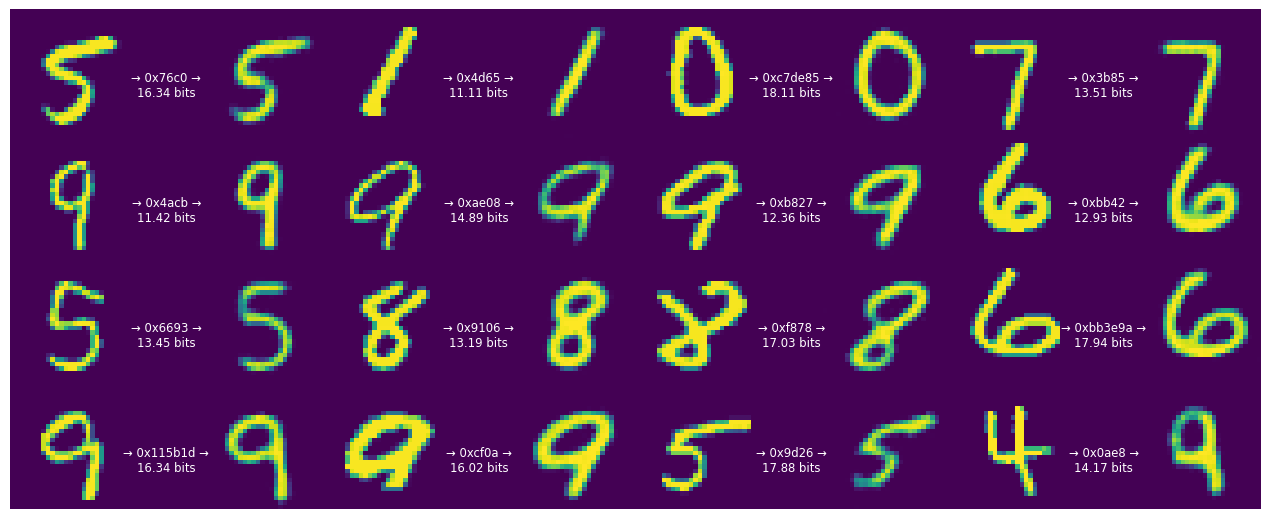

In [25]:
def train_and_visualize_model(lmbda):
  trainer = train_mnist_model(lmbda=lmbda)
  compressor, decompressor = make_mnist_codec(trainer)
  strings, entropies = compressor(originals)
  reconstructions = decompressor(strings)
  display_digits(originals, strings, entropies, reconstructions)

train_and_visualize_model(lmbda=500)


The bit rate of our code goes down, as does the fidelity of the digits. However, most of the digits remain recognizable.

Let's reduce $\lambda$ further.

Epoch 1/15


  1/469 [..............................] - ETA: 21:48 - loss: 140.1581 - distortion_loss: 0.1241 - rate_loss: 102.9228 - distortion_pass_through_loss: 0.1241 - rate_pass_through_loss: 102.9228

 10/469 [..............................] - ETA: 2s - loss: 142.2458 - distortion_loss: 0.1321 - rate_loss: 102.6031 - distortion_pass_through_loss: 0.1321 - rate_pass_through_loss: 102.6031   

 19/469 [>.............................] - ETA: 2s - loss: 141.4721 - distortion_loss: 0.1306 - rate_loss: 102.3035 - distortion_pass_through_loss: 0.1306 - rate_pass_through_loss: 102.3035

 29/469 [>.............................] - ETA: 2s - loss: 140.7824 - distortion_loss: 0.1293 - rate_loss: 102.0014 - distortion_pass_through_loss: 0.1293 - rate_pass_through_loss: 102.0014

 39/469 [=>............................] - ETA: 2s - loss: 139.7772 - distortion_loss: 0.1269 - rate_loss: 101.7080 - distortion_pass_through_loss: 0.1269 - rate_pass_through_loss: 101.7080

 49/469 [==>...........................] - ETA: 2s - loss: 139.0463 - distortion_loss: 0.1254 - rate_loss: 101.4188 - distortion_pass_through_loss: 0.1254 - rate_pass_through_loss: 101.4188

 58/469 [==>...........................] - ETA: 2s - loss: 138.2721 - distortion_loss: 0.1235 - rate_loss: 101.2129 - distortion_pass_through_loss: 0.1235 - rate_pass_through_loss: 101.2129

 67/469 [===>..........................] - ETA: 2s - loss: 137.4175 - distortion_loss: 0.1214 - rate_loss: 101.0071 - distortion_pass_through_loss: 0.1214 - rate_pass_through_loss: 101.0071

 77/469 [===>..........................] - ETA: 2s - loss: 136.2952 - distortion_loss: 0.1183 - rate_loss: 100.7935 - distortion_pass_through_loss: 0.1183 - rate_pass_through_loss: 100.7935

 87/469 [====>.........................] - ETA: 2s - loss: 135.1980 - distortion_loss: 0.1154 - rate_loss: 100.5757 - distortion_pass_through_loss: 0.1154 - rate_pass_through_loss: 100.5757

 97/469 [=====>........................] - ETA: 2s - loss: 134.1054 - distortion_loss: 0.1125 - rate_loss: 100.3649 - distortion_pass_through_loss: 0.1125 - rate_pass_through_loss: 100.3649

107/469 [=====>........................] - ETA: 1s - loss: 133.1226 - distortion_loss: 0.1099 - rate_loss: 100.1384 - distortion_pass_through_loss: 0.1099 - rate_pass_through_loss: 100.1384

116/469 [======>.......................] - ETA: 1s - loss: 132.2923 - distortion_loss: 0.1078 - rate_loss: 99.9397 - distortion_pass_through_loss: 0.1078 - rate_pass_through_loss: 99.9397  

126/469 [=======>......................] - ETA: 1s - loss: 131.3900 - distortion_loss: 0.1056 - rate_loss: 99.7136 - distortion_pass_through_loss: 0.1056 - rate_pass_through_loss: 99.7136

136/469 [=======>......................] - ETA: 1s - loss: 130.5317 - distortion_loss: 0.1035 - rate_loss: 99.4806 - distortion_pass_through_loss: 0.1035 - rate_pass_through_loss: 99.4806

146/469 [========>.....................] - ETA: 1s - loss: 129.7594 - distortion_loss: 0.1017 - rate_loss: 99.2481 - distortion_pass_through_loss: 0.1017 - rate_pass_through_loss: 99.2481

156/469 [========>.....................] - ETA: 1s - loss: 129.0177 - distortion_loss: 0.1000 - rate_loss: 99.0118 - distortion_pass_through_loss: 0.1000 - rate_pass_through_loss: 99.0118

166/469 [=========>....................] - ETA: 1s - loss: 128.2982 - distortion_loss: 0.0984 - rate_loss: 98.7739 - distortion_pass_through_loss: 0.0984 - rate_pass_through_loss: 98.7739

176/469 [==========>...................] - ETA: 1s - loss: 127.6193 - distortion_loss: 0.0970 - rate_loss: 98.5328 - distortion_pass_through_loss: 0.0970 - rate_pass_through_loss: 98.5328

186/469 [==========>...................] - ETA: 1s - loss: 126.9704 - distortion_loss: 0.0956 - rate_loss: 98.2961 - distortion_pass_through_loss: 0.0956 - rate_pass_through_loss: 98.2961

195/469 [===========>..................] - ETA: 1s - loss: 126.4174 - distortion_loss: 0.0945 - rate_loss: 98.0764 - distortion_pass_through_loss: 0.0945 - rate_pass_through_loss: 98.0764

205/469 [============>.................] - ETA: 1s - loss: 125.8012 - distortion_loss: 0.0932 - rate_loss: 97.8282 - distortion_pass_through_loss: 0.0932 - rate_pass_through_loss: 97.8282

215/469 [============>.................] - ETA: 1s - loss: 125.1940 - distortion_loss: 0.0920 - rate_loss: 97.5815 - distortion_pass_through_loss: 0.0920 - rate_pass_through_loss: 97.5815

225/469 [=============>................] - ETA: 1s - loss: 124.6162 - distortion_loss: 0.0910 - rate_loss: 97.3298 - distortion_pass_through_loss: 0.0910 - rate_pass_through_loss: 97.3298

234/469 [=============>................] - ETA: 1s - loss: 124.1222 - distortion_loss: 0.0901 - rate_loss: 97.1043 - distortion_pass_through_loss: 0.0901 - rate_pass_through_loss: 97.1043

243/469 [==============>...............] - ETA: 1s - loss: 123.6252 - distortion_loss: 0.0892 - rate_loss: 96.8765 - distortion_pass_through_loss: 0.0892 - rate_pass_through_loss: 96.8765

252/469 [===============>..............] - ETA: 1s - loss: 123.1679 - distortion_loss: 0.0884 - rate_loss: 96.6459 - distortion_pass_through_loss: 0.0884 - rate_pass_through_loss: 96.6459

262/469 [===============>..............] - ETA: 1s - loss: 122.6566 - distortion_loss: 0.0875 - rate_loss: 96.3917 - distortion_pass_through_loss: 0.0875 - rate_pass_through_loss: 96.3917

272/469 [================>.............] - ETA: 1s - loss: 122.1546 - distortion_loss: 0.0867 - rate_loss: 96.1360 - distortion_pass_through_loss: 0.0867 - rate_pass_through_loss: 96.1360

282/469 [=================>............] - ETA: 1s - loss: 121.6708 - distortion_loss: 0.0860 - rate_loss: 95.8795 - distortion_pass_through_loss: 0.0860 - rate_pass_through_loss: 95.8795

292/469 [=================>............] - ETA: 0s - loss: 121.1926 - distortion_loss: 0.0852 - rate_loss: 95.6239 - distortion_pass_through_loss: 0.0852 - rate_pass_through_loss: 95.6239

302/469 [==================>...........] - ETA: 0s - loss: 120.7171 - distortion_loss: 0.0845 - rate_loss: 95.3651 - distortion_pass_through_loss: 0.0845 - rate_pass_through_loss: 95.3651

312/469 [==================>...........] - ETA: 0s - loss: 120.2590 - distortion_loss: 0.0838 - rate_loss: 95.1058 - distortion_pass_through_loss: 0.0838 - rate_pass_through_loss: 95.1058

322/469 [===================>..........] - ETA: 0s - loss: 119.8105 - distortion_loss: 0.0832 - rate_loss: 94.8467 - distortion_pass_through_loss: 0.0832 - rate_pass_through_loss: 94.8467

332/469 [====================>.........] - ETA: 0s - loss: 119.3665 - distortion_loss: 0.0826 - rate_loss: 94.5850 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 94.5850

342/469 [====================>.........] - ETA: 0s - loss: 118.9331 - distortion_loss: 0.0820 - rate_loss: 94.3240 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 94.3240

352/469 [=====================>........] - ETA: 0s - loss: 118.5096 - distortion_loss: 0.0815 - rate_loss: 94.0632 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 94.0632

362/469 [======================>.......] - ETA: 0s - loss: 118.0918 - distortion_loss: 0.0810 - rate_loss: 93.7997 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 93.7997

372/469 [======================>.......] - ETA: 0s - loss: 117.6782 - distortion_loss: 0.0805 - rate_loss: 93.5383 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 93.5383

382/469 [=======================>......] - ETA: 0s - loss: 117.2673 - distortion_loss: 0.0800 - rate_loss: 93.2774 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 93.2774

392/469 [========================>.....] - ETA: 0s - loss: 116.8644 - distortion_loss: 0.0795 - rate_loss: 93.0129 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 93.0129

402/469 [========================>.....] - ETA: 0s - loss: 116.4600 - distortion_loss: 0.0790 - rate_loss: 92.7484 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 92.7484

412/469 [=========================>....] - ETA: 0s - loss: 116.0706 - distortion_loss: 0.0786 - rate_loss: 92.4864 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 92.4864

421/469 [=========================>....] - ETA: 0s - loss: 115.7200 - distortion_loss: 0.0782 - rate_loss: 92.2489 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 92.2489

431/469 [==========================>...] - ETA: 0s - loss: 115.3401 - distortion_loss: 0.0778 - rate_loss: 91.9854 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 91.9854

441/469 [===========================>..] - ETA: 0s - loss: 114.9612 - distortion_loss: 0.0775 - rate_loss: 91.7231 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 91.7231

451/469 [===========================>..] - ETA: 0s - loss: 114.5869 - distortion_loss: 0.0771 - rate_loss: 91.4590 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 91.4590

461/469 [============================>.] - ETA: 0s - loss: 114.2220 - distortion_loss: 0.0767 - rate_loss: 91.1970 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 91.1970

469/469 [==============================] - 6s 6ms/step - loss: 113.9371 - distortion_loss: 0.0765 - rate_loss: 90.9945 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 90.9879 - val_loss: 96.4709 - val_distortion_loss: 0.0675 - val_rate_loss: 76.2116 - val_distortion_pass_through_loss: 0.0675 - val_rate_pass_through_loss: 76.2140


Epoch 2/15


  1/469 [..............................] - ETA: 4s - loss: 95.6269 - distortion_loss: 0.0569 - rate_loss: 78.5586 - distortion_pass_through_loss: 0.0569 - rate_pass_through_loss: 78.5586

 10/469 [..............................] - ETA: 2s - loss: 96.6814 - distortion_loss: 0.0610 - rate_loss: 78.3836 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 78.3836

 20/469 [>.............................] - ETA: 2s - loss: 96.3764 - distortion_loss: 0.0608 - rate_loss: 78.1248 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 78.1248

 30/469 [>.............................] - ETA: 2s - loss: 96.1415 - distortion_loss: 0.0608 - rate_loss: 77.9038 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 77.9038

 40/469 [=>............................] - ETA: 2s - loss: 95.7967 - distortion_loss: 0.0606 - rate_loss: 77.6199 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.6199

 50/469 [==>...........................] - ETA: 2s - loss: 95.5421 - distortion_loss: 0.0606 - rate_loss: 77.3664 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.3664

 59/469 [==>...........................] - ETA: 2s - loss: 95.2981 - distortion_loss: 0.0605 - rate_loss: 77.1524 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 77.1524

 68/469 [===>..........................] - ETA: 2s - loss: 95.0946 - distortion_loss: 0.0606 - rate_loss: 76.9284 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 76.9284

 78/469 [===>..........................] - ETA: 2s - loss: 94.7937 - distortion_loss: 0.0604 - rate_loss: 76.6772 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 76.6772

 87/469 [====>.........................] - ETA: 2s - loss: 94.5529 - distortion_loss: 0.0603 - rate_loss: 76.4491 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 76.4491

 97/469 [=====>........................] - ETA: 2s - loss: 94.2499 - distortion_loss: 0.0602 - rate_loss: 76.1871 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 76.1871

107/469 [=====>........................] - ETA: 1s - loss: 93.9933 - distortion_loss: 0.0602 - rate_loss: 75.9398 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 75.9398

117/469 [======>.......................] - ETA: 1s - loss: 93.7336 - distortion_loss: 0.0601 - rate_loss: 75.6933 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 75.6933

127/469 [=======>......................] - ETA: 1s - loss: 93.4536 - distortion_loss: 0.0600 - rate_loss: 75.4456 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 75.4456

137/469 [=======>......................] - ETA: 1s - loss: 93.1828 - distortion_loss: 0.0600 - rate_loss: 75.1921 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 75.1921

147/469 [========>.....................] - ETA: 1s - loss: 92.9384 - distortion_loss: 0.0599 - rate_loss: 74.9539 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 74.9539

157/469 [=========>....................] - ETA: 1s - loss: 92.6995 - distortion_loss: 0.0600 - rate_loss: 74.7038 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 74.7038

167/469 [=========>....................] - ETA: 1s - loss: 92.4564 - distortion_loss: 0.0600 - rate_loss: 74.4634 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 74.4634

177/469 [==========>...................] - ETA: 1s - loss: 92.2089 - distortion_loss: 0.0600 - rate_loss: 74.2154 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 74.2154

187/469 [==========>...................] - ETA: 1s - loss: 91.9725 - distortion_loss: 0.0600 - rate_loss: 73.9705 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 73.9705

197/469 [===========>..................] - ETA: 1s - loss: 91.7377 - distortion_loss: 0.0600 - rate_loss: 73.7323 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 73.7323

207/469 [============>.................] - ETA: 1s - loss: 91.4985 - distortion_loss: 0.0600 - rate_loss: 73.4949 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 73.4949

217/469 [============>.................] - ETA: 1s - loss: 91.2526 - distortion_loss: 0.0600 - rate_loss: 73.2495 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 73.2495

227/469 [=============>................] - ETA: 1s - loss: 91.0095 - distortion_loss: 0.0600 - rate_loss: 73.0089 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 73.0089

237/469 [==============>...............] - ETA: 1s - loss: 90.7844 - distortion_loss: 0.0600 - rate_loss: 72.7740 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 72.7740

247/469 [==============>...............] - ETA: 1s - loss: 90.5515 - distortion_loss: 0.0601 - rate_loss: 72.5346 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 72.5346

257/469 [===============>..............] - ETA: 1s - loss: 90.3176 - distortion_loss: 0.0601 - rate_loss: 72.2960 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 72.2960

267/469 [================>.............] - ETA: 1s - loss: 90.0795 - distortion_loss: 0.0601 - rate_loss: 72.0595 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 72.0595

277/469 [================>.............] - ETA: 1s - loss: 89.8499 - distortion_loss: 0.0601 - rate_loss: 71.8227 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 71.8227

286/469 [=================>............] - ETA: 0s - loss: 89.6536 - distortion_loss: 0.0601 - rate_loss: 71.6178 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 71.6178

295/469 [=================>............] - ETA: 0s - loss: 89.4461 - distortion_loss: 0.0601 - rate_loss: 71.4048 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 71.4048

305/469 [==================>...........] - ETA: 0s - loss: 89.2166 - distortion_loss: 0.0601 - rate_loss: 71.1761 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 71.1761

315/469 [===================>..........] - ETA: 0s - loss: 88.9952 - distortion_loss: 0.0602 - rate_loss: 70.9435 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 70.9435

324/469 [===================>..........] - ETA: 0s - loss: 88.7908 - distortion_loss: 0.0602 - rate_loss: 70.7365 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 70.7365

333/469 [====================>.........] - ETA: 0s - loss: 88.5921 - distortion_loss: 0.0602 - rate_loss: 70.5344 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 70.5344

343/469 [====================>.........] - ETA: 0s - loss: 88.3664 - distortion_loss: 0.0602 - rate_loss: 70.3069 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 70.3069

353/469 [=====================>........] - ETA: 0s - loss: 88.1435 - distortion_loss: 0.0602 - rate_loss: 70.0788 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 70.0788

363/469 [======================>.......] - ETA: 0s - loss: 87.9251 - distortion_loss: 0.0602 - rate_loss: 69.8516 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 69.8516

372/469 [======================>.......] - ETA: 0s - loss: 87.7255 - distortion_loss: 0.0603 - rate_loss: 69.6480 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 69.6480

382/469 [=======================>......] - ETA: 0s - loss: 87.5000 - distortion_loss: 0.0603 - rate_loss: 69.4242 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 69.4242

392/469 [========================>.....] - ETA: 0s - loss: 87.2807 - distortion_loss: 0.0603 - rate_loss: 69.1979 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 69.1979

402/469 [========================>.....] - ETA: 0s - loss: 87.0591 - distortion_loss: 0.0603 - rate_loss: 68.9723 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 68.9723

412/469 [=========================>....] - ETA: 0s - loss: 86.8529 - distortion_loss: 0.0603 - rate_loss: 68.7533 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 68.7533

422/469 [=========================>....] - ETA: 0s - loss: 86.6401 - distortion_loss: 0.0603 - rate_loss: 68.5368 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 68.5368

432/469 [==========================>...] - ETA: 0s - loss: 86.4331 - distortion_loss: 0.0604 - rate_loss: 68.3168 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 68.3168

442/469 [===========================>..] - ETA: 0s - loss: 86.2216 - distortion_loss: 0.0604 - rate_loss: 68.0967 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 68.0967

451/469 [===========================>..] - ETA: 0s - loss: 86.0321 - distortion_loss: 0.0604 - rate_loss: 67.8999 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 67.8999

461/469 [============================>.] - ETA: 0s - loss: 85.8242 - distortion_loss: 0.0605 - rate_loss: 67.6834 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 67.6834

469/469 [==============================] - 3s 6ms/step - loss: 85.6602 - distortion_loss: 0.0605 - rate_loss: 67.5187 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 67.5134 - val_loss: 73.8576 - val_distortion_loss: 0.0757 - val_rate_loss: 51.1425 - val_distortion_pass_through_loss: 0.0757 - val_rate_pass_through_loss: 51.1457


Epoch 3/15


  1/469 [..............................] - ETA: 4s - loss: 74.6930 - distortion_loss: 0.0593 - rate_loss: 56.9103 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 56.9103

 10/469 [..............................] - ETA: 2s - loss: 75.8548 - distortion_loss: 0.0621 - rate_loss: 57.2170 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 57.2170

 19/469 [>.............................] - ETA: 2s - loss: 75.5555 - distortion_loss: 0.0618 - rate_loss: 57.0091 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 57.0091

 29/469 [>.............................] - ETA: 2s - loss: 75.4519 - distortion_loss: 0.0620 - rate_loss: 56.8518 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 56.8518

 38/469 [=>............................] - ETA: 2s - loss: 75.2670 - distortion_loss: 0.0621 - rate_loss: 56.6338 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 56.6338

 48/469 [==>...........................] - ETA: 2s - loss: 75.1281 - distortion_loss: 0.0622 - rate_loss: 56.4635 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 56.4635

 58/469 [==>...........................] - ETA: 2s - loss: 74.9607 - distortion_loss: 0.0622 - rate_loss: 56.2865 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 56.2865

 67/469 [===>..........................] - ETA: 2s - loss: 74.8354 - distortion_loss: 0.0623 - rate_loss: 56.1390 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 56.1390

 76/469 [===>..........................] - ETA: 2s - loss: 74.6370 - distortion_loss: 0.0622 - rate_loss: 55.9873 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 55.9873

 85/469 [====>.........................] - ETA: 2s - loss: 74.4640 - distortion_loss: 0.0622 - rate_loss: 55.8130 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 55.8130

 95/469 [=====>........................] - ETA: 2s - loss: 74.2657 - distortion_loss: 0.0621 - rate_loss: 55.6214 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 55.6214

104/469 [=====>........................] - ETA: 2s - loss: 74.1026 - distortion_loss: 0.0622 - rate_loss: 55.4512 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 55.4512

113/469 [======>.......................] - ETA: 1s - loss: 73.9419 - distortion_loss: 0.0622 - rate_loss: 55.2871 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 55.2871

123/469 [======>.......................] - ETA: 1s - loss: 73.7638 - distortion_loss: 0.0622 - rate_loss: 55.1113 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 55.1113

132/469 [=======>......................] - ETA: 1s - loss: 73.5899 - distortion_loss: 0.0622 - rate_loss: 54.9380 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 54.9380

141/469 [========>.....................] - ETA: 1s - loss: 73.4503 - distortion_loss: 0.0622 - rate_loss: 54.7831 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 54.7831

151/469 [========>.....................] - ETA: 1s - loss: 73.2907 - distortion_loss: 0.0623 - rate_loss: 54.6093 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 54.6093

161/469 [=========>....................] - ETA: 1s - loss: 73.1450 - distortion_loss: 0.0623 - rate_loss: 54.4443 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 54.4443

170/469 [=========>....................] - ETA: 1s - loss: 73.0009 - distortion_loss: 0.0624 - rate_loss: 54.2819 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 54.2819

179/469 [==========>...................] - ETA: 1s - loss: 72.8620 - distortion_loss: 0.0625 - rate_loss: 54.1230 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 54.1230

188/469 [===========>..................] - ETA: 1s - loss: 72.7208 - distortion_loss: 0.0625 - rate_loss: 53.9732 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 53.9732

197/469 [===========>..................] - ETA: 1s - loss: 72.5879 - distortion_loss: 0.0626 - rate_loss: 53.8146 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 53.8146

206/469 [============>.................] - ETA: 1s - loss: 72.4401 - distortion_loss: 0.0626 - rate_loss: 53.6587 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 53.6587

215/469 [============>.................] - ETA: 1s - loss: 72.2858 - distortion_loss: 0.0626 - rate_loss: 53.5017 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 53.5017

224/469 [=============>................] - ETA: 1s - loss: 72.1449 - distortion_loss: 0.0626 - rate_loss: 53.3526 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 53.3526

234/469 [=============>................] - ETA: 1s - loss: 72.0025 - distortion_loss: 0.0627 - rate_loss: 53.1856 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 53.1856

244/469 [==============>...............] - ETA: 1s - loss: 71.8404 - distortion_loss: 0.0627 - rate_loss: 53.0166 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 53.0166

254/469 [===============>..............] - ETA: 1s - loss: 71.6959 - distortion_loss: 0.0628 - rate_loss: 52.8491 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 52.8491

264/469 [===============>..............] - ETA: 1s - loss: 71.5408 - distortion_loss: 0.0629 - rate_loss: 52.6817 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 52.6817

274/469 [================>.............] - ETA: 1s - loss: 71.3965 - distortion_loss: 0.0629 - rate_loss: 52.5148 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 52.5148

284/469 [=================>............] - ETA: 1s - loss: 71.2590 - distortion_loss: 0.0630 - rate_loss: 52.3542 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 52.3542

294/469 [=================>............] - ETA: 0s - loss: 71.1061 - distortion_loss: 0.0630 - rate_loss: 52.1971 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 52.1971

304/469 [==================>...........] - ETA: 0s - loss: 70.9578 - distortion_loss: 0.0631 - rate_loss: 52.0328 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 52.0328

314/469 [===================>..........] - ETA: 0s - loss: 70.8233 - distortion_loss: 0.0632 - rate_loss: 51.8744 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 51.8744

324/469 [===================>..........] - ETA: 0s - loss: 70.6806 - distortion_loss: 0.0632 - rate_loss: 51.7133 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 51.7133

334/469 [====================>.........] - ETA: 0s - loss: 70.5391 - distortion_loss: 0.0633 - rate_loss: 51.5570 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 51.5570

344/469 [=====================>........] - ETA: 0s - loss: 70.3936 - distortion_loss: 0.0633 - rate_loss: 51.4031 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 51.4031

354/469 [=====================>........] - ETA: 0s - loss: 70.2515 - distortion_loss: 0.0634 - rate_loss: 51.2457 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 51.2457

364/469 [======================>.......] - ETA: 0s - loss: 70.1155 - distortion_loss: 0.0634 - rate_loss: 51.0863 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 51.0863

373/469 [======================>.......] - ETA: 0s - loss: 69.9901 - distortion_loss: 0.0635 - rate_loss: 50.9467 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 50.9467

382/469 [=======================>......] - ETA: 0s - loss: 69.8620 - distortion_loss: 0.0635 - rate_loss: 50.8069 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 50.8069

391/469 [========================>.....] - ETA: 0s - loss: 69.7372 - distortion_loss: 0.0636 - rate_loss: 50.6702 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 50.6702

400/469 [========================>.....] - ETA: 0s - loss: 69.6139 - distortion_loss: 0.0636 - rate_loss: 50.5348 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 50.5348

409/469 [=========================>....] - ETA: 0s - loss: 69.4874 - distortion_loss: 0.0636 - rate_loss: 50.3959 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 50.3959

418/469 [=========================>....] - ETA: 0s - loss: 69.3696 - distortion_loss: 0.0637 - rate_loss: 50.2593 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 50.2593

428/469 [==========================>...] - ETA: 0s - loss: 69.2351 - distortion_loss: 0.0638 - rate_loss: 50.1079 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 50.1079

437/469 [==========================>...] - ETA: 0s - loss: 69.1130 - distortion_loss: 0.0638 - rate_loss: 49.9710 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 49.9710

447/469 [===========================>..] - ETA: 0s - loss: 68.9823 - distortion_loss: 0.0639 - rate_loss: 49.8204 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 49.8204

456/469 [============================>.] - ETA: 0s - loss: 68.8583 - distortion_loss: 0.0639 - rate_loss: 49.6841 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 49.6841

466/469 [============================>.] - ETA: 0s - loss: 68.7319 - distortion_loss: 0.0640 - rate_loss: 49.5401 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 49.5401

469/469 [==============================] - 3s 6ms/step - loss: 68.6907 - distortion_loss: 0.0640 - rate_loss: 49.5000 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 49.4961 - val_loss: 59.4390 - val_distortion_loss: 0.0961 - val_rate_loss: 30.6046 - val_distortion_pass_through_loss: 0.0962 - val_rate_pass_through_loss: 30.6036


Epoch 4/15


  1/469 [..............................] - ETA: 4s - loss: 61.1828 - distortion_loss: 0.0650 - rate_loss: 41.6869 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 41.6869

 10/469 [..............................] - ETA: 2s - loss: 62.6554 - distortion_loss: 0.0670 - rate_loss: 42.5410 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.5410

 20/469 [>.............................] - ETA: 2s - loss: 62.3712 - distortion_loss: 0.0668 - rate_loss: 42.3401 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 42.3401

 30/469 [>.............................] - ETA: 2s - loss: 62.2920 - distortion_loss: 0.0669 - rate_loss: 42.2196 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 42.2196

 40/469 [=>............................] - ETA: 2s - loss: 62.1013 - distortion_loss: 0.0667 - rate_loss: 42.0864 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 42.0864

 50/469 [==>...........................] - ETA: 2s - loss: 61.9988 - distortion_loss: 0.0668 - rate_loss: 41.9713 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 41.9713

 60/469 [==>...........................] - ETA: 2s - loss: 61.9088 - distortion_loss: 0.0668 - rate_loss: 41.8620 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 41.8620

 70/469 [===>..........................] - ETA: 2s - loss: 61.8423 - distortion_loss: 0.0669 - rate_loss: 41.7616 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 41.7616

 80/469 [====>.........................] - ETA: 2s - loss: 61.6932 - distortion_loss: 0.0669 - rate_loss: 41.6364 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 41.6364

 89/469 [====>.........................] - ETA: 2s - loss: 61.5867 - distortion_loss: 0.0668 - rate_loss: 41.5557 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 41.5557

 99/469 [=====>........................] - ETA: 2s - loss: 61.4737 - distortion_loss: 0.0668 - rate_loss: 41.4387 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 41.4387

109/469 [=====>........................] - ETA: 1s - loss: 61.3742 - distortion_loss: 0.0669 - rate_loss: 41.3074 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 41.3074

119/469 [======>.......................] - ETA: 1s - loss: 61.2953 - distortion_loss: 0.0670 - rate_loss: 41.1837 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 41.1837

129/469 [=======>......................] - ETA: 1s - loss: 61.1459 - distortion_loss: 0.0669 - rate_loss: 41.0619 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 41.0619

139/469 [=======>......................] - ETA: 1s - loss: 61.0277 - distortion_loss: 0.0669 - rate_loss: 40.9445 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 40.9445

149/469 [========>.....................] - ETA: 1s - loss: 60.9312 - distortion_loss: 0.0670 - rate_loss: 40.8249 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 40.8249

159/469 [=========>....................] - ETA: 1s - loss: 60.8510 - distortion_loss: 0.0671 - rate_loss: 40.7249 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 40.7249

169/469 [=========>....................] - ETA: 1s - loss: 60.7565 - distortion_loss: 0.0671 - rate_loss: 40.6120 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 40.6120

178/469 [==========>...................] - ETA: 1s - loss: 60.6705 - distortion_loss: 0.0672 - rate_loss: 40.5129 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 40.5129

187/469 [==========>...................] - ETA: 1s - loss: 60.6015 - distortion_loss: 0.0673 - rate_loss: 40.4162 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 40.4162

197/469 [===========>..................] - ETA: 1s - loss: 60.5168 - distortion_loss: 0.0673 - rate_loss: 40.3190 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 40.3190

206/469 [============>.................] - ETA: 1s - loss: 60.4258 - distortion_loss: 0.0674 - rate_loss: 40.2089 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.2089

216/469 [============>.................] - ETA: 1s - loss: 60.3244 - distortion_loss: 0.0674 - rate_loss: 40.1007 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.1007

226/469 [=============>................] - ETA: 1s - loss: 60.2382 - distortion_loss: 0.0675 - rate_loss: 39.9967 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 39.9967

236/469 [==============>...............] - ETA: 1s - loss: 60.1560 - distortion_loss: 0.0676 - rate_loss: 39.8880 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 39.8880

246/469 [==============>...............] - ETA: 1s - loss: 60.0667 - distortion_loss: 0.0677 - rate_loss: 39.7714 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 39.7714

256/469 [===============>..............] - ETA: 1s - loss: 59.9680 - distortion_loss: 0.0677 - rate_loss: 39.6634 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 39.6634

266/469 [================>.............] - ETA: 1s - loss: 59.8806 - distortion_loss: 0.0677 - rate_loss: 39.5579 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 39.5579

276/469 [================>.............] - ETA: 1s - loss: 59.7901 - distortion_loss: 0.0678 - rate_loss: 39.4546 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.4546

286/469 [=================>............] - ETA: 0s - loss: 59.7129 - distortion_loss: 0.0679 - rate_loss: 39.3560 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.3560

296/469 [=================>............] - ETA: 0s - loss: 59.6123 - distortion_loss: 0.0679 - rate_loss: 39.2531 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.2531

306/469 [==================>...........] - ETA: 0s - loss: 59.5279 - distortion_loss: 0.0679 - rate_loss: 39.1463 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.1463

316/469 [===================>..........] - ETA: 0s - loss: 59.4432 - distortion_loss: 0.0680 - rate_loss: 39.0408 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.0408

326/469 [===================>..........] - ETA: 0s - loss: 59.3599 - distortion_loss: 0.0681 - rate_loss: 38.9416 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 38.9416

336/469 [====================>.........] - ETA: 0s - loss: 59.2756 - distortion_loss: 0.0681 - rate_loss: 38.8448 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 38.8448

346/469 [=====================>........] - ETA: 0s - loss: 59.1818 - distortion_loss: 0.0681 - rate_loss: 38.7397 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 38.7397

356/469 [=====================>........] - ETA: 0s - loss: 59.1058 - distortion_loss: 0.0682 - rate_loss: 38.6435 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 38.6435

366/469 [======================>.......] - ETA: 0s - loss: 59.0324 - distortion_loss: 0.0683 - rate_loss: 38.5494 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.5494

376/469 [=======================>......] - ETA: 0s - loss: 58.9478 - distortion_loss: 0.0683 - rate_loss: 38.4499 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.4499

386/469 [=======================>......] - ETA: 0s - loss: 58.8619 - distortion_loss: 0.0684 - rate_loss: 38.3524 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.3524

396/469 [========================>.....] - ETA: 0s - loss: 58.7782 - distortion_loss: 0.0684 - rate_loss: 38.2502 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.2502

406/469 [========================>.....] - ETA: 0s - loss: 58.6857 - distortion_loss: 0.0684 - rate_loss: 38.1519 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.1519

416/469 [=========================>....] - ETA: 0s - loss: 58.6051 - distortion_loss: 0.0685 - rate_loss: 38.0576 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.0576

426/469 [==========================>...] - ETA: 0s - loss: 58.5207 - distortion_loss: 0.0685 - rate_loss: 37.9614 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 37.9614

436/469 [==========================>...] - ETA: 0s - loss: 58.4388 - distortion_loss: 0.0686 - rate_loss: 37.8659 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 37.8659

445/469 [===========================>..] - ETA: 0s - loss: 58.3658 - distortion_loss: 0.0686 - rate_loss: 37.7813 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 37.7813

455/469 [============================>.] - ETA: 0s - loss: 58.2893 - distortion_loss: 0.0687 - rate_loss: 37.6862 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 37.6862

465/469 [============================>.] - ETA: 0s - loss: 58.2232 - distortion_loss: 0.0688 - rate_loss: 37.5955 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 37.5955

469/469 [==============================] - 3s 6ms/step - loss: 58.1920 - distortion_loss: 0.0688 - rate_loss: 37.5607 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 37.5580 - val_loss: 50.3474 - val_distortion_loss: 0.1087 - val_rate_loss: 17.7326 - val_distortion_pass_through_loss: 0.1089 - val_rate_pass_through_loss: 17.7249


Epoch 5/15


  1/469 [..............................] - ETA: 4s - loss: 53.4551 - distortion_loss: 0.0737 - rate_loss: 31.3543 - distortion_pass_through_loss: 0.0737 - rate_pass_through_loss: 31.3543

  9/469 [..............................] - ETA: 2s - loss: 54.7920 - distortion_loss: 0.0721 - rate_loss: 33.1516 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 33.1516

 19/469 [>.............................] - ETA: 2s - loss: 54.5141 - distortion_loss: 0.0716 - rate_loss: 33.0345 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 33.0345

 29/469 [>.............................] - ETA: 2s - loss: 54.5669 - distortion_loss: 0.0719 - rate_loss: 32.9825 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.9825

 39/469 [=>............................] - ETA: 2s - loss: 54.4083 - distortion_loss: 0.0716 - rate_loss: 32.9197 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 32.9197

 49/469 [==>...........................] - ETA: 2s - loss: 54.3544 - distortion_loss: 0.0717 - rate_loss: 32.8406 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.8406

 59/469 [==>...........................] - ETA: 2s - loss: 54.2439 - distortion_loss: 0.0717 - rate_loss: 32.7420 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.7420

 69/469 [===>..........................] - ETA: 2s - loss: 54.2409 - distortion_loss: 0.0719 - rate_loss: 32.6731 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.6731

 79/469 [====>.........................] - ETA: 2s - loss: 54.1557 - distortion_loss: 0.0718 - rate_loss: 32.6262 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.6262

 89/469 [====>.........................] - ETA: 2s - loss: 54.0557 - distortion_loss: 0.0717 - rate_loss: 32.5335 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.5335

 99/469 [=====>........................] - ETA: 2s - loss: 53.9651 - distortion_loss: 0.0716 - rate_loss: 32.4725 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 32.4725

109/469 [=====>........................] - ETA: 1s - loss: 53.8787 - distortion_loss: 0.0716 - rate_loss: 32.3899 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 32.3899

119/469 [======>.......................] - ETA: 1s - loss: 53.8385 - distortion_loss: 0.0717 - rate_loss: 32.3182 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.3182

129/469 [=======>......................] - ETA: 1s - loss: 53.7183 - distortion_loss: 0.0716 - rate_loss: 32.2273 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 32.2273

138/469 [=======>......................] - ETA: 1s - loss: 53.6415 - distortion_loss: 0.0716 - rate_loss: 32.1561 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 32.1561

148/469 [========>.....................] - ETA: 1s - loss: 53.5754 - distortion_loss: 0.0716 - rate_loss: 32.0806 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 32.0806

158/469 [=========>....................] - ETA: 1s - loss: 53.5221 - distortion_loss: 0.0717 - rate_loss: 32.0232 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.0232

167/469 [=========>....................] - ETA: 1s - loss: 53.4725 - distortion_loss: 0.0717 - rate_loss: 31.9487 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 31.9487

177/469 [==========>...................] - ETA: 1s - loss: 53.4110 - distortion_loss: 0.0717 - rate_loss: 31.8868 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 31.8868

186/469 [==========>...................] - ETA: 1s - loss: 53.3660 - distortion_loss: 0.0718 - rate_loss: 31.8256 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 31.8256

195/469 [===========>..................] - ETA: 1s - loss: 53.3311 - distortion_loss: 0.0719 - rate_loss: 31.7667 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.7667

205/469 [============>.................] - ETA: 1s - loss: 53.2638 - distortion_loss: 0.0719 - rate_loss: 31.6929 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.6929

215/469 [============>.................] - ETA: 1s - loss: 53.1891 - distortion_loss: 0.0719 - rate_loss: 31.6216 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.6216

225/469 [=============>................] - ETA: 1s - loss: 53.1242 - distortion_loss: 0.0719 - rate_loss: 31.5620 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.5620

235/469 [==============>...............] - ETA: 1s - loss: 53.0799 - distortion_loss: 0.0720 - rate_loss: 31.4923 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.4923

245/469 [==============>...............] - ETA: 1s - loss: 53.0199 - distortion_loss: 0.0720 - rate_loss: 31.4098 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.4098

255/469 [===============>..............] - ETA: 1s - loss: 52.9725 - distortion_loss: 0.0721 - rate_loss: 31.3431 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.3431

264/469 [===============>..............] - ETA: 1s - loss: 52.9144 - distortion_loss: 0.0721 - rate_loss: 31.2778 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.2778

274/469 [================>.............] - ETA: 1s - loss: 52.8656 - distortion_loss: 0.0722 - rate_loss: 31.2095 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.2095

284/469 [=================>............] - ETA: 1s - loss: 52.8228 - distortion_loss: 0.0722 - rate_loss: 31.1480 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.1480

294/469 [=================>............] - ETA: 0s - loss: 52.7700 - distortion_loss: 0.0723 - rate_loss: 31.0871 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.0871

304/469 [==================>...........] - ETA: 0s - loss: 52.7107 - distortion_loss: 0.0723 - rate_loss: 31.0204 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.0204

314/469 [===================>..........] - ETA: 0s - loss: 52.6673 - distortion_loss: 0.0724 - rate_loss: 30.9485 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 30.9485

324/469 [===================>..........] - ETA: 0s - loss: 52.6182 - distortion_loss: 0.0724 - rate_loss: 30.8835 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 30.8835

334/469 [====================>.........] - ETA: 0s - loss: 52.5716 - distortion_loss: 0.0725 - rate_loss: 30.8210 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 30.8210

344/469 [=====================>........] - ETA: 0s - loss: 52.5162 - distortion_loss: 0.0725 - rate_loss: 30.7569 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 30.7569

354/469 [=====================>........] - ETA: 0s - loss: 52.4639 - distortion_loss: 0.0726 - rate_loss: 30.6945 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 30.6945

364/469 [======================>.......] - ETA: 0s - loss: 52.4156 - distortion_loss: 0.0726 - rate_loss: 30.6322 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 30.6322

374/469 [======================>.......] - ETA: 0s - loss: 52.3680 - distortion_loss: 0.0727 - rate_loss: 30.5679 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.5679

384/469 [=======================>......] - ETA: 0s - loss: 52.3223 - distortion_loss: 0.0727 - rate_loss: 30.4989 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.4989

394/469 [========================>.....] - ETA: 0s - loss: 52.2686 - distortion_loss: 0.0728 - rate_loss: 30.4346 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.4346

404/469 [========================>.....] - ETA: 0s - loss: 52.2109 - distortion_loss: 0.0728 - rate_loss: 30.3709 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.3709

414/469 [=========================>....] - ETA: 0s - loss: 52.1650 - distortion_loss: 0.0728 - rate_loss: 30.3142 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.3142

424/469 [==========================>...] - ETA: 0s - loss: 52.1062 - distortion_loss: 0.0729 - rate_loss: 30.2481 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.2481

434/469 [==========================>...] - ETA: 0s - loss: 52.0607 - distortion_loss: 0.0729 - rate_loss: 30.1867 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.1867

443/469 [===========================>..] - ETA: 0s - loss: 52.0168 - distortion_loss: 0.0730 - rate_loss: 30.1309 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.1309

453/469 [===========================>..] - ETA: 0s - loss: 51.9686 - distortion_loss: 0.0730 - rate_loss: 30.0699 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.0699

463/469 [============================>.] - ETA: 0s - loss: 51.9245 - distortion_loss: 0.0730 - rate_loss: 30.0179 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.0179

469/469 [==============================] - 3s 6ms/step - loss: 51.8959 - distortion_loss: 0.0731 - rate_loss: 29.9792 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 29.9772 - val_loss: 43.2656 - val_distortion_loss: 0.1062 - val_rate_loss: 11.4123 - val_distortion_pass_through_loss: 0.1063 - val_rate_pass_through_loss: 11.4028


Epoch 6/15


  1/469 [..............................] - ETA: 4s - loss: 48.0878 - distortion_loss: 0.0708 - rate_loss: 26.8415 - distortion_pass_through_loss: 0.0708 - rate_pass_through_loss: 26.8415

 11/469 [..............................] - ETA: 2s - loss: 49.6341 - distortion_loss: 0.0752 - rate_loss: 27.0828 - distortion_pass_through_loss: 0.0752 - rate_pass_through_loss: 27.0828

 21/469 [>.............................] - ETA: 2s - loss: 49.6403 - distortion_loss: 0.0751 - rate_loss: 27.1134 - distortion_pass_through_loss: 0.0751 - rate_pass_through_loss: 27.1134

 31/469 [>.............................] - ETA: 2s - loss: 49.6350 - distortion_loss: 0.0754 - rate_loss: 27.0164 - distortion_pass_through_loss: 0.0754 - rate_pass_through_loss: 27.0164

 40/469 [=>............................] - ETA: 2s - loss: 49.5347 - distortion_loss: 0.0752 - rate_loss: 26.9780 - distortion_pass_through_loss: 0.0752 - rate_pass_through_loss: 26.9780

 49/469 [==>...........................] - ETA: 2s - loss: 49.5067 - distortion_loss: 0.0751 - rate_loss: 26.9665 - distortion_pass_through_loss: 0.0751 - rate_pass_through_loss: 26.9665

 58/469 [==>...........................] - ETA: 2s - loss: 49.4713 - distortion_loss: 0.0752 - rate_loss: 26.9006 - distortion_pass_through_loss: 0.0752 - rate_pass_through_loss: 26.9006

 67/469 [===>..........................] - ETA: 2s - loss: 49.4919 - distortion_loss: 0.0755 - rate_loss: 26.8442 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 26.8442

 76/469 [===>..........................] - ETA: 2s - loss: 49.4401 - distortion_loss: 0.0753 - rate_loss: 26.8355 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 26.8355

 86/469 [====>.........................] - ETA: 2s - loss: 49.3882 - distortion_loss: 0.0753 - rate_loss: 26.7878 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 26.7878

 96/469 [=====>........................] - ETA: 2s - loss: 49.3061 - distortion_loss: 0.0752 - rate_loss: 26.7330 - distortion_pass_through_loss: 0.0752 - rate_pass_through_loss: 26.7330

105/469 [=====>........................] - ETA: 2s - loss: 49.2649 - distortion_loss: 0.0753 - rate_loss: 26.6736 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 26.6736

114/469 [======>.......................] - ETA: 1s - loss: 49.2267 - distortion_loss: 0.0753 - rate_loss: 26.6322 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 26.6322

123/469 [======>.......................] - ETA: 1s - loss: 49.1770 - distortion_loss: 0.0753 - rate_loss: 26.5726 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 26.5726

132/469 [=======>......................] - ETA: 1s - loss: 49.0969 - distortion_loss: 0.0753 - rate_loss: 26.5111 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 26.5111

142/469 [========>.....................] - ETA: 1s - loss: 49.0442 - distortion_loss: 0.0753 - rate_loss: 26.4615 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 26.4615

151/469 [========>.....................] - ETA: 1s - loss: 49.0179 - distortion_loss: 0.0753 - rate_loss: 26.4165 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 26.4165

160/469 [=========>....................] - ETA: 1s - loss: 49.0107 - distortion_loss: 0.0754 - rate_loss: 26.3880 - distortion_pass_through_loss: 0.0754 - rate_pass_through_loss: 26.3880

169/469 [=========>....................] - ETA: 1s - loss: 48.9758 - distortion_loss: 0.0755 - rate_loss: 26.3401 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 26.3401

178/469 [==========>...................] - ETA: 1s - loss: 48.9451 - distortion_loss: 0.0755 - rate_loss: 26.2874 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 26.2874

187/469 [==========>...................] - ETA: 1s - loss: 48.9304 - distortion_loss: 0.0756 - rate_loss: 26.2535 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.2535

197/469 [===========>..................] - ETA: 1s - loss: 48.9101 - distortion_loss: 0.0757 - rate_loss: 26.2049 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.2049

207/469 [============>.................] - ETA: 1s - loss: 48.8801 - distortion_loss: 0.0758 - rate_loss: 26.1528 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.1528

217/469 [============>.................] - ETA: 1s - loss: 48.8263 - distortion_loss: 0.0758 - rate_loss: 26.0992 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.0992

227/469 [=============>................] - ETA: 1s - loss: 48.7824 - distortion_loss: 0.0757 - rate_loss: 26.0642 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.0642

237/469 [==============>...............] - ETA: 1s - loss: 48.7608 - distortion_loss: 0.0758 - rate_loss: 26.0276 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.0276

247/469 [==============>...............] - ETA: 1s - loss: 48.7344 - distortion_loss: 0.0758 - rate_loss: 25.9855 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 25.9855

257/469 [===============>..............] - ETA: 1s - loss: 48.7037 - distortion_loss: 0.0759 - rate_loss: 25.9408 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 25.9408

266/469 [================>.............] - ETA: 1s - loss: 48.6678 - distortion_loss: 0.0759 - rate_loss: 25.8948 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 25.8948

275/469 [================>.............] - ETA: 1s - loss: 48.6353 - distortion_loss: 0.0759 - rate_loss: 25.8505 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 25.8505

284/469 [=================>............] - ETA: 1s - loss: 48.6198 - distortion_loss: 0.0760 - rate_loss: 25.8081 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 25.8081

294/469 [=================>............] - ETA: 0s - loss: 48.5826 - distortion_loss: 0.0760 - rate_loss: 25.7733 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 25.7733

303/469 [==================>...........] - ETA: 0s - loss: 48.5447 - distortion_loss: 0.0760 - rate_loss: 25.7307 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 25.7307

312/469 [==================>...........] - ETA: 0s - loss: 48.5179 - distortion_loss: 0.0761 - rate_loss: 25.6903 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.6903

321/469 [===================>..........] - ETA: 0s - loss: 48.4899 - distortion_loss: 0.0762 - rate_loss: 25.6441 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.6441

331/469 [====================>.........] - ETA: 0s - loss: 48.4580 - distortion_loss: 0.0762 - rate_loss: 25.6009 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.6009

341/469 [====================>.........] - ETA: 0s - loss: 48.4274 - distortion_loss: 0.0762 - rate_loss: 25.5563 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.5563

351/469 [=====================>........] - ETA: 0s - loss: 48.3960 - distortion_loss: 0.0763 - rate_loss: 25.5116 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.5116

361/469 [======================>.......] - ETA: 0s - loss: 48.3647 - distortion_loss: 0.0763 - rate_loss: 25.4704 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.4704

371/469 [======================>.......] - ETA: 0s - loss: 48.3337 - distortion_loss: 0.0764 - rate_loss: 25.4258 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.4258

381/469 [=======================>......] - ETA: 0s - loss: 48.2983 - distortion_loss: 0.0764 - rate_loss: 25.3823 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.3823

391/469 [========================>.....] - ETA: 0s - loss: 48.2645 - distortion_loss: 0.0764 - rate_loss: 25.3412 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.3412

401/469 [========================>.....] - ETA: 0s - loss: 48.2300 - distortion_loss: 0.0764 - rate_loss: 25.2993 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.2993

410/469 [=========================>....] - ETA: 0s - loss: 48.2049 - distortion_loss: 0.0765 - rate_loss: 25.2630 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.2630

419/469 [=========================>....] - ETA: 0s - loss: 48.1842 - distortion_loss: 0.0765 - rate_loss: 25.2220 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.2220

429/469 [==========================>...] - ETA: 0s - loss: 48.1553 - distortion_loss: 0.0766 - rate_loss: 25.1752 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.1752

438/469 [===========================>..] - ETA: 0s - loss: 48.1234 - distortion_loss: 0.0766 - rate_loss: 25.1375 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.1375

447/469 [===========================>..] - ETA: 0s - loss: 48.0933 - distortion_loss: 0.0766 - rate_loss: 25.1032 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.1032

457/469 [============================>.] - ETA: 0s - loss: 48.0585 - distortion_loss: 0.0767 - rate_loss: 25.0565 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.0565

467/469 [============================>.] - ETA: 0s - loss: 48.0316 - distortion_loss: 0.0767 - rate_loss: 25.0162 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.0162

469/469 [==============================] - 3s 6ms/step - loss: 48.0245 - distortion_loss: 0.0767 - rate_loss: 25.0086 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.0073 - val_loss: 39.0074 - val_distortion_loss: 0.1029 - val_rate_loss: 8.1305 - val_distortion_pass_through_loss: 0.1030 - val_rate_pass_through_loss: 8.1218


Epoch 7/15


  1/469 [..............................] - ETA: 5s - loss: 45.0463 - distortion_loss: 0.0736 - rate_loss: 22.9666 - distortion_pass_through_loss: 0.0736 - rate_pass_through_loss: 22.9666

 10/469 [..............................] - ETA: 2s - loss: 46.8387 - distortion_loss: 0.0788 - rate_loss: 23.1891 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 23.1891

 19/469 [>.............................] - ETA: 2s - loss: 46.6005 - distortion_loss: 0.0783 - rate_loss: 23.1113 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 23.1113

 28/469 [>.............................] - ETA: 2s - loss: 46.7300 - distortion_loss: 0.0789 - rate_loss: 23.0720 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 23.0720

 37/469 [=>............................] - ETA: 2s - loss: 46.6201 - distortion_loss: 0.0787 - rate_loss: 22.9954 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.9954

 47/469 [==>...........................] - ETA: 2s - loss: 46.5275 - distortion_loss: 0.0787 - rate_loss: 22.9265 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.9265

 57/469 [==>...........................] - ETA: 2s - loss: 46.4791 - distortion_loss: 0.0786 - rate_loss: 22.8932 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.8932

 67/469 [===>..........................] - ETA: 2s - loss: 46.5109 - distortion_loss: 0.0788 - rate_loss: 22.8600 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.8600

 77/469 [===>..........................] - ETA: 2s - loss: 46.4355 - distortion_loss: 0.0786 - rate_loss: 22.8505 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.8505

 86/469 [====>.........................] - ETA: 2s - loss: 46.4132 - distortion_loss: 0.0787 - rate_loss: 22.8013 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.8013

 95/469 [=====>........................] - ETA: 2s - loss: 46.3535 - distortion_loss: 0.0785 - rate_loss: 22.7942 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.7942

105/469 [=====>........................] - ETA: 2s - loss: 46.3304 - distortion_loss: 0.0785 - rate_loss: 22.7788 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.7788

114/469 [======>.......................] - ETA: 1s - loss: 46.3013 - distortion_loss: 0.0786 - rate_loss: 22.7297 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.7297

124/469 [======>.......................] - ETA: 1s - loss: 46.2627 - distortion_loss: 0.0786 - rate_loss: 22.6847 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.6847

134/469 [=======>......................] - ETA: 1s - loss: 46.1863 - distortion_loss: 0.0785 - rate_loss: 22.6381 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.6381

144/469 [========>.....................] - ETA: 1s - loss: 46.1624 - distortion_loss: 0.0785 - rate_loss: 22.6136 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.6136

153/469 [========>.....................] - ETA: 1s - loss: 46.1496 - distortion_loss: 0.0786 - rate_loss: 22.5637 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.5637

163/469 [=========>....................] - ETA: 1s - loss: 46.1299 - distortion_loss: 0.0787 - rate_loss: 22.5346 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.5346

172/469 [==========>...................] - ETA: 1s - loss: 46.0999 - distortion_loss: 0.0787 - rate_loss: 22.4973 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4973

181/469 [==========>...................] - ETA: 1s - loss: 46.0784 - distortion_loss: 0.0787 - rate_loss: 22.4615 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4615

190/469 [===========>..................] - ETA: 1s - loss: 46.0601 - distortion_loss: 0.0788 - rate_loss: 22.4349 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.4349

199/469 [===========>..................] - ETA: 1s - loss: 46.0295 - distortion_loss: 0.0788 - rate_loss: 22.3995 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.3995

208/469 [============>.................] - ETA: 1s - loss: 45.9926 - distortion_loss: 0.0788 - rate_loss: 22.3612 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.3612

217/469 [============>.................] - ETA: 1s - loss: 45.9538 - distortion_loss: 0.0788 - rate_loss: 22.3251 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.3251

226/469 [=============>................] - ETA: 1s - loss: 45.9289 - distortion_loss: 0.0788 - rate_loss: 22.3033 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.3033

235/469 [==============>...............] - ETA: 1s - loss: 45.9163 - distortion_loss: 0.0788 - rate_loss: 22.2624 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.2624

245/469 [==============>...............] - ETA: 1s - loss: 45.8893 - distortion_loss: 0.0789 - rate_loss: 22.2228 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2228

254/469 [===============>..............] - ETA: 1s - loss: 45.8776 - distortion_loss: 0.0789 - rate_loss: 22.1964 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.1964

263/469 [===============>..............] - ETA: 1s - loss: 45.8504 - distortion_loss: 0.0789 - rate_loss: 22.1681 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.1681

273/469 [================>.............] - ETA: 1s - loss: 45.8216 - distortion_loss: 0.0790 - rate_loss: 22.1316 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1316

282/469 [=================>............] - ETA: 1s - loss: 45.8039 - distortion_loss: 0.0790 - rate_loss: 22.1013 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1013

292/469 [=================>............] - ETA: 0s - loss: 45.7865 - distortion_loss: 0.0790 - rate_loss: 22.0758 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.0758

302/469 [==================>...........] - ETA: 0s - loss: 45.7492 - distortion_loss: 0.0790 - rate_loss: 22.0356 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.0356

311/469 [==================>...........] - ETA: 0s - loss: 45.7273 - distortion_loss: 0.0791 - rate_loss: 22.0115 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.0115

321/469 [===================>..........] - ETA: 0s - loss: 45.7106 - distortion_loss: 0.0791 - rate_loss: 21.9736 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 21.9736

331/469 [====================>.........] - ETA: 0s - loss: 45.6933 - distortion_loss: 0.0792 - rate_loss: 21.9365 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9365

341/469 [====================>.........] - ETA: 0s - loss: 45.6714 - distortion_loss: 0.0792 - rate_loss: 21.9049 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9049

351/469 [=====================>........] - ETA: 0s - loss: 45.6449 - distortion_loss: 0.0793 - rate_loss: 21.8645 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.8645

361/469 [======================>.......] - ETA: 0s - loss: 45.6180 - distortion_loss: 0.0793 - rate_loss: 21.8293 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.8293

371/469 [======================>.......] - ETA: 0s - loss: 45.6036 - distortion_loss: 0.0793 - rate_loss: 21.7990 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.7990

380/469 [=======================>......] - ETA: 0s - loss: 45.5820 - distortion_loss: 0.0794 - rate_loss: 21.7724 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7724

390/469 [=======================>......] - ETA: 0s - loss: 45.5558 - distortion_loss: 0.0794 - rate_loss: 21.7411 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7411

400/469 [========================>.....] - ETA: 0s - loss: 45.5271 - distortion_loss: 0.0794 - rate_loss: 21.7056 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7056

410/469 [=========================>....] - ETA: 0s - loss: 45.4941 - distortion_loss: 0.0794 - rate_loss: 21.6718 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.6718

420/469 [=========================>....] - ETA: 0s - loss: 45.4736 - distortion_loss: 0.0794 - rate_loss: 21.6427 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.6427

430/469 [==========================>...] - ETA: 0s - loss: 45.4563 - distortion_loss: 0.0795 - rate_loss: 21.6090 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6090

440/469 [===========================>..] - ETA: 0s - loss: 45.4349 - distortion_loss: 0.0795 - rate_loss: 21.5779 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.5779

450/469 [===========================>..] - ETA: 0s - loss: 45.4096 - distortion_loss: 0.0796 - rate_loss: 21.5434 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5434

460/469 [============================>.] - ETA: 0s - loss: 45.3856 - distortion_loss: 0.0796 - rate_loss: 21.5110 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5110

469/469 [==============================] - 3s 6ms/step - loss: 45.3627 - distortion_loss: 0.0796 - rate_loss: 21.4847 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.4839 - val_loss: 36.3893 - val_distortion_loss: 0.0994 - val_rate_loss: 6.5756 - val_distortion_pass_through_loss: 0.0994 - val_rate_pass_through_loss: 6.5654


Epoch 8/15


  1/469 [..............................] - ETA: 4s - loss: 42.1804 - distortion_loss: 0.0763 - rate_loss: 19.3027 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 19.3027

 10/469 [..............................] - ETA: 2s - loss: 44.4935 - distortion_loss: 0.0816 - rate_loss: 20.0211 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 20.0211

 19/469 [>.............................] - ETA: 2s - loss: 44.3338 - distortion_loss: 0.0810 - rate_loss: 20.0283 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 20.0283

 29/469 [>.............................] - ETA: 2s - loss: 44.4743 - distortion_loss: 0.0817 - rate_loss: 19.9717 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 19.9717

 39/469 [=>............................] - ETA: 2s - loss: 44.3148 - distortion_loss: 0.0812 - rate_loss: 19.9640 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.9640

 49/469 [==>...........................] - ETA: 2s - loss: 44.2588 - distortion_loss: 0.0812 - rate_loss: 19.9123 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.9123

 58/469 [==>...........................] - ETA: 2s - loss: 44.2297 - distortion_loss: 0.0811 - rate_loss: 19.9033 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.9033

 68/469 [===>..........................] - ETA: 2s - loss: 44.2528 - distortion_loss: 0.0813 - rate_loss: 19.8700 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.8700

 78/469 [===>..........................] - ETA: 2s - loss: 44.1853 - distortion_loss: 0.0812 - rate_loss: 19.8277 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.8277

 88/469 [====>.........................] - ETA: 2s - loss: 44.1343 - distortion_loss: 0.0811 - rate_loss: 19.7935 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.7935

 98/469 [=====>........................] - ETA: 2s - loss: 44.0519 - distortion_loss: 0.0810 - rate_loss: 19.7538 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.7538

108/469 [=====>........................] - ETA: 1s - loss: 44.0201 - distortion_loss: 0.0810 - rate_loss: 19.7224 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.7224

118/469 [======>.......................] - ETA: 1s - loss: 44.0201 - distortion_loss: 0.0811 - rate_loss: 19.6916 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.6916

127/469 [=======>......................] - ETA: 1s - loss: 43.9746 - distortion_loss: 0.0810 - rate_loss: 19.6629 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.6629

137/469 [=======>......................] - ETA: 1s - loss: 43.9125 - distortion_loss: 0.0810 - rate_loss: 19.6264 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.6264

147/469 [========>.....................] - ETA: 1s - loss: 43.8975 - distortion_loss: 0.0810 - rate_loss: 19.6083 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.6083

157/469 [=========>....................] - ETA: 1s - loss: 43.9070 - distortion_loss: 0.0811 - rate_loss: 19.5895 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5895

167/469 [=========>....................] - ETA: 1s - loss: 43.8912 - distortion_loss: 0.0811 - rate_loss: 19.5560 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5560

177/469 [==========>...................] - ETA: 1s - loss: 43.8759 - distortion_loss: 0.0811 - rate_loss: 19.5349 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5349

187/469 [==========>...................] - ETA: 1s - loss: 43.8528 - distortion_loss: 0.0811 - rate_loss: 19.5129 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5129

197/469 [===========>..................] - ETA: 1s - loss: 43.8445 - distortion_loss: 0.0812 - rate_loss: 19.4844 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.4844

207/469 [============>.................] - ETA: 1s - loss: 43.8255 - distortion_loss: 0.0813 - rate_loss: 19.4494 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.4494

217/469 [============>.................] - ETA: 1s - loss: 43.7771 - distortion_loss: 0.0812 - rate_loss: 19.4129 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.4129

227/469 [=============>................] - ETA: 1s - loss: 43.7492 - distortion_loss: 0.0812 - rate_loss: 19.3943 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.3943

237/469 [==============>...............] - ETA: 1s - loss: 43.7283 - distortion_loss: 0.0812 - rate_loss: 19.3636 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.3636

247/469 [==============>...............] - ETA: 1s - loss: 43.7155 - distortion_loss: 0.0813 - rate_loss: 19.3309 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.3309

257/469 [===============>..............] - ETA: 1s - loss: 43.6987 - distortion_loss: 0.0813 - rate_loss: 19.3123 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.3123

267/469 [================>.............] - ETA: 1s - loss: 43.6729 - distortion_loss: 0.0813 - rate_loss: 19.2877 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2877

277/469 [================>.............] - ETA: 1s - loss: 43.6561 - distortion_loss: 0.0813 - rate_loss: 19.2637 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2637

287/469 [=================>............] - ETA: 0s - loss: 43.6506 - distortion_loss: 0.0813 - rate_loss: 19.2490 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2490

297/469 [=================>............] - ETA: 0s - loss: 43.6181 - distortion_loss: 0.0813 - rate_loss: 19.2165 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2165

307/469 [==================>...........] - ETA: 0s - loss: 43.5963 - distortion_loss: 0.0814 - rate_loss: 19.1909 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1909

317/469 [===================>..........] - ETA: 0s - loss: 43.5849 - distortion_loss: 0.0814 - rate_loss: 19.1702 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1702

327/469 [===================>..........] - ETA: 0s - loss: 43.5652 - distortion_loss: 0.0814 - rate_loss: 19.1480 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1480

337/469 [====================>.........] - ETA: 0s - loss: 43.5429 - distortion_loss: 0.0814 - rate_loss: 19.1262 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1262

347/469 [=====================>........] - ETA: 0s - loss: 43.5090 - distortion_loss: 0.0814 - rate_loss: 19.0974 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0974

357/469 [=====================>........] - ETA: 0s - loss: 43.4913 - distortion_loss: 0.0814 - rate_loss: 19.0789 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0789

367/469 [======================>.......] - ETA: 0s - loss: 43.4773 - distortion_loss: 0.0814 - rate_loss: 19.0561 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0561

377/469 [=======================>......] - ETA: 0s - loss: 43.4509 - distortion_loss: 0.0814 - rate_loss: 19.0289 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0289

387/469 [=======================>......] - ETA: 0s - loss: 43.4315 - distortion_loss: 0.0814 - rate_loss: 19.0019 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0019

397/469 [========================>.....] - ETA: 0s - loss: 43.4110 - distortion_loss: 0.0815 - rate_loss: 18.9753 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9753

407/469 [=========================>....] - ETA: 0s - loss: 43.3786 - distortion_loss: 0.0814 - rate_loss: 18.9453 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 18.9453

417/469 [=========================>....] - ETA: 0s - loss: 43.3578 - distortion_loss: 0.0815 - rate_loss: 18.9215 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9215

427/469 [==========================>...] - ETA: 0s - loss: 43.3378 - distortion_loss: 0.0815 - rate_loss: 18.8990 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8990

437/469 [==========================>...] - ETA: 0s - loss: 43.3171 - distortion_loss: 0.0815 - rate_loss: 18.8735 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8735

447/469 [===========================>..] - ETA: 0s - loss: 43.2994 - distortion_loss: 0.0815 - rate_loss: 18.8490 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8490

457/469 [============================>.] - ETA: 0s - loss: 43.2774 - distortion_loss: 0.0815 - rate_loss: 18.8238 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8238

467/469 [============================>.] - ETA: 0s - loss: 43.2606 - distortion_loss: 0.0815 - rate_loss: 18.7999 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7999

469/469 [==============================] - 3s 6ms/step - loss: 43.2519 - distortion_loss: 0.0815 - rate_loss: 18.7951 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7944 - val_loss: 34.9946 - val_distortion_loss: 0.0978 - val_rate_loss: 5.6469 - val_distortion_pass_through_loss: 0.0978 - val_rate_pass_through_loss: 5.6387


Epoch 9/15


  1/469 [..............................] - ETA: 4s - loss: 41.0371 - distortion_loss: 0.0796 - rate_loss: 17.1511 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 17.1511

 11/469 [..............................] - ETA: 2s - loss: 42.4198 - distortion_loss: 0.0824 - rate_loss: 17.6945 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.6945

 21/469 [>.............................] - ETA: 2s - loss: 42.3844 - distortion_loss: 0.0823 - rate_loss: 17.7092 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.7092

 31/469 [>.............................] - ETA: 2s - loss: 42.3084 - distortion_loss: 0.0823 - rate_loss: 17.6168 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.6168

 41/469 [=>............................] - ETA: 2s - loss: 42.2716 - distortion_loss: 0.0823 - rate_loss: 17.5860 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.5860

 51/469 [==>...........................] - ETA: 2s - loss: 42.2061 - distortion_loss: 0.0823 - rate_loss: 17.5301 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.5301

 61/469 [==>...........................] - ETA: 2s - loss: 42.2103 - distortion_loss: 0.0823 - rate_loss: 17.5197 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.5197

 71/469 [===>..........................] - ETA: 2s - loss: 42.2187 - distortion_loss: 0.0823 - rate_loss: 17.5300 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.5300

 81/469 [====>.........................] - ETA: 2s - loss: 42.1501 - distortion_loss: 0.0822 - rate_loss: 17.5003 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.5003

 91/469 [====>.........................] - ETA: 2s - loss: 42.0972 - distortion_loss: 0.0821 - rate_loss: 17.4822 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.4822

101/469 [=====>........................] - ETA: 1s - loss: 42.0836 - distortion_loss: 0.0820 - rate_loss: 17.4742 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.4742

111/469 [======>.......................] - ETA: 1s - loss: 42.0419 - distortion_loss: 0.0821 - rate_loss: 17.4252 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.4252

120/469 [======>.......................] - ETA: 1s - loss: 42.0194 - distortion_loss: 0.0820 - rate_loss: 17.4148 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.4148

130/469 [=======>......................] - ETA: 1s - loss: 41.9361 - distortion_loss: 0.0818 - rate_loss: 17.3814 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 17.3814

140/469 [=======>......................] - ETA: 1s - loss: 41.8969 - distortion_loss: 0.0818 - rate_loss: 17.3674 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 17.3674

150/469 [========>.....................] - ETA: 1s - loss: 41.8765 - distortion_loss: 0.0818 - rate_loss: 17.3436 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 17.3436

160/469 [=========>....................] - ETA: 1s - loss: 41.8817 - distortion_loss: 0.0819 - rate_loss: 17.3195 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.3195

170/469 [=========>....................] - ETA: 1s - loss: 41.8763 - distortion_loss: 0.0819 - rate_loss: 17.3097 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.3097

180/469 [==========>...................] - ETA: 1s - loss: 41.8650 - distortion_loss: 0.0819 - rate_loss: 17.2828 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.2828

190/469 [===========>..................] - ETA: 1s - loss: 41.8692 - distortion_loss: 0.0820 - rate_loss: 17.2777 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.2777

200/469 [===========>..................] - ETA: 1s - loss: 41.8435 - distortion_loss: 0.0820 - rate_loss: 17.2499 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.2499

210/469 [============>.................] - ETA: 1s - loss: 41.8040 - distortion_loss: 0.0820 - rate_loss: 17.2183 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.2183

220/469 [=============>................] - ETA: 1s - loss: 41.7860 - distortion_loss: 0.0819 - rate_loss: 17.2062 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.2062

230/469 [=============>................] - ETA: 1s - loss: 41.7666 - distortion_loss: 0.0819 - rate_loss: 17.1834 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.1834

240/469 [==============>...............] - ETA: 1s - loss: 41.7515 - distortion_loss: 0.0819 - rate_loss: 17.1673 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.1673

250/469 [==============>...............] - ETA: 1s - loss: 41.7358 - distortion_loss: 0.0820 - rate_loss: 17.1416 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.1416

260/469 [===============>..............] - ETA: 1s - loss: 41.7102 - distortion_loss: 0.0820 - rate_loss: 17.1176 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.1176

270/469 [================>.............] - ETA: 1s - loss: 41.6866 - distortion_loss: 0.0820 - rate_loss: 17.0981 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.0981

280/469 [================>.............] - ETA: 1s - loss: 41.6649 - distortion_loss: 0.0820 - rate_loss: 17.0792 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.0792

290/469 [=================>............] - ETA: 0s - loss: 41.6664 - distortion_loss: 0.0820 - rate_loss: 17.0643 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.0643

300/469 [==================>...........] - ETA: 0s - loss: 41.6343 - distortion_loss: 0.0820 - rate_loss: 17.0457 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.0457

309/469 [==================>...........] - ETA: 0s - loss: 41.6204 - distortion_loss: 0.0820 - rate_loss: 17.0188 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.0188

318/469 [===================>..........] - ETA: 0s - loss: 41.6175 - distortion_loss: 0.0820 - rate_loss: 17.0155 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.0155

327/469 [===================>..........] - ETA: 0s - loss: 41.5976 - distortion_loss: 0.0820 - rate_loss: 16.9929 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.9929

337/469 [====================>.........] - ETA: 0s - loss: 41.5863 - distortion_loss: 0.0820 - rate_loss: 16.9835 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.9835

347/469 [=====================>........] - ETA: 0s - loss: 41.5638 - distortion_loss: 0.0820 - rate_loss: 16.9672 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.9672

357/469 [=====================>........] - ETA: 0s - loss: 41.5507 - distortion_loss: 0.0820 - rate_loss: 16.9522 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.9522

367/469 [======================>.......] - ETA: 0s - loss: 41.5371 - distortion_loss: 0.0820 - rate_loss: 16.9305 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.9305

377/469 [=======================>......] - ETA: 0s - loss: 41.5115 - distortion_loss: 0.0820 - rate_loss: 16.9106 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.9106

387/469 [=======================>......] - ETA: 0s - loss: 41.4884 - distortion_loss: 0.0820 - rate_loss: 16.8925 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.8925

397/469 [========================>.....] - ETA: 0s - loss: 41.4646 - distortion_loss: 0.0820 - rate_loss: 16.8717 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.8717

407/469 [=========================>....] - ETA: 0s - loss: 41.4366 - distortion_loss: 0.0819 - rate_loss: 16.8545 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 16.8545

417/469 [=========================>....] - ETA: 0s - loss: 41.4236 - distortion_loss: 0.0820 - rate_loss: 16.8349 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.8349

427/469 [==========================>...] - ETA: 0s - loss: 41.4061 - distortion_loss: 0.0820 - rate_loss: 16.8163 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.8163

437/469 [==========================>...] - ETA: 0s - loss: 41.3910 - distortion_loss: 0.0820 - rate_loss: 16.7998 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.7998

447/469 [===========================>..] - ETA: 0s - loss: 41.3778 - distortion_loss: 0.0820 - rate_loss: 16.7843 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.7843

457/469 [============================>.] - ETA: 0s - loss: 41.3601 - distortion_loss: 0.0820 - rate_loss: 16.7629 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.7629

467/469 [============================>.] - ETA: 0s - loss: 41.3487 - distortion_loss: 0.0820 - rate_loss: 16.7458 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.7458

469/469 [==============================] - 3s 6ms/step - loss: 41.3425 - distortion_loss: 0.0820 - rate_loss: 16.7410 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.7405 - val_loss: 33.7369 - val_distortion_loss: 0.0897 - val_rate_loss: 6.8388 - val_distortion_pass_through_loss: 0.0897 - val_rate_pass_through_loss: 6.8382


Epoch 10/15


  1/469 [..............................] - ETA: 4s - loss: 39.0183 - distortion_loss: 0.0790 - rate_loss: 15.3127 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 15.3127

 10/469 [..............................] - ETA: 2s - loss: 40.7365 - distortion_loss: 0.0829 - rate_loss: 15.8768 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 15.8768

 20/469 [>.............................] - ETA: 2s - loss: 40.5971 - distortion_loss: 0.0824 - rate_loss: 15.8844 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.8844

 30/469 [>.............................] - ETA: 2s - loss: 40.6361 - distortion_loss: 0.0828 - rate_loss: 15.8100 - distortion_pass_through_loss: 0.0828 - rate_pass_through_loss: 15.8100

 40/469 [=>............................] - ETA: 2s - loss: 40.4802 - distortion_loss: 0.0823 - rate_loss: 15.7868 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.7868

 50/469 [==>...........................] - ETA: 2s - loss: 40.4521 - distortion_loss: 0.0822 - rate_loss: 15.7785 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.7785

 60/469 [==>...........................] - ETA: 2s - loss: 40.4490 - distortion_loss: 0.0822 - rate_loss: 15.7783 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.7783

 70/469 [===>..........................] - ETA: 2s - loss: 40.4888 - distortion_loss: 0.0825 - rate_loss: 15.7476 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.7476

 80/469 [====>.........................] - ETA: 2s - loss: 40.4581 - distortion_loss: 0.0823 - rate_loss: 15.7673 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.7673

 90/469 [====>.........................] - ETA: 2s - loss: 40.4103 - distortion_loss: 0.0822 - rate_loss: 15.7428 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.7428

100/469 [=====>........................] - ETA: 1s - loss: 40.3584 - distortion_loss: 0.0820 - rate_loss: 15.7447 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.7447

110/469 [======>.......................] - ETA: 1s - loss: 40.3167 - distortion_loss: 0.0821 - rate_loss: 15.6952 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.6952

120/469 [======>.......................] - ETA: 1s - loss: 40.2862 - distortion_loss: 0.0820 - rate_loss: 15.6922 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.6922

130/469 [=======>......................] - ETA: 1s - loss: 40.2142 - distortion_loss: 0.0818 - rate_loss: 15.6703 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.6703

140/469 [=======>......................] - ETA: 1s - loss: 40.1570 - distortion_loss: 0.0817 - rate_loss: 15.6472 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 15.6472

150/469 [========>.....................] - ETA: 1s - loss: 40.1387 - distortion_loss: 0.0817 - rate_loss: 15.6369 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 15.6369

160/469 [=========>....................] - ETA: 1s - loss: 40.1535 - distortion_loss: 0.0817 - rate_loss: 15.6395 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 15.6395

170/469 [=========>....................] - ETA: 1s - loss: 40.1309 - distortion_loss: 0.0817 - rate_loss: 15.6248 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 15.6248

180/469 [==========>...................] - ETA: 1s - loss: 40.1200 - distortion_loss: 0.0817 - rate_loss: 15.6029 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 15.6029

190/469 [===========>..................] - ETA: 1s - loss: 40.1068 - distortion_loss: 0.0817 - rate_loss: 15.5959 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 15.5959

200/469 [===========>..................] - ETA: 1s - loss: 40.0913 - distortion_loss: 0.0817 - rate_loss: 15.5761 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 15.5761

210/469 [============>.................] - ETA: 1s - loss: 40.0557 - distortion_loss: 0.0817 - rate_loss: 15.5560 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 15.5560

220/469 [=============>................] - ETA: 1s - loss: 40.0294 - distortion_loss: 0.0816 - rate_loss: 15.5434 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 15.5434

229/469 [=============>................] - ETA: 1s - loss: 40.0102 - distortion_loss: 0.0816 - rate_loss: 15.5291 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 15.5291

239/469 [==============>...............] - ETA: 1s - loss: 39.9971 - distortion_loss: 0.0816 - rate_loss: 15.5106 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 15.5106

249/469 [==============>...............] - ETA: 1s - loss: 39.9805 - distortion_loss: 0.0816 - rate_loss: 15.4890 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 15.4890

259/469 [===============>..............] - ETA: 1s - loss: 39.9537 - distortion_loss: 0.0816 - rate_loss: 15.4734 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 15.4734

269/469 [================>.............] - ETA: 1s - loss: 39.9294 - distortion_loss: 0.0816 - rate_loss: 15.4614 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 15.4614

279/469 [================>.............] - ETA: 1s - loss: 39.9131 - distortion_loss: 0.0816 - rate_loss: 15.4387 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 15.4387

289/469 [=================>............] - ETA: 0s - loss: 39.9066 - distortion_loss: 0.0816 - rate_loss: 15.4335 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 15.4335

299/469 [==================>...........] - ETA: 0s - loss: 39.8765 - distortion_loss: 0.0815 - rate_loss: 15.4202 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 15.4202

309/469 [==================>...........] - ETA: 0s - loss: 39.8656 - distortion_loss: 0.0815 - rate_loss: 15.4027 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 15.4027

319/469 [===================>..........] - ETA: 0s - loss: 39.8504 - distortion_loss: 0.0815 - rate_loss: 15.3909 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 15.3909

329/469 [====================>.........] - ETA: 0s - loss: 39.8448 - distortion_loss: 0.0816 - rate_loss: 15.3758 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 15.3758

339/469 [====================>.........] - ETA: 0s - loss: 39.8280 - distortion_loss: 0.0815 - rate_loss: 15.3682 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 15.3682

349/469 [=====================>........] - ETA: 0s - loss: 39.8098 - distortion_loss: 0.0815 - rate_loss: 15.3570 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 15.3570

359/469 [=====================>........] - ETA: 0s - loss: 39.7992 - distortion_loss: 0.0815 - rate_loss: 15.3447 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 15.3447

369/469 [======================>.......] - ETA: 0s - loss: 39.7889 - distortion_loss: 0.0815 - rate_loss: 15.3298 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 15.3298

378/469 [=======================>......] - ETA: 0s - loss: 39.7701 - distortion_loss: 0.0815 - rate_loss: 15.3163 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 15.3163

388/469 [=======================>......] - ETA: 0s - loss: 39.7606 - distortion_loss: 0.0815 - rate_loss: 15.3021 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 15.3021

398/469 [========================>.....] - ETA: 0s - loss: 39.7347 - distortion_loss: 0.0815 - rate_loss: 15.2867 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 15.2867

408/469 [=========================>....] - ETA: 0s - loss: 39.7054 - distortion_loss: 0.0814 - rate_loss: 15.2713 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 15.2713

418/469 [=========================>....] - ETA: 0s - loss: 39.6930 - distortion_loss: 0.0815 - rate_loss: 15.2577 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 15.2577

428/469 [==========================>...] - ETA: 0s - loss: 39.6785 - distortion_loss: 0.0814 - rate_loss: 15.2454 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 15.2454

437/469 [==========================>...] - ETA: 0s - loss: 39.6640 - distortion_loss: 0.0815 - rate_loss: 15.2289 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 15.2289

446/469 [===========================>..] - ETA: 0s - loss: 39.6531 - distortion_loss: 0.0814 - rate_loss: 15.2246 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 15.2246

455/469 [============================>.] - ETA: 0s - loss: 39.6361 - distortion_loss: 0.0814 - rate_loss: 15.2035 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 15.2035

465/469 [============================>.] - ETA: 0s - loss: 39.6271 - distortion_loss: 0.0814 - rate_loss: 15.1949 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 15.1949

469/469 [==============================] - 3s 6ms/step - loss: 39.6143 - distortion_loss: 0.0814 - rate_loss: 15.1899 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 15.1896 - val_loss: 33.0506 - val_distortion_loss: 0.0849 - val_rate_loss: 7.5699 - val_distortion_pass_through_loss: 0.0850 - val_rate_pass_through_loss: 7.5676


Epoch 11/15


  1/469 [..............................] - ETA: 5s - loss: 36.8929 - distortion_loss: 0.0768 - rate_loss: 13.8678 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 13.8678

 10/469 [..............................] - ETA: 2s - loss: 39.2106 - distortion_loss: 0.0821 - rate_loss: 14.5857 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 14.5857

 19/469 [>.............................] - ETA: 2s - loss: 38.9710 - distortion_loss: 0.0814 - rate_loss: 14.5534 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.5534

 29/469 [>.............................] - ETA: 2s - loss: 38.9605 - distortion_loss: 0.0816 - rate_loss: 14.4755 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 14.4755

 39/469 [=>............................] - ETA: 2s - loss: 38.8687 - distortion_loss: 0.0813 - rate_loss: 14.4824 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.4824

 49/469 [==>...........................] - ETA: 2s - loss: 38.8739 - distortion_loss: 0.0813 - rate_loss: 14.4818 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.4818

 59/469 [==>...........................] - ETA: 2s - loss: 38.8474 - distortion_loss: 0.0812 - rate_loss: 14.4895 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 14.4895

 69/469 [===>..........................] - ETA: 2s - loss: 38.8763 - distortion_loss: 0.0813 - rate_loss: 14.4941 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.4941

 79/469 [====>.........................] - ETA: 2s - loss: 38.7987 - distortion_loss: 0.0811 - rate_loss: 14.4784 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.4784

 89/469 [====>.........................] - ETA: 2s - loss: 38.7704 - distortion_loss: 0.0810 - rate_loss: 14.4685 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.4685

 98/469 [=====>........................] - ETA: 2s - loss: 38.7170 - distortion_loss: 0.0808 - rate_loss: 14.4652 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.4652

108/469 [=====>........................] - ETA: 1s - loss: 38.6963 - distortion_loss: 0.0808 - rate_loss: 14.4553 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.4553

118/469 [======>.......................] - ETA: 1s - loss: 38.6621 - distortion_loss: 0.0808 - rate_loss: 14.4284 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.4284

128/469 [=======>......................] - ETA: 1s - loss: 38.6146 - distortion_loss: 0.0806 - rate_loss: 14.4258 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.4258

138/469 [=======>......................] - ETA: 1s - loss: 38.5682 - distortion_loss: 0.0805 - rate_loss: 14.4207 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.4207

148/469 [========>.....................] - ETA: 1s - loss: 38.5604 - distortion_loss: 0.0805 - rate_loss: 14.4021 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.4021

158/469 [=========>....................] - ETA: 1s - loss: 38.5779 - distortion_loss: 0.0806 - rate_loss: 14.3988 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.3988

168/469 [=========>....................] - ETA: 1s - loss: 38.5737 - distortion_loss: 0.0806 - rate_loss: 14.3965 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.3965

178/469 [==========>...................] - ETA: 1s - loss: 38.5693 - distortion_loss: 0.0806 - rate_loss: 14.3844 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.3844

188/469 [===========>..................] - ETA: 1s - loss: 38.5589 - distortion_loss: 0.0806 - rate_loss: 14.3749 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.3749

198/469 [===========>..................] - ETA: 1s - loss: 38.5491 - distortion_loss: 0.0806 - rate_loss: 14.3589 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.3589

208/469 [============>.................] - ETA: 1s - loss: 38.5218 - distortion_loss: 0.0806 - rate_loss: 14.3433 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.3433

218/469 [============>.................] - ETA: 1s - loss: 38.5046 - distortion_loss: 0.0806 - rate_loss: 14.3328 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.3328

228/469 [=============>................] - ETA: 1s - loss: 38.4998 - distortion_loss: 0.0806 - rate_loss: 14.3176 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.3176

238/469 [==============>...............] - ETA: 1s - loss: 38.4899 - distortion_loss: 0.0806 - rate_loss: 14.2981 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.2981

248/469 [==============>...............] - ETA: 1s - loss: 38.4879 - distortion_loss: 0.0807 - rate_loss: 14.2872 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2872

258/469 [===============>..............] - ETA: 1s - loss: 38.4664 - distortion_loss: 0.0806 - rate_loss: 14.2789 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.2789

268/469 [================>.............] - ETA: 1s - loss: 38.4434 - distortion_loss: 0.0806 - rate_loss: 14.2714 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.2714

278/469 [================>.............] - ETA: 1s - loss: 38.4338 - distortion_loss: 0.0806 - rate_loss: 14.2535 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.2535

288/469 [=================>............] - ETA: 0s - loss: 38.4308 - distortion_loss: 0.0806 - rate_loss: 14.2498 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.2498

298/469 [==================>...........] - ETA: 0s - loss: 38.4025 - distortion_loss: 0.0805 - rate_loss: 14.2382 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.2382

307/469 [==================>...........] - ETA: 0s - loss: 38.3920 - distortion_loss: 0.0805 - rate_loss: 14.2294 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.2294

317/469 [===================>..........] - ETA: 0s - loss: 38.3889 - distortion_loss: 0.0806 - rate_loss: 14.2161 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.2161

327/469 [===================>..........] - ETA: 0s - loss: 38.3742 - distortion_loss: 0.0806 - rate_loss: 14.2037 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.2037

337/469 [====================>.........] - ETA: 0s - loss: 38.3588 - distortion_loss: 0.0805 - rate_loss: 14.1988 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.1988

347/469 [=====================>........] - ETA: 0s - loss: 38.3331 - distortion_loss: 0.0805 - rate_loss: 14.1881 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.1881

357/469 [=====================>........] - ETA: 0s - loss: 38.3244 - distortion_loss: 0.0805 - rate_loss: 14.1758 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.1758

367/469 [======================>.......] - ETA: 0s - loss: 38.3169 - distortion_loss: 0.0805 - rate_loss: 14.1652 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.1652

377/469 [=======================>......] - ETA: 0s - loss: 38.3074 - distortion_loss: 0.0805 - rate_loss: 14.1559 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.1559

387/469 [=======================>......] - ETA: 0s - loss: 38.2896 - distortion_loss: 0.0805 - rate_loss: 14.1467 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.1467

397/469 [========================>.....] - ETA: 0s - loss: 38.2765 - distortion_loss: 0.0805 - rate_loss: 14.1347 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.1347

407/469 [=========================>....] - ETA: 0s - loss: 38.2505 - distortion_loss: 0.0804 - rate_loss: 14.1235 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.1235

417/469 [=========================>....] - ETA: 0s - loss: 38.2441 - distortion_loss: 0.0804 - rate_loss: 14.1186 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.1186

427/469 [==========================>...] - ETA: 0s - loss: 38.2276 - distortion_loss: 0.0804 - rate_loss: 14.1075 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.1075

437/469 [==========================>...] - ETA: 0s - loss: 38.2140 - distortion_loss: 0.0804 - rate_loss: 14.0954 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.0954

447/469 [===========================>..] - ETA: 0s - loss: 38.2010 - distortion_loss: 0.0804 - rate_loss: 14.0841 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.0841

457/469 [============================>.] - ETA: 0s - loss: 38.1875 - distortion_loss: 0.0804 - rate_loss: 14.0758 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.0758

467/469 [============================>.] - ETA: 0s - loss: 38.1774 - distortion_loss: 0.0804 - rate_loss: 14.0693 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.0693

469/469 [==============================] - 3s 6ms/step - loss: 38.1701 - distortion_loss: 0.0803 - rate_loss: 14.0675 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 14.0669 - val_loss: 32.9426 - val_distortion_loss: 0.0853 - val_rate_loss: 7.3512 - val_distortion_pass_through_loss: 0.0853 - val_rate_pass_through_loss: 7.3526


Epoch 12/15


  1/469 [..............................] - ETA: 4s - loss: 35.6827 - distortion_loss: 0.0752 - rate_loss: 13.1187 - distortion_pass_through_loss: 0.0752 - rate_pass_through_loss: 13.1187

 11/469 [..............................] - ETA: 2s - loss: 37.6274 - distortion_loss: 0.0801 - rate_loss: 13.5874 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.5874

 21/469 [>.............................] - ETA: 2s - loss: 37.5051 - distortion_loss: 0.0798 - rate_loss: 13.5655 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 13.5655

 31/469 [>.............................] - ETA: 2s - loss: 37.5240 - distortion_loss: 0.0799 - rate_loss: 13.5518 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.5518

 41/469 [=>............................] - ETA: 2s - loss: 37.4974 - distortion_loss: 0.0799 - rate_loss: 13.5332 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.5332

 51/469 [==>...........................] - ETA: 2s - loss: 37.4939 - distortion_loss: 0.0799 - rate_loss: 13.5334 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.5334

 61/469 [==>...........................] - ETA: 2s - loss: 37.5015 - distortion_loss: 0.0797 - rate_loss: 13.5787 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 13.5787

 71/469 [===>..........................] - ETA: 2s - loss: 37.5278 - distortion_loss: 0.0799 - rate_loss: 13.5535 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.5535

 81/469 [====>.........................] - ETA: 2s - loss: 37.4770 - distortion_loss: 0.0797 - rate_loss: 13.5603 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 13.5603

 91/469 [====>.........................] - ETA: 2s - loss: 37.4109 - distortion_loss: 0.0796 - rate_loss: 13.5309 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.5309

101/469 [=====>........................] - ETA: 1s - loss: 37.3786 - distortion_loss: 0.0795 - rate_loss: 13.5240 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 13.5240

111/469 [======>.......................] - ETA: 1s - loss: 37.3370 - distortion_loss: 0.0795 - rate_loss: 13.5018 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 13.5018

121/469 [======>.......................] - ETA: 1s - loss: 37.3247 - distortion_loss: 0.0794 - rate_loss: 13.5060 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.5060

131/469 [=======>......................] - ETA: 1s - loss: 37.2773 - distortion_loss: 0.0792 - rate_loss: 13.5039 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.5039

141/469 [========>.....................] - ETA: 1s - loss: 37.2459 - distortion_loss: 0.0792 - rate_loss: 13.4782 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4782

151/469 [========>.....................] - ETA: 1s - loss: 37.2361 - distortion_loss: 0.0792 - rate_loss: 13.4694 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4694

161/469 [=========>....................] - ETA: 1s - loss: 37.2378 - distortion_loss: 0.0792 - rate_loss: 13.4706 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4706

171/469 [=========>....................] - ETA: 1s - loss: 37.2173 - distortion_loss: 0.0792 - rate_loss: 13.4582 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4582

181/469 [==========>...................] - ETA: 1s - loss: 37.2342 - distortion_loss: 0.0792 - rate_loss: 13.4614 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4614

191/469 [===========>..................] - ETA: 1s - loss: 37.2341 - distortion_loss: 0.0793 - rate_loss: 13.4534 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4534

201/469 [===========>..................] - ETA: 1s - loss: 37.2210 - distortion_loss: 0.0793 - rate_loss: 13.4426 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4426

211/469 [============>.................] - ETA: 1s - loss: 37.2018 - distortion_loss: 0.0792 - rate_loss: 13.4327 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4327

221/469 [=============>................] - ETA: 1s - loss: 37.1981 - distortion_loss: 0.0792 - rate_loss: 13.4331 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4331

230/469 [=============>................] - ETA: 1s - loss: 37.1809 - distortion_loss: 0.0792 - rate_loss: 13.4256 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4256

240/469 [==============>...............] - ETA: 1s - loss: 37.1691 - distortion_loss: 0.0792 - rate_loss: 13.4166 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4166

250/469 [==============>...............] - ETA: 1s - loss: 37.1680 - distortion_loss: 0.0792 - rate_loss: 13.4045 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4045

260/469 [===============>..............] - ETA: 1s - loss: 37.1464 - distortion_loss: 0.0792 - rate_loss: 13.3926 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3926

270/469 [================>.............] - ETA: 1s - loss: 37.1316 - distortion_loss: 0.0792 - rate_loss: 13.3839 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3839

280/469 [================>.............] - ETA: 1s - loss: 37.1222 - distortion_loss: 0.0792 - rate_loss: 13.3753 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3753

290/469 [=================>............] - ETA: 0s - loss: 37.1272 - distortion_loss: 0.0792 - rate_loss: 13.3699 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3699

300/469 [==================>...........] - ETA: 0s - loss: 37.1080 - distortion_loss: 0.0792 - rate_loss: 13.3597 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3597

310/469 [==================>...........] - ETA: 0s - loss: 37.1058 - distortion_loss: 0.0792 - rate_loss: 13.3491 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3491

320/469 [===================>..........] - ETA: 0s - loss: 37.0891 - distortion_loss: 0.0791 - rate_loss: 13.3449 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.3449

330/469 [====================>.........] - ETA: 0s - loss: 37.0828 - distortion_loss: 0.0791 - rate_loss: 13.3410 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.3410

340/469 [====================>.........] - ETA: 0s - loss: 37.0764 - distortion_loss: 0.0791 - rate_loss: 13.3361 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.3361

350/469 [=====================>........] - ETA: 0s - loss: 37.0589 - distortion_loss: 0.0791 - rate_loss: 13.3267 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.3267

360/469 [======================>.......] - ETA: 0s - loss: 37.0470 - distortion_loss: 0.0791 - rate_loss: 13.3176 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.3176

370/469 [======================>.......] - ETA: 0s - loss: 37.0423 - distortion_loss: 0.0791 - rate_loss: 13.3135 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.3135

380/469 [=======================>......] - ETA: 0s - loss: 37.0313 - distortion_loss: 0.0791 - rate_loss: 13.3033 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.3033

390/469 [=======================>......] - ETA: 0s - loss: 37.0176 - distortion_loss: 0.0791 - rate_loss: 13.2959 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2959

400/469 [========================>.....] - ETA: 0s - loss: 37.0004 - distortion_loss: 0.0790 - rate_loss: 13.2883 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2883

410/469 [=========================>....] - ETA: 0s - loss: 36.9831 - distortion_loss: 0.0790 - rate_loss: 13.2783 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2783

420/469 [=========================>....] - ETA: 0s - loss: 36.9711 - distortion_loss: 0.0790 - rate_loss: 13.2666 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2666

430/469 [==========================>...] - ETA: 0s - loss: 36.9654 - distortion_loss: 0.0790 - rate_loss: 13.2598 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2598

440/469 [===========================>..] - ETA: 0s - loss: 36.9531 - distortion_loss: 0.0790 - rate_loss: 13.2531 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2531

450/469 [===========================>..] - ETA: 0s - loss: 36.9418 - distortion_loss: 0.0790 - rate_loss: 13.2481 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2481

460/469 [============================>.] - ETA: 0s - loss: 36.9343 - distortion_loss: 0.0790 - rate_loss: 13.2406 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2406

469/469 [==============================] - 3s 6ms/step - loss: 36.9242 - distortion_loss: 0.0790 - rate_loss: 13.2355 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2357 - val_loss: 32.6171 - val_distortion_loss: 0.0825 - val_rate_loss: 7.8567 - val_distortion_pass_through_loss: 0.0825 - val_rate_pass_through_loss: 7.8621


Epoch 13/15


  1/469 [..............................] - ETA: 4s - loss: 34.9170 - distortion_loss: 0.0748 - rate_loss: 12.4719 - distortion_pass_through_loss: 0.0748 - rate_pass_through_loss: 12.4719

 10/469 [..............................] - ETA: 2s - loss: 36.8467 - distortion_loss: 0.0797 - rate_loss: 12.9387 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 12.9387

 19/469 [>.............................] - ETA: 2s - loss: 36.5696 - distortion_loss: 0.0789 - rate_loss: 12.9035 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 12.9035

 28/469 [>.............................] - ETA: 2s - loss: 36.6076 - distortion_loss: 0.0790 - rate_loss: 12.9020 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9020

 37/469 [=>............................] - ETA: 2s - loss: 36.4519 - distortion_loss: 0.0786 - rate_loss: 12.8685 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.8685

 46/469 [=>............................] - ETA: 2s - loss: 36.4118 - distortion_loss: 0.0784 - rate_loss: 12.8799 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.8799

 56/469 [==>...........................] - ETA: 2s - loss: 36.4408 - distortion_loss: 0.0785 - rate_loss: 12.8868 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.8868

 66/469 [===>..........................] - ETA: 2s - loss: 36.4752 - distortion_loss: 0.0786 - rate_loss: 12.8901 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.8901

 75/469 [===>..........................] - ETA: 2s - loss: 36.4318 - distortion_loss: 0.0785 - rate_loss: 12.8859 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.8859

 85/469 [====>.........................] - ETA: 2s - loss: 36.4170 - distortion_loss: 0.0784 - rate_loss: 12.8879 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.8879

 94/469 [=====>........................] - ETA: 2s - loss: 36.3822 - distortion_loss: 0.0784 - rate_loss: 12.8681 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.8681

103/469 [=====>........................] - ETA: 2s - loss: 36.3430 - distortion_loss: 0.0783 - rate_loss: 12.8513 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.8513

112/469 [======>.......................] - ETA: 2s - loss: 36.3067 - distortion_loss: 0.0782 - rate_loss: 12.8517 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 12.8517

122/469 [======>.......................] - ETA: 1s - loss: 36.2946 - distortion_loss: 0.0782 - rate_loss: 12.8492 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 12.8492

132/469 [=======>......................] - ETA: 1s - loss: 36.2432 - distortion_loss: 0.0780 - rate_loss: 12.8456 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.8456

142/469 [========>.....................] - ETA: 1s - loss: 36.2234 - distortion_loss: 0.0780 - rate_loss: 12.8346 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.8346

151/469 [========>.....................] - ETA: 1s - loss: 36.2197 - distortion_loss: 0.0780 - rate_loss: 12.8249 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.8249

161/469 [=========>....................] - ETA: 1s - loss: 36.2313 - distortion_loss: 0.0780 - rate_loss: 12.8304 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.8304

171/469 [=========>....................] - ETA: 1s - loss: 36.2154 - distortion_loss: 0.0780 - rate_loss: 12.8086 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.8086

181/469 [==========>...................] - ETA: 1s - loss: 36.2142 - distortion_loss: 0.0780 - rate_loss: 12.8030 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.8030

190/469 [===========>..................] - ETA: 1s - loss: 36.2131 - distortion_loss: 0.0780 - rate_loss: 12.8016 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.8016

200/469 [===========>..................] - ETA: 1s - loss: 36.2091 - distortion_loss: 0.0781 - rate_loss: 12.7852 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.7852

209/469 [============>.................] - ETA: 1s - loss: 36.1866 - distortion_loss: 0.0780 - rate_loss: 12.7785 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7785

218/469 [============>.................] - ETA: 1s - loss: 36.1672 - distortion_loss: 0.0780 - rate_loss: 12.7745 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7745

228/469 [=============>................] - ETA: 1s - loss: 36.1623 - distortion_loss: 0.0780 - rate_loss: 12.7741 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7741

237/469 [==============>...............] - ETA: 1s - loss: 36.1568 - distortion_loss: 0.0780 - rate_loss: 12.7682 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7682

247/469 [==============>...............] - ETA: 1s - loss: 36.1514 - distortion_loss: 0.0780 - rate_loss: 12.7612 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7612

257/469 [===============>..............] - ETA: 1s - loss: 36.1472 - distortion_loss: 0.0780 - rate_loss: 12.7593 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7593

267/469 [================>.............] - ETA: 1s - loss: 36.1361 - distortion_loss: 0.0779 - rate_loss: 12.7514 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7514

276/469 [================>.............] - ETA: 1s - loss: 36.1297 - distortion_loss: 0.0780 - rate_loss: 12.7412 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7412

286/469 [=================>............] - ETA: 1s - loss: 36.1325 - distortion_loss: 0.0780 - rate_loss: 12.7407 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7407

295/469 [=================>............] - ETA: 0s - loss: 36.1178 - distortion_loss: 0.0779 - rate_loss: 12.7329 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7329

304/469 [==================>...........] - ETA: 0s - loss: 36.1042 - distortion_loss: 0.0779 - rate_loss: 12.7233 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7233

313/469 [===================>..........] - ETA: 0s - loss: 36.1070 - distortion_loss: 0.0780 - rate_loss: 12.7201 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7201

323/469 [===================>..........] - ETA: 0s - loss: 36.1064 - distortion_loss: 0.0780 - rate_loss: 12.7133 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7133

333/469 [====================>.........] - ETA: 0s - loss: 36.0975 - distortion_loss: 0.0780 - rate_loss: 12.7032 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7032

342/469 [====================>.........] - ETA: 0s - loss: 36.0947 - distortion_loss: 0.0780 - rate_loss: 12.6991 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.6991

351/469 [=====================>........] - ETA: 0s - loss: 36.0862 - distortion_loss: 0.0780 - rate_loss: 12.6953 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.6953

360/469 [======================>.......] - ETA: 0s - loss: 36.0762 - distortion_loss: 0.0780 - rate_loss: 12.6878 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.6878

369/469 [======================>.......] - ETA: 0s - loss: 36.0691 - distortion_loss: 0.0780 - rate_loss: 12.6819 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.6819

379/469 [=======================>......] - ETA: 0s - loss: 36.0625 - distortion_loss: 0.0780 - rate_loss: 12.6761 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.6761

388/469 [=======================>......] - ETA: 0s - loss: 36.0548 - distortion_loss: 0.0780 - rate_loss: 12.6685 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.6685

398/469 [========================>.....] - ETA: 0s - loss: 36.0335 - distortion_loss: 0.0779 - rate_loss: 12.6571 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6571

407/469 [=========================>....] - ETA: 0s - loss: 36.0137 - distortion_loss: 0.0779 - rate_loss: 12.6479 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6479

417/469 [=========================>....] - ETA: 0s - loss: 36.0097 - distortion_loss: 0.0779 - rate_loss: 12.6442 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6442

427/469 [==========================>...] - ETA: 0s - loss: 36.0031 - distortion_loss: 0.0779 - rate_loss: 12.6375 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6375

437/469 [==========================>...] - ETA: 0s - loss: 35.9967 - distortion_loss: 0.0779 - rate_loss: 12.6263 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6263

447/469 [===========================>..] - ETA: 0s - loss: 35.9949 - distortion_loss: 0.0779 - rate_loss: 12.6198 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6198

457/469 [============================>.] - ETA: 0s - loss: 35.9882 - distortion_loss: 0.0779 - rate_loss: 12.6099 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6099

467/469 [============================>.] - ETA: 0s - loss: 35.9816 - distortion_loss: 0.0779 - rate_loss: 12.6037 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6037

469/469 [==============================] - 3s 6ms/step - loss: 35.9766 - distortion_loss: 0.0779 - rate_loss: 12.6029 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6028 - val_loss: 32.2226 - val_distortion_loss: 0.0791 - val_rate_loss: 8.4882 - val_distortion_pass_through_loss: 0.0791 - val_rate_pass_through_loss: 8.4956


Epoch 14/15


  1/469 [..............................] - ETA: 4s - loss: 33.9323 - distortion_loss: 0.0739 - rate_loss: 11.7687 - distortion_pass_through_loss: 0.0739 - rate_pass_through_loss: 11.7687

 11/469 [..............................] - ETA: 2s - loss: 35.4603 - distortion_loss: 0.0771 - rate_loss: 12.3228 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.3228

 21/469 [>.............................] - ETA: 2s - loss: 35.5903 - distortion_loss: 0.0779 - rate_loss: 12.2122 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.2122

 31/469 [>.............................] - ETA: 2s - loss: 35.6223 - distortion_loss: 0.0779 - rate_loss: 12.2629 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.2629

 41/469 [=>............................] - ETA: 2s - loss: 35.5297 - distortion_loss: 0.0776 - rate_loss: 12.2353 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.2353

 51/469 [==>...........................] - ETA: 2s - loss: 35.5520 - distortion_loss: 0.0778 - rate_loss: 12.2209 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.2209

 61/469 [==>...........................] - ETA: 2s - loss: 35.5456 - distortion_loss: 0.0776 - rate_loss: 12.2528 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.2528

 71/469 [===>..........................] - ETA: 2s - loss: 35.5724 - distortion_loss: 0.0777 - rate_loss: 12.2696 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.2696

 81/469 [====>.........................] - ETA: 2s - loss: 35.5526 - distortion_loss: 0.0775 - rate_loss: 12.2904 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.2904

 91/469 [====>.........................] - ETA: 2s - loss: 35.5032 - distortion_loss: 0.0774 - rate_loss: 12.2771 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.2771

101/469 [=====>........................] - ETA: 1s - loss: 35.4862 - distortion_loss: 0.0774 - rate_loss: 12.2569 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.2569

111/469 [======>.......................] - ETA: 1s - loss: 35.4714 - distortion_loss: 0.0774 - rate_loss: 12.2589 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.2589

121/469 [======>.......................] - ETA: 1s - loss: 35.4590 - distortion_loss: 0.0773 - rate_loss: 12.2565 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.2565

131/469 [=======>......................] - ETA: 1s - loss: 35.4014 - distortion_loss: 0.0772 - rate_loss: 12.2550 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.2550

141/469 [========>.....................] - ETA: 1s - loss: 35.3795 - distortion_loss: 0.0771 - rate_loss: 12.2496 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2496

151/469 [========>.....................] - ETA: 1s - loss: 35.3663 - distortion_loss: 0.0771 - rate_loss: 12.2341 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2341

161/469 [=========>....................] - ETA: 1s - loss: 35.3720 - distortion_loss: 0.0771 - rate_loss: 12.2387 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2387

171/469 [=========>....................] - ETA: 1s - loss: 35.3547 - distortion_loss: 0.0771 - rate_loss: 12.2203 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2203

180/469 [==========>...................] - ETA: 1s - loss: 35.3657 - distortion_loss: 0.0772 - rate_loss: 12.2202 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.2202

190/469 [===========>..................] - ETA: 1s - loss: 35.3732 - distortion_loss: 0.0772 - rate_loss: 12.2274 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.2274

199/469 [===========>..................] - ETA: 1s - loss: 35.3692 - distortion_loss: 0.0772 - rate_loss: 12.2161 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.2161

209/469 [============>.................] - ETA: 1s - loss: 35.3470 - distortion_loss: 0.0771 - rate_loss: 12.2061 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2061

219/469 [=============>................] - ETA: 1s - loss: 35.3354 - distortion_loss: 0.0771 - rate_loss: 12.2024 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2024

229/469 [=============>................] - ETA: 1s - loss: 35.3324 - distortion_loss: 0.0771 - rate_loss: 12.1993 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1993

238/469 [==============>...............] - ETA: 1s - loss: 35.3316 - distortion_loss: 0.0771 - rate_loss: 12.1940 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1940

248/469 [==============>...............] - ETA: 1s - loss: 35.3267 - distortion_loss: 0.0771 - rate_loss: 12.1897 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1897

258/469 [===============>..............] - ETA: 1s - loss: 35.3175 - distortion_loss: 0.0771 - rate_loss: 12.1904 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1904

268/469 [================>.............] - ETA: 1s - loss: 35.3068 - distortion_loss: 0.0771 - rate_loss: 12.1867 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1867

278/469 [================>.............] - ETA: 1s - loss: 35.3035 - distortion_loss: 0.0771 - rate_loss: 12.1793 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1793

288/469 [=================>............] - ETA: 0s - loss: 35.3091 - distortion_loss: 0.0771 - rate_loss: 12.1776 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1776

298/469 [==================>...........] - ETA: 0s - loss: 35.2894 - distortion_loss: 0.0771 - rate_loss: 12.1682 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1682

308/469 [==================>...........] - ETA: 0s - loss: 35.2908 - distortion_loss: 0.0771 - rate_loss: 12.1633 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1633

318/469 [===================>..........] - ETA: 0s - loss: 35.2966 - distortion_loss: 0.0771 - rate_loss: 12.1569 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1569

328/469 [===================>..........] - ETA: 0s - loss: 35.2862 - distortion_loss: 0.0771 - rate_loss: 12.1552 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1552

338/469 [====================>.........] - ETA: 0s - loss: 35.2807 - distortion_loss: 0.0771 - rate_loss: 12.1529 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1529

348/469 [=====================>........] - ETA: 0s - loss: 35.2671 - distortion_loss: 0.0770 - rate_loss: 12.1523 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1523

357/469 [=====================>........] - ETA: 0s - loss: 35.2569 - distortion_loss: 0.0770 - rate_loss: 12.1439 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1439

367/469 [======================>.......] - ETA: 0s - loss: 35.2553 - distortion_loss: 0.0771 - rate_loss: 12.1394 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1394

377/469 [=======================>......] - ETA: 0s - loss: 35.2488 - distortion_loss: 0.0771 - rate_loss: 12.1319 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1319

387/469 [=======================>......] - ETA: 0s - loss: 35.2398 - distortion_loss: 0.0770 - rate_loss: 12.1299 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1299

397/469 [========================>.....] - ETA: 0s - loss: 35.2362 - distortion_loss: 0.0770 - rate_loss: 12.1267 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1267

407/469 [=========================>....] - ETA: 0s - loss: 35.2177 - distortion_loss: 0.0770 - rate_loss: 12.1209 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1209

416/469 [=========================>....] - ETA: 0s - loss: 35.2193 - distortion_loss: 0.0770 - rate_loss: 12.1171 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1171

426/469 [==========================>...] - ETA: 0s - loss: 35.2109 - distortion_loss: 0.0770 - rate_loss: 12.1122 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1122

436/469 [==========================>...] - ETA: 0s - loss: 35.2022 - distortion_loss: 0.0770 - rate_loss: 12.1045 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1045

446/469 [===========================>..] - ETA: 0s - loss: 35.1965 - distortion_loss: 0.0770 - rate_loss: 12.1023 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1023

455/469 [============================>.] - ETA: 0s - loss: 35.1923 - distortion_loss: 0.0770 - rate_loss: 12.0958 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.0958

465/469 [============================>.] - ETA: 0s - loss: 35.1962 - distortion_loss: 0.0770 - rate_loss: 12.0961 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.0961

469/469 [==============================] - 3s 6ms/step - loss: 35.1892 - distortion_loss: 0.0770 - rate_loss: 12.0936 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.0933 - val_loss: 32.0346 - val_distortion_loss: 0.0784 - val_rate_loss: 8.5111 - val_distortion_pass_through_loss: 0.0784 - val_rate_pass_through_loss: 8.5178


Epoch 15/15


  1/469 [..............................] - ETA: 5s - loss: 33.1422 - distortion_loss: 0.0729 - rate_loss: 11.2776 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 11.2776

 10/469 [..............................] - ETA: 2s - loss: 35.0947 - distortion_loss: 0.0778 - rate_loss: 11.7625 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 11.7625

 19/469 [>.............................] - ETA: 2s - loss: 34.9425 - distortion_loss: 0.0772 - rate_loss: 11.7791 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 11.7791

 28/469 [>.............................] - ETA: 2s - loss: 35.0000 - distortion_loss: 0.0773 - rate_loss: 11.7973 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 11.7973

 37/469 [=>............................] - ETA: 2s - loss: 34.9222 - distortion_loss: 0.0770 - rate_loss: 11.8223 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 11.8223

 46/469 [=>............................] - ETA: 2s - loss: 34.9063 - distortion_loss: 0.0770 - rate_loss: 11.8088 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 11.8088

 55/469 [==>...........................] - ETA: 2s - loss: 34.9396 - distortion_loss: 0.0770 - rate_loss: 11.8275 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 11.8275

 64/469 [===>..........................] - ETA: 2s - loss: 34.9769 - distortion_loss: 0.0771 - rate_loss: 11.8324 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 11.8324

 73/469 [===>..........................] - ETA: 2s - loss: 34.9544 - distortion_loss: 0.0771 - rate_loss: 11.8338 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 11.8338

 82/469 [====>.........................] - ETA: 2s - loss: 34.9541 - distortion_loss: 0.0770 - rate_loss: 11.8598 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 11.8598

 91/469 [====>.........................] - ETA: 2s - loss: 34.8916 - distortion_loss: 0.0768 - rate_loss: 11.8492 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.8492

100/469 [=====>........................] - ETA: 2s - loss: 34.8655 - distortion_loss: 0.0767 - rate_loss: 11.8452 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8452

109/469 [=====>........................] - ETA: 2s - loss: 34.8331 - distortion_loss: 0.0767 - rate_loss: 11.8367 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8367

118/469 [======>.......................] - ETA: 2s - loss: 34.8431 - distortion_loss: 0.0767 - rate_loss: 11.8402 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8402

127/469 [=======>......................] - ETA: 1s - loss: 34.7982 - distortion_loss: 0.0766 - rate_loss: 11.8256 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8256

136/469 [=======>......................] - ETA: 1s - loss: 34.7532 - distortion_loss: 0.0765 - rate_loss: 11.8176 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8176

145/469 [========>.....................] - ETA: 1s - loss: 34.7499 - distortion_loss: 0.0764 - rate_loss: 11.8190 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8190

154/469 [========>.....................] - ETA: 1s - loss: 34.7474 - distortion_loss: 0.0764 - rate_loss: 11.8210 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8210

163/469 [=========>....................] - ETA: 1s - loss: 34.7414 - distortion_loss: 0.0764 - rate_loss: 11.8229 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8229

172/469 [==========>...................] - ETA: 1s - loss: 34.7329 - distortion_loss: 0.0764 - rate_loss: 11.8085 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8085

181/469 [==========>...................] - ETA: 1s - loss: 34.7394 - distortion_loss: 0.0764 - rate_loss: 11.8070 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8070

190/469 [===========>..................] - ETA: 1s - loss: 34.7473 - distortion_loss: 0.0764 - rate_loss: 11.8144 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8144

199/469 [===========>..................] - ETA: 1s - loss: 34.7593 - distortion_loss: 0.0765 - rate_loss: 11.8130 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8130

208/469 [============>.................] - ETA: 1s - loss: 34.7379 - distortion_loss: 0.0765 - rate_loss: 11.7982 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.7982

217/469 [============>.................] - ETA: 1s - loss: 34.7176 - distortion_loss: 0.0764 - rate_loss: 11.7923 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7923

227/469 [=============>................] - ETA: 1s - loss: 34.7106 - distortion_loss: 0.0764 - rate_loss: 11.7909 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7909

236/469 [==============>...............] - ETA: 1s - loss: 34.7109 - distortion_loss: 0.0764 - rate_loss: 11.7811 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7811

245/469 [==============>...............] - ETA: 1s - loss: 34.7022 - distortion_loss: 0.0764 - rate_loss: 11.7784 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7784

254/469 [===============>..............] - ETA: 1s - loss: 34.7021 - distortion_loss: 0.0764 - rate_loss: 11.7780 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7780

264/469 [===============>..............] - ETA: 1s - loss: 34.6890 - distortion_loss: 0.0764 - rate_loss: 11.7771 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7771

274/469 [================>.............] - ETA: 1s - loss: 34.6900 - distortion_loss: 0.0764 - rate_loss: 11.7679 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7679

284/469 [=================>............] - ETA: 1s - loss: 34.6984 - distortion_loss: 0.0765 - rate_loss: 11.7613 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.7613

294/469 [=================>............] - ETA: 1s - loss: 34.6840 - distortion_loss: 0.0764 - rate_loss: 11.7587 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7587

304/469 [==================>...........] - ETA: 0s - loss: 34.6720 - distortion_loss: 0.0764 - rate_loss: 11.7546 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7546

314/469 [===================>..........] - ETA: 0s - loss: 34.6768 - distortion_loss: 0.0764 - rate_loss: 11.7483 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7483

324/469 [===================>..........] - ETA: 0s - loss: 34.6739 - distortion_loss: 0.0764 - rate_loss: 11.7481 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7481

334/469 [====================>.........] - ETA: 0s - loss: 34.6686 - distortion_loss: 0.0764 - rate_loss: 11.7400 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7400

344/469 [=====================>........] - ETA: 0s - loss: 34.6587 - distortion_loss: 0.0764 - rate_loss: 11.7354 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7354

354/469 [=====================>........] - ETA: 0s - loss: 34.6579 - distortion_loss: 0.0764 - rate_loss: 11.7354 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7354

364/469 [======================>.......] - ETA: 0s - loss: 34.6610 - distortion_loss: 0.0764 - rate_loss: 11.7340 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7340

374/469 [======================>.......] - ETA: 0s - loss: 34.6562 - distortion_loss: 0.0764 - rate_loss: 11.7264 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7264

383/469 [=======================>......] - ETA: 0s - loss: 34.6505 - distortion_loss: 0.0764 - rate_loss: 11.7245 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7245

392/469 [========================>.....] - ETA: 0s - loss: 34.6397 - distortion_loss: 0.0764 - rate_loss: 11.7162 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7162

401/469 [========================>.....] - ETA: 0s - loss: 34.6287 - distortion_loss: 0.0764 - rate_loss: 11.7147 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7147

410/469 [=========================>....] - ETA: 0s - loss: 34.6150 - distortion_loss: 0.0763 - rate_loss: 11.7131 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7131

419/469 [=========================>....] - ETA: 0s - loss: 34.6091 - distortion_loss: 0.0763 - rate_loss: 11.7059 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7059

428/469 [==========================>...] - ETA: 0s - loss: 34.6052 - distortion_loss: 0.0763 - rate_loss: 11.7034 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7034

438/469 [===========================>..] - ETA: 0s - loss: 34.5993 - distortion_loss: 0.0763 - rate_loss: 11.7005 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7005

448/469 [===========================>..] - ETA: 0s - loss: 34.5949 - distortion_loss: 0.0763 - rate_loss: 11.7007 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7007

458/469 [============================>.] - ETA: 0s - loss: 34.5883 - distortion_loss: 0.0763 - rate_loss: 11.6950 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.6950

468/469 [============================>.] - ETA: 0s - loss: 34.5888 - distortion_loss: 0.0763 - rate_loss: 11.6923 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.6923

469/469 [==============================] - 3s 6ms/step - loss: 34.5839 - distortion_loss: 0.0763 - rate_loss: 11.6912 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.6908 - val_loss: 32.0132 - val_distortion_loss: 0.0754 - val_rate_loss: 9.3964 - val_distortion_pass_through_loss: 0.0754 - val_rate_pass_through_loss: 9.3973


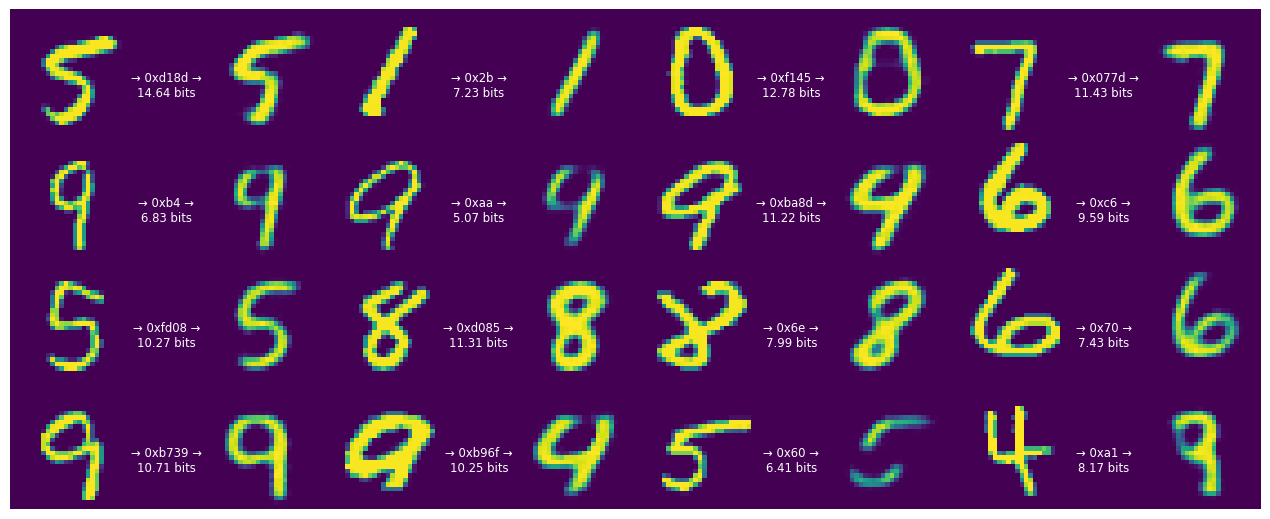

In [26]:
train_and_visualize_model(lmbda=300)


The strings begin to get much shorter now, on the order of one byte per digit. However, this comes at a cost. More digits are becoming unrecognizable.

This demonstrates that this model is agnostic to human perceptions of error, it just measures the absolute deviation in terms of pixel values. To achieve a better perceived image quality, we would need to replace the pixel loss with a perceptual loss.

## Use the decoder as a generative model.

If we feed the decoder random bits, this will effectively sample from the distribution that the model learned to represent digits.

First, re-instantiate the compressor/decompressor without a sanity check that would detect if the input string isn't completely decoded.

In [27]:
compressor, decompressor = make_mnist_codec(trainer, decode_sanity_check=False)


Now, feed long enough random strings into the decompressor so that it can decode/sample digits from them.

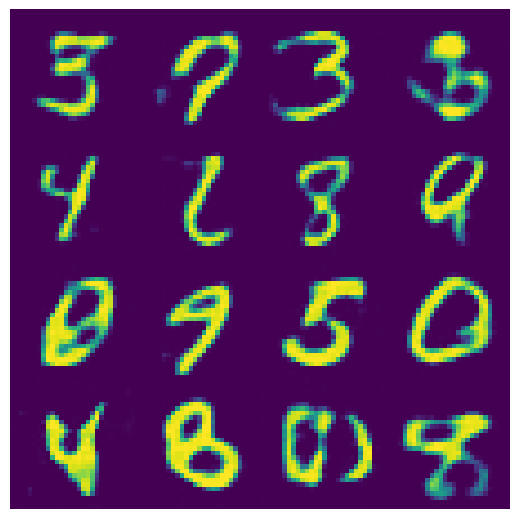

In [28]:
import os

strings = tf.constant([os.urandom(8) for _ in range(16)])
samples = decompressor(strings)

fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.ravel()
for i in range(len(axes)):
  axes[i].imshow(tf.squeeze(samples[i]))
  axes[i].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
